In [ ]:
import pandas as pd
import numpy as np
from typing import Tuple, List

def classify_student_type(row: pd.Series) -> str:
    """
    分类函数：判断学生是偏科型还是均衡型
    
    偏科型判定标准：
    1. 显著性过滤：强/弱知识点需满足最低题量阈值（≥5题）
       - 强项知识点：pk > 0.8 且 Nk ≥ 5
       - 弱项知识点：pk < 0.4 且 Nk ≥ 5
    2. 效应量评估：计算强项与弱项的Cohen's d值
       - 仅当 |d| > 0.8 时判定为显著偏科
    
    参数:
        row: 包含学生数据的pandas Series
    
    返回:
        str: "偏科型" 或 "均衡型"
    """
    # 解析数据并排除填充值-1
    all_concepts = [int(x) for x in row['concepts'].split(',')]
    all_responses = [int(x) for x in row['responses'].split(',')]
    
    # 过滤掉填充值-1
    valid_data = [(concept, response) for concept, response in zip(all_concepts, all_responses) 
                  if concept != -1 and response != -1]
    
    if not valid_data:
        return "均衡型"  # 如果没有有效数据，默认为均衡型
    
    concepts, responses = zip(*valid_data)
    concepts = list(concepts)
    responses = list(responses)
    
    # 计算每个概念的正确率和题量
    concept_accuracy = calculate_concept_accuracy(concepts, responses)
    
    # 显著性过滤：识别强项和弱项知识点
    strong_concepts = {}  # 强项知识点
    weak_concepts = {}    # 弱项知识点
    
    for concept, accuracy in concept_accuracy.items():
        # 计算该概念的题量
        concept_count = concepts.count(concept)
        
        # 强项知识点：正确率 > 0.8 且题量 ≥ 5
        if accuracy > 0.8 and concept_count >= 5:
            strong_concepts[concept] = {
                'accuracy': accuracy,
                'count': concept_count
            }
        
        # 弱项知识点：正确率 < 0.4 且题量 ≥ 5
        elif accuracy < 0.4 and concept_count >= 5:
            weak_concepts[concept] = {
                'accuracy': accuracy,
                'count': concept_count
            }
    
    # 如果没有同时存在强项和弱项，则为均衡型
    if not strong_concepts or not weak_concepts:
        return "均衡型"
    
    # 计算Cohen's d值
    cohens_d = calculate_cohens_d(strong_concepts, weak_concepts)
    
    # 判定标准：|d| > 0.8 为显著偏科
    if abs(cohens_d) > 0.8:
        return "偏科型"
    else:
        return "均衡型"

def parse_student_data(row: pd.Series) -> dict:
    """
    解析学生数据，将字符串格式的列表转换为实际的列表，并排除填充值-1
    
    参数:
        row: 原始数据行
    
    返回:
        dict: 解析后的数据字典
    """
    # 解析所有数据
    all_questions = [int(x) for x in row['questions'].split(',')]
    all_concepts = [int(x) for x in row['concepts'].split(',')]
    all_responses = [int(x) for x in row['responses'].split(',')]
    all_is_repeat = [int(x) for x in row['is_repeat'].split(',')]
    
    # 过滤掉填充值-1（以concepts和responses为准，因为这两个是分类的关键字段）
    valid_indices = [i for i, (concept, response) in enumerate(zip(all_concepts, all_responses)) 
                     if concept != -1 and response != -1]
    
    return {
        'fold': row['fold'],
        'uid': row['uid'],
        'questions': [all_questions[i] for i in valid_indices if i < len(all_questions)],
        'concepts': [all_concepts[i] for i in valid_indices],
        'responses': [all_responses[i] for i in valid_indices],
        'is_repeat': [all_is_repeat[i] for i in valid_indices if i < len(all_is_repeat)]
    }

def calculate_cohens_d(strong_concepts: dict, weak_concepts: dict) -> float:
    """
    计算强项与弱项知识点之间的Cohen's d效应量
    
    公式：d = (p_strong - p_weak) / sqrt(((N_strong-1)*s_strong^2 + (N_weak-1)*s_weak^2) / (N_strong + N_weak - 2))
    
    参数:
        strong_concepts: 强项知识点字典 {concept_id: {'accuracy': float, 'count': int}}
        weak_concepts: 弱项知识点字典 {concept_id: {'accuracy': float, 'count': int}}
    
    返回:
        float: Cohen's d值
    """
    # 提取强项数据
    strong_accuracies = [data['accuracy'] for data in strong_concepts.values()]
    strong_counts = [data['count'] for data in strong_concepts.values()]
    
    # 提取弱项数据
    weak_accuracies = [data['accuracy'] for data in weak_concepts.values()]
    weak_counts = [data['count'] for data in weak_concepts.values()]
    
    # 计算加权平均正确率
    strong_total_questions = sum(strong_counts)
    weak_total_questions = sum(weak_counts)
    
    p_strong = sum(acc * count for acc, count in zip(strong_accuracies, strong_counts)) / strong_total_questions
    p_weak = sum(acc * count for acc, count in zip(weak_accuracies, weak_counts)) / weak_total_questions
    
    # 计算加权方差
    strong_variance = sum(count * (acc - p_strong)**2 for acc, count in zip(strong_accuracies, strong_counts)) / strong_total_questions
    weak_variance = sum(count * (acc - p_weak)**2 for acc, count in zip(weak_accuracies, weak_counts)) / weak_total_questions
    
    # 计算合并标准差
    n_strong = len(strong_concepts)
    n_weak = len(weak_concepts)
    
    if n_strong + n_weak <= 2:
        return 0.0
    
    pooled_variance = ((n_strong - 1) * strong_variance + (n_weak - 1) * weak_variance) / (n_strong + n_weak - 2)
    
    if pooled_variance == 0:
        return 0.0
    
    pooled_std = np.sqrt(pooled_variance)
    
    # 计算Cohen's d
    cohens_d = (p_strong - p_weak)
    # cohens_d = (p_strong - p_weak) / pooled_std
    
    return cohens_d
    """
    计算每个概念的正确率
    
    参数:
        concepts: 概念ID列表
        responses: 对应的回答结果列表
    
    返回:
        dict: 概念ID到正确率的映射
    """
    concept_stats = {}
    
    for concept, response in zip(concepts, responses):
        if concept not in concept_stats:
            concept_stats[concept] = {'correct': 0, 'total': 0}
        
        concept_stats[concept]['total'] += 1
        if response == 1:
            concept_stats[concept]['correct'] += 1
    
    # 计算正确率
    concept_accuracy = {}
    for concept, stats in concept_stats.items():
        concept_accuracy[concept] = stats['correct'] / stats['total']
    
    return concept_accuracy

def main(input_csv_path: str, output_dir: str = './'):
    """
    主函数：读取CSV文件，分类学生，保存结果
    
    参数:
        input_csv_path: 输入CSV文件路径
        output_dir: 输出目录路径
    """
    
    # 1. 读取CSV文件
    print("正在读取CSV文件...")
    df = pd.read_csv(input_csv_path)
    print(f"共读取到 {len(df)} 条学生记录")
    
    # 2. 分类学生
    print("正在分类学生...")
    df['student_type'] = df.apply(classify_student_type, axis=1)
    
    # 3. 统计分类结果
    type_counts = df['student_type'].value_counts()
    print("分类结果统计:")
    for student_type, count in type_counts.items():
        print(f"  {student_type}: {count} 人")
    
    # 4. 分别保存两类学生的数据
    specialized_students = df[df['student_type'] == '偏科型'].copy()
    balanced_students = df[df['student_type'] == '均衡型'].copy()
    
    # 移除分类标签列（如果不需要保存的话）
    specialized_students = specialized_students.drop('student_type', axis=1)
    balanced_students = balanced_students.drop('student_type', axis=1)
    
    # 5. 保存为新的CSV文件
    specialized_output_path = f"{output_dir}/pk.csv"
    balanced_output_path = f"{output_dir}/ph.csv"
    
    specialized_students.to_csv(specialized_output_path, index=False)
    balanced_students.to_csv(balanced_output_path, index=False)
    
    print(f"偏科型学生数据已保存到: {specialized_output_path} ({len(specialized_students)} 人)")
    print(f"均衡型学生数据已保存到: {balanced_output_path} ({len(balanced_students)} 人)")
    
    return specialized_students, balanced_students
def calculate_concept_accuracy(concepts: List[int], responses: List[int]) -> dict:
    """
    计算每个概念的正确率
    
    参数:
        concepts: 概念ID列表
        responses: 对应的回答结果列表
    
    返回:
        dict: 概念ID到正确率的映射
    """
    concept_stats = {}
    
    for concept, response in zip(concepts, responses):
        if concept not in concept_stats:
            concept_stats[concept] = {'correct': 0, 'total': 0}
        
        concept_stats[concept]['total'] += 1
        if response == 1:
            concept_stats[concept]['correct'] += 1
    
    # 计算正确率
    concept_accuracy = {}
    for concept, stats in concept_stats.items():
        concept_accuracy[concept] = stats['correct'] / stats['total']
    
    return concept_accuracy
# 使用示例
if __name__ == "__main__":
    # 指定输入文件路径
    input_file = "/root/autodl-tmp/pykt_self_version/data/assist2009/old_test_question_window_sequences.csv"  # 替换为你的实际文件路径
    output_directory = "/root/autodl-tmp/pykt_self_version/data/assist2009/"  # 输出目录
    
    # 执行分类和保存
    specialized_df, balanced_df = main(input_file, output_directory)
    
    print("处理完成！")

In [ ]:
!python wandb_predict.py --save_dir "/root/autodl-tmp/pykt_self_version/examples/saved_model/assist2009_dkt_qid_saved_model_3407_0_0.5_256_0.001_0_1_0"

## 按照学生人数划分

In [ ]:
import pandas as pd
import numpy as np
from typing import Tuple, List, Dict

def calculate_student_variance(uid_data: pd.DataFrame) -> float:
    """
    计算单个学生的知识点正确率差值
    使用前20%高正确率知识点和后20%低正确率知识点的平均正确率差值
    
    参数:
        uid_data: 包含同一个uid所有记录的DataFrame
    
    返回:
        float: 高正确率知识点平均值 - 低正确率知识点平均值，如果没有符合条件的知识点返回0
    """
    # 合并所有行的数据
    all_concepts = []
    all_responses = []
    
    for _, row in uid_data.iterrows():
        concepts = [int(x) for x in row['concepts'].split(',')]
        responses = [int(x) for x in row['responses'].split(',')]
        
        # 过滤掉填充值-1
        valid_pairs = [(c, r) for c, r in zip(concepts, responses) if c != -1 and r != -1]
        if valid_pairs:
            valid_concepts, valid_responses = zip(*valid_pairs)
            all_concepts.extend(valid_concepts)
            all_responses.extend(valid_responses)
    
    if not all_concepts:
        return 0.0
    
    # 统计每个概念的正确率和题量
    concept_stats = {}
    for concept, response in zip(all_concepts, all_responses):
        if concept not in concept_stats:
            concept_stats[concept] = {'correct': 0, 'total': 0}
        
        concept_stats[concept]['total'] += 1
        if response == 1:
            concept_stats[concept]['correct'] += 1
    
    # 只考虑做题数量>5的知识点
    valid_concept_accuracies = []
    for concept, stats in concept_stats.items():
        if stats['total'] > 5:  # 题量大于5
            accuracy = stats['correct'] / stats['total']
            valid_concept_accuracies.append((concept, accuracy))
    
    # 如果没有符合条件的知识点，返回0
    if not valid_concept_accuracies:
        return 0.0
    
    # 如果只有一个知识点，差值为0
    if len(valid_concept_accuracies) == 1:
        return 0.0
    
    # 按正确率排序
    valid_concept_accuracies.sort(key=lambda x: x[1], reverse=True)
    
    # 计算前20%和后20%的数量
    n_concepts = len(valid_concept_accuracies)
    n_top = max(1, int(n_concepts * 0.2))  # 至少取1个
    n_bottom = max(1, int(n_concepts * 0.2))  # 至少取1个
    
    # 获取前20%的知识点正确率
    top_accuracies = [acc for _, acc in valid_concept_accuracies[:n_top]]
    # 获取后20%的知识点正确率
    bottom_accuracies = [acc for _, acc in valid_concept_accuracies[-n_bottom:]]
    
    # 计算平均值
    avg_top = sum(top_accuracies) / len(top_accuracies)
    avg_bottom = sum(bottom_accuracies) / len(bottom_accuracies)
    
    # 返回差值
    variance = avg_top - avg_bottom
    
    return variance

def classify_students_by_variance(df: pd.DataFrame) -> pd.DataFrame:
    """
    根据正确率差值将学生分为三类
    前33%为偏科型，后33%为均衡型，中间为普通型
    
    参数:
        df: 原始数据DataFrame
    
    返回:
        pd.DataFrame: 添加了分类标签的DataFrame
    """
    # 按uid分组计算每个学生的差值
    student_variances = {}
    
    for uid, group in df.groupby('uid'):
        variance = calculate_student_variance(group)
        student_variances[uid] = variance
    
    # 创建学生级别的DataFrame
    student_df = pd.DataFrame(list(student_variances.items()), columns=['uid', 'variance'])
    
    # 使用pandas的qcut进行等频分箱，确保每组数量尽可能相等
    # 注意：标签顺序改变，因为现在前33%是偏科（差值大），后33%是均衡（差值小）
    try:
        # 尝试使用qcut进行三等分
        student_df['student_type'] = pd.qcut(student_df['variance'], 
                                            q=3, 
                                            labels=['均衡型', '普通型', '偏科型'],  # 从小到大对应的标签
                                            duplicates='drop')
    except:
        # 如果无法均分（比如太多相同值），使用rank方法
        student_df['rank'] = student_df['variance'].rank(method='first')
        n_students = len(student_df)
        
        # 基于排名进行三等分
        student_df['student_type'] = pd.cut(student_df['rank'],
                                           bins=[0, n_students/3, 2*n_students/3, n_students+1],
                                           labels=['均衡型', '普通型', '偏科型'],
                                           include_lowest=True)
    
    # 将分类结果合并回原始DataFrame
    type_mapping = dict(zip(student_df['uid'], student_df['student_type']))
    variance_mapping = dict(zip(student_df['uid'], student_df['variance']))
    
    df['variance'] = df['uid'].map(variance_mapping)
    df['student_type'] = df['uid'].map(type_mapping)
    
    return df

def main(input_csv_path: str, output_dir: str = './'):
    """
    主函数：读取CSV文件，分类学生，保存结果
    
    参数:
        input_csv_path: 输入CSV文件路径
        output_dir: 输出目录路径
    """
    
    # 1. 读取CSV文件
    print("正在读取CSV文件...")
    df = pd.read_csv(input_csv_path)
    print(f"共读取到 {len(df)} 条记录")
    print(f"共有 {df['uid'].nunique()} 个不同的学生")
    
    # 2. 按差值分类学生
    print("\n正在计算学生知识点掌握差异度...")
    df_classified = classify_students_by_variance(df)
    
    # 3. 统计分类结果（按学生统计，而不是按记录）
    student_summary = df_classified[['uid', 'student_type', 'variance']].drop_duplicates()
    type_counts = student_summary['student_type'].value_counts()
    
    print("\n分类结果统计:")
    print(f"总学生数: {len(student_summary)}")
    for student_type in ['偏科型', '普通型', '均衡型']:
        if student_type in type_counts.index:
            count = type_counts[student_type]
            percentage = (count / len(student_summary)) * 100
            print(f"  {student_type}: {count} 人 ({percentage:.1f}%)")
            
            # 显示该类型学生的差值范围
            type_variances = student_summary[student_summary['student_type'] == student_type]['variance']
            if len(type_variances) > 0:
                print(f"    差值范围: {type_variances.min():.3f} - {type_variances.max():.3f}")
                print(f"    平均差值: {type_variances.mean():.3f}")
    
    # 4. 分别保存三类学生的数据
    specialized_students = df_classified[df_classified['student_type'] == '偏科型'].copy()
    normal_students = df_classified[df_classified['student_type'] == '普通型'].copy()
    balanced_students = df_classified[df_classified['student_type'] == '均衡型'].copy()
    
    # 移除临时列
    for df_subset in [specialized_students, normal_students, balanced_students]:
        df_subset.drop(['student_type', 'variance'], axis=1, inplace=True)
    
    # 5. 保存为新的CSV文件
    specialized_output_path = f"{output_dir}/pk.csv"
    normal_output_path = f"{output_dir}/pt.csv"
    balanced_output_path = f"{output_dir}/ph.csv"
    
    specialized_students.to_csv(specialized_output_path, index=False)
    normal_students.to_csv(normal_output_path, index=False)
    balanced_students.to_csv(balanced_output_path, index=False)
    
    print(f"\n数据已保存:")
    print(f"偏科型学生数据: {specialized_output_path} ({len(specialized_students)} 条记录)")
    print(f"普通型学生数据: {normal_output_path} ({len(normal_students)} 条记录)")
    print(f"均衡型学生数据: {balanced_output_path} ({len(balanced_students)} 条记录)")
    
    # 6. 显示一些示例
    print("\n示例分析:")
    # 显示差值最大的学生
    top_student = student_summary.nlargest(1, 'variance').iloc[0]
    print(f"差值最大的学生: UID={top_student['uid']}, 差值={top_student['variance']:.3f}, 类型={top_student['student_type']}")
    
    # 显示差值最小的学生
    bottom_student = student_summary.nsmallest(1, 'variance').iloc[0]
    print(f"差值最小的学生: UID={bottom_student['uid']}, 差值={bottom_student['variance']:.3f}, 类型={bottom_student['student_type']}")
    
    # 显示差值分布信息
    print(f"\n差值分布统计:")
    print(f"最小值: {student_summary['variance'].min():.3f}")
    print(f"25%分位数: {student_summary['variance'].quantile(0.25):.3f}")
    print(f"中位数: {student_summary['variance'].median():.3f}")
    print(f"75%分位数: {student_summary['variance'].quantile(0.75):.3f}")
    print(f"最大值: {student_summary['variance'].max():.3f}")
    print(f"标准差: {student_summary['variance'].std():.3f}")
    
    return specialized_students, normal_students, balanced_students

# 使用示例
if __name__ == "__main__":
    # 指定输入文件路径
    input_file = "/root/autodl-tmp/pykt_self_version/data/assist2009/test_question_window_sequences.csv"
    output_directory = "/root/autodl-tmp/pykt_self_version/data/assist2009/"
    
    # 执行分类和保存
    specialized_df, normal_df, balanced_df = main(input_file, output_directory)
    
    print("\n处理完成！")

## 找数据量大的学生出来(将学生进行切分成单个测试集)

In [2]:
import pandas as pd
import numpy as np
from typing import Dict
import os

def calculate_student_detailed_stats(uid_data: pd.DataFrame) -> Dict:
    """计算单个学生的详细统计信息"""
    all_concepts = []
    all_responses = []
    
    for _, row in uid_data.iterrows():
        concepts = [int(x) for x in row['concepts'].split(',')]
        responses = [int(x) for x in row['responses'].split(',')]
        
        valid_pairs = [(c, r) for c, r in zip(concepts, responses) if c != -1 and r != -1]
        if valid_pairs:
            valid_concepts, valid_responses = zip(*valid_pairs)
            all_concepts.extend(valid_concepts)
            all_responses.extend(valid_responses)
    
    if not all_concepts:
        return {
            'record_count': len(uid_data),
            'total_questions': 0,
            'num_valid_concepts': 0,
            'avg_questions_per_concept': 0.0,
            'max_questions_per_concept': 0,
            'min_questions_per_concept': 0,
            'questions_range': 0,
            'overall_accuracy': 0.0,
            'accuracy_range': 0.0,
            'accuracy_variance': 0.0,
            'max_accuracy': 0.0,
            'min_accuracy': 0.0
        }
    
    concept_stats = {}
    for concept, response in zip(all_concepts, all_responses):
        if concept not in concept_stats:
            concept_stats[concept] = {'correct': 0, 'total': 0}
        concept_stats[concept]['total'] += 1
        if response == 1:
            concept_stats[concept]['correct'] += 1
    
    # 筛选出有效知识点（做题数量 > 知识点数量阈值）
    valid_concept_stats = {}
    for concept, stats in concept_stats.items():
        if stats['total'] > 知识点数量:
            valid_concept_stats[concept] = stats
    
    # 基本统计信息
    total_questions = len(all_concepts)
    overall_accuracy = sum(all_responses) / len(all_responses) if all_responses else 0.0
    num_valid_concepts = len(valid_concept_stats)
    
    # 初始化默认值
    avg_questions_per_concept = 0.0
    max_questions_per_concept = 0
    min_questions_per_concept = 0
    questions_range = 0
    max_accuracy = 0.0
    min_accuracy = 0.0
    accuracy_range = 0.0
    accuracy_variance = 0.0
    
    if num_valid_concepts > 0:
        # 知识点题目数量统计
        question_counts = [stats['total'] for stats in valid_concept_stats.values()]
        avg_questions_per_concept = np.mean(question_counts)
        max_questions_per_concept = max(question_counts)
        min_questions_per_concept = min(question_counts)
        questions_range = max_questions_per_concept - min_questions_per_concept
        
        # 知识点正确率统计
        accuracies = [stats['correct'] / stats['total'] for stats in valid_concept_stats.values()]
        max_accuracy = max(accuracies)
        min_accuracy = min(accuracies)
        accuracy_range = max_accuracy - min_accuracy
        accuracy_variance = np.var(accuracies) if len(accuracies) > 1 else 0.0
    
    return {
        'record_count': len(uid_data),
        'total_questions': total_questions,
        'num_valid_concepts': num_valid_concepts,
        'avg_questions_per_concept': avg_questions_per_concept,
        'max_questions_per_concept': max_questions_per_concept,
        'min_questions_per_concept': min_questions_per_concept,
        'questions_range': questions_range,
        'overall_accuracy': overall_accuracy,
        'max_accuracy': max_accuracy,
        'min_accuracy': min_accuracy,
        'accuracy_range': accuracy_range,
        'accuracy_variance': accuracy_variance
    }

def print_top_students_details(student_summary: pd.DataFrame, num_students: int = 5):
    """打印记录数最多的学生的详细信息"""
    top_students = student_summary.sort_values('record_count', ascending=False).head(num_students)
    
    print(f"\n=== 记录数最多的{num_students}个学生详细信息 ===")
    
    for i, (_, student) in enumerate(top_students.iterrows()):
        print(f"\n第{i+1}名学生 (UID: {student['uid']}):")
        print(f"  总记录数: {student['record_count']}")
        print(f"  总做题数: {student['total_questions']}")
        print(f"  有效知识点数: {student['num_valid_concepts']}")
        print(f"  平均每知识点做题数: {student['avg_questions_per_concept']:.1f}")
        print(f"  知识点做题数范围: {student['min_questions_per_concept']} - {student['max_questions_per_concept']} (差值: {student['questions_range']})")
        print(f"  总体正确率: {student['overall_accuracy']:.3f}")
        print(f"  知识点正确率范围: {student['min_accuracy']:.3f} - {student['max_accuracy']:.3f} (差值: {student['accuracy_range']:.3f})")
        print(f"  知识点正确率方差: {student['accuracy_variance']:.4f}")

def main(input_csv_path: str, output_dir: str = './'):
    num_needs_stu = 770
    
    """主函数：处理数据并保存前770个学生数据"""
    print("正在读取CSV文件...")
    df = pd.read_csv(input_csv_path)
    print(f"共读取到 {len(df)} 条记录")
    print(f"共有 {df['uid'].nunique()} 个不同的学生")
    
    print("\n正在计算学生详细统计信息...")
    student_info = {}
    for uid, group in df.groupby('uid'):
        student_info[uid] = calculate_student_detailed_stats(group)
        # 添加UID到统计信息中
        student_info[uid]['uid'] = uid
    
    # 创建学生DataFrame并排序
    student_summary = pd.DataFrame(list(student_info.values()))
    student_summary = student_summary.sort_values('record_count', ascending=False)
    
    # 按记录数排序取前770
    top_students = student_summary.head(num_needs_stu)
    
    # 打印top学生详细信息
    print_top_students_details(top_students, min(5, num_needs_stu))
    
    # 为前770个学生保存单独文件
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    print(f"\n保存数据量最多的{num_needs_stu}个学生数据:")
    for i, row in top_students.iterrows():
        uid = row['uid']
        record_count = row['record_count']
        student_data = df[df['uid'] == uid]
        
        # 添加统计信息到学生数据中
        for stat_col in ['record_count', 'total_questions', 'num_valid_concepts', 
                         'avg_questions_per_concept', 'max_questions_per_concept', 
                         'min_questions_per_concept', 'questions_range', 
                         'overall_accuracy', 'accuracy_range', 'accuracy_variance',
                         'max_accuracy', 'min_accuracy']:
            if stat_col in row:
                student_data[stat_col] = row[stat_col]
        
        filename = f"top_{i+1}_student.csv"
        filepath = os.path.join(output_dir, filename)
        
        student_data.to_csv(filepath, index=False)
        print(f"  学生#{i+1}: uid={uid}, 记录数={record_count} -> 已保存到 {filepath}")
    
    # 保存完整的学生统计摘要
    summary_output_path = f"{output_dir}/student_summary.csv"
    student_summary.to_csv(summary_output_path, index=False)
    print(f"\n学生统计摘要已保存到: {summary_output_path}")
    print("\n处理完成！")

知识点数量 = 1

if __name__ == "__main__":
    dataset = "assist2009"
    input_file = f"/root/autodl-tmp/pykt_self_version/data/{dataset}/test_question_window_sequences.csv"
    output_directory = f"/root/autodl-tmp/pykt_self_version/data/{dataset}/"
    main(input_file, output_directory)

正在读取CSV文件...
共读取到 30610 条记录
共有 770 个不同的学生

正在计算学生详细统计信息...

=== 记录数最多的5个学生详细信息 ===

第1名学生 (UID: 90.0):
  总记录数: 899.0
  总做题数: 178040.0
  有效知识点数: 66.0
  平均每知识点做题数: 2697.6
  知识点做题数范围: 39.0 - 26604.0 (差值: 26565.0)
  总体正确率: 0.574
  知识点正确率范围: 0.077 - 1.000 (差值: 0.923)
  知识点正确率方差: 0.0536

第2名学生 (UID: 83.0):
  总记录数: 842.0
  总做题数: 168068.0
  有效知识点数: 78.0
  平均每知识点做题数: 2154.7
  知识点做题数范围: 27.0 - 12014.0 (差值: 11987.0)
  总体正确率: 0.615
  知识点正确率范围: 0.000 - 1.000 (差值: 1.000)
  知识点正确率方差: 0.0563

第3名学生 (UID: 443.0):
  总记录数: 833.0
  总做题数: 158614.0
  有效知识点数: 72.0
  平均每知识点做题数: 2203.0
  知识点做题数范围: 121.0 - 10856.0 (差值: 10735.0)
  总体正确率: 0.569
  知识点正确率范围: 0.000 - 1.000 (差值: 1.000)
  知识点正确率方差: 0.0696

第4名学生 (UID: 437.0):
  总记录数: 827.0
  总做题数: 161752.0
  有效知识点数: 72.0
  平均每知识点做题数: 2246.6
  知识点做题数范围: 16.0 - 11975.0 (差值: 11959.0)
  总体正确率: 0.575
  知识点正确率范围: 0.000 - 1.000 (差值: 1.000)
  知识点正确率方差: 0.0718

第5名学生 (UID: 431.0):
  总记录数: 759.0
  总做题数: 143977.0
  有效知识点数: 74.0
  平均每知识点做题数: 1945.6
  知识点做题数范围: 6.0 - 21190.0 (差值: 

/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data[stat_col] = row[stat_col]
/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data[stat_col] = row[stat_col]
/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

  学生#79: uid=437.0, 记录数=827.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_79_student.csv
  学生#78: uid=431.0, 记录数=759.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_78_student.csv
  学生#88: uid=483.0, 记录数=700.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_88_student.csv
  学生#77: uid=428.0, 记录数=697.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_77_student.csv
  学生#11: uid=65.0, 记录数=680.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_11_student.csv


/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data[stat_col] = row[stat_col]
/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data[stat_col] = row[stat_col]
/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

  学生#12: uid=68.0, 记录数=662.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_12_student.csv
  学生#15: uid=104.0, 记录数=653.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_15_student.csv
  学生#89: uid=485.0, 记录数=638.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_89_student.csv
  学生#80: uid=442.0, 记录数=631.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_80_student.csv
  学生#21: uid=138.0, 记录数=617.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_21_student.csv


/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data[stat_col] = row[stat_col]
/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data[stat_col] = row[stat_col]
/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

  学生#1: uid=7.0, 记录数=604.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_1_student.csv
  学生#10: uid=61.0, 记录数=585.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_10_student.csv
  学生#7: uid=46.0, 记录数=511.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_7_student.csv
  学生#9: uid=56.0, 记录数=508.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_9_student.csv
  学生#17: uid=116.0, 记录数=498.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_17_student.csv
  学生#86: uid=472.0, 记录数=487.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_86_student.csv


/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data[stat_col] = row[stat_col]
/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data[stat_col] = row[stat_col]
/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

  学生#76: uid=426.0, 记录数=480.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_76_student.csv
  学生#20: uid=129.0, 记录数=479.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_20_student.csv
  学生#18: uid=118.0, 记录数=448.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_18_student.csv
  学生#87: uid=481.0, 记录数=442.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_87_student.csv
  学生#85: uid=455.0, 记录数=438.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_85_student.csv
  学生#84: uid=454.0, 记录数=430.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_84_student.csv


/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data[stat_col] = row[stat_col]
/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data[stat_col] = row[stat_col]
/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

  学生#8: uid=48.0, 记录数=423.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_8_student.csv
  学生#16: uid=108.0, 记录数=421.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_16_student.csv
  学生#82: uid=446.0, 记录数=419.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_82_student.csv
  学生#19: uid=123.0, 记录数=418.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_19_student.csv
  学生#83: uid=451.0, 记录数=399.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_83_student.csv
  学生#75: uid=424.0, 记录数=393.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_75_student.csv
  学生#197: uid=1026.0, 记录数=367.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_197_student.csv


/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data[stat_col] = row[stat_col]
/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data[stat_col] = row[stat_col]
/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

  学生#91: uid=500.0, 记录数=343.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_91_student.csv
  学生#2: uid=12.0, 记录数=340.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_2_student.csv
  学生#90: uid=495.0, 记录数=273.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_90_student.csv
  学生#119: uid=609.0, 记录数=223.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_119_student.csv
  学生#190: uid=998.0, 记录数=220.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_190_student.csv
  学生#191: uid=1001.0, 记录数=212.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_191_student.csv
  学生#198: uid=1028.0, 记录数=209.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_198_student.csv
  学生#261: uid=1306.0, 记录数=207.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_261_student.csv
  学生#192: uid=1002.0, 记录数=200.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_192_student.csv
  学生#6: uid=37.

/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data[stat_col] = row[stat_col]
/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data[stat_col] = row[stat_col]
/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

  学生#29: uid=176.0, 记录数=146.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_29_student.csv
  学生#242: uid=1218.0, 记录数=146.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_242_student.csv
  学生#193: uid=1007.0, 记录数=142.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_193_student.csv
  学生#175: uid=887.0, 记录数=132.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_175_student.csv
  学生#368: uid=1838.0, 记录数=129.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_368_student.csv
  学生#189: uid=987.0, 记录数=122.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_189_student.csv
  学生#157: uid=800.0, 记录数=121.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_157_student.csv
  学生#48: uid=305.0, 记录数=118.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_48_student.csv
  学生#27: uid=166.0, 记录数=117.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_27_student.csv
  学生#180: uid

/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data[stat_col] = row[stat_col]
/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data[stat_col] = row[stat_col]
/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

  学生#226: uid=1150.0, 记录数=83.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_226_student.csv
  学生#111: uid=586.0, 记录数=80.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_111_student.csv
  学生#115: uid=601.0, 记录数=79.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_115_student.csv
  学生#122: uid=638.0, 记录数=76.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_122_student.csv
  学生#126: uid=656.0, 记录数=75.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_126_student.csv
  学生#97: uid=529.0, 记录数=74.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_97_student.csv
  学生#125: uid=648.0, 记录数=74.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_125_student.csv
  学生#35: uid=229.0, 记录数=73.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_35_student.csv
  学生#152: uid=776.0, 记录数=73.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_152_student.csv
  学生#181: uid=909.0, 记

/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data[stat_col] = row[stat_col]
/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data[stat_col] = row[stat_col]
/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

  学生#134: uid=696.0, 记录数=55.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_134_student.csv
  学生#106: uid=551.0, 记录数=55.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_106_student.csv
  学生#523: uid=2609.0, 记录数=54.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_523_student.csv
  学生#211: uid=1093.0, 记录数=52.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_211_student.csv
  学生#210: uid=1092.0, 记录数=52.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_210_student.csv
  学生#139: uid=709.0, 记录数=51.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_139_student.csv
  学生#34: uid=224.0, 记录数=51.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_34_student.csv
  学生#416: uid=2051.0, 记录数=50.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_416_student.csv
  学生#178: uid=894.0, 记录数=50.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_178_student.csv
  学生#4: uid=28.0,

/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data[stat_col] = row[stat_col]
/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data[stat_col] = row[stat_col]
/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

  学生#235: uid=1190.0, 记录数=38.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_235_student.csv
  学生#405: uid=1996.0, 记录数=38.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_405_student.csv
  学生#424: uid=2090.0, 记录数=37.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_424_student.csv
  学生#243: uid=1219.0, 记录数=37.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_243_student.csv
  学生#163: uid=829.0, 记录数=37.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_163_student.csv
  学生#187: uid=962.0, 记录数=37.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_187_student.csv
  学生#5: uid=31.0, 记录数=37.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_5_student.csv
  学生#70: uid=399.0, 记录数=36.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_70_student.csv
  学生#96: uid=527.0, 记录数=36.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_96_student.csv
  学生#120: uid=633.0, 记录数

/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data[stat_col] = row[stat_col]
/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data[stat_col] = row[stat_col]
/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

  学生#144: uid=734.0, 记录数=25.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_144_student.csv
  学生#362: uid=1819.0, 记录数=25.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_362_student.csv
  学生#136: uid=702.0, 记录数=24.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_136_student.csv
  学生#54: uid=327.0, 记录数=24.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_54_student.csv
  学生#263: uid=1319.0, 记录数=24.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_263_student.csv
  学生#413: uid=2042.0, 记录数=24.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_413_student.csv
  学生#168: uid=856.0, 记录数=24.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_168_student.csv
  学生#68: uid=388.0, 记录数=24.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_68_student.csv
  学生#557: uid=2755.0, 记录数=24.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_557_student.csv
  学生#475: uid=2365.

/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data[stat_col] = row[stat_col]
/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data[stat_col] = row[stat_col]
/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

  学生#204: uid=1076.0, 记录数=15.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_204_student.csv
  学生#245: uid=1222.0, 记录数=15.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_245_student.csv
  学生#42: uid=263.0, 记录数=14.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_42_student.csv
  学生#37: uid=239.0, 记录数=14.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_37_student.csv
  学生#476: uid=2370.0, 记录数=14.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_476_student.csv
  学生#264: uid=1322.0, 记录数=14.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_264_student.csv
  学生#207: uid=1085.0, 记录数=13.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_207_student.csv
  学生#641: uid=3172.0, 记录数=13.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_641_student.csv
  学生#459: uid=2285.0, 记录数=13.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_459_student.csv
  学生#575: uid=28

/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data[stat_col] = row[stat_col]
/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data[stat_col] = row[stat_col]
/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

  学生#587: uid=2916.0, 记录数=9.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_587_student.csv
  学生#577: uid=2864.0, 记录数=9.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_577_student.csv
  学生#215: uid=1118.0, 记录数=9.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_215_student.csv
  学生#559: uid=2757.0, 记录数=9.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_559_student.csv
  学生#58: uid=351.0, 记录数=9.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_58_student.csv
  学生#60: uid=354.0, 记录数=9.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_60_student.csv
  学生#59: uid=352.0, 记录数=9.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_59_student.csv
  学生#244: uid=1220.0, 记录数=9.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_244_student.csv
  学生#61: uid=355.0, 记录数=9.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_61_student.csv
  学生#448: uid=2213.0, 记录数=9.0 -

/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data[stat_col] = row[stat_col]
/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data[stat_col] = row[stat_col]
/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

  学生#209: uid=1091.0, 记录数=4.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_209_student.csv
  学生#65: uid=375.0, 记录数=4.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_65_student.csv
  学生#494: uid=2458.0, 记录数=4.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_494_student.csv
  学生#562: uid=2785.0, 记录数=4.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_562_student.csv
  学生#267: uid=1336.0, 记录数=4.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_267_student.csv
  学生#224: uid=1143.0, 记录数=4.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_224_student.csv
  学生#56: uid=332.0, 记录数=3.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_56_student.csv
  学生#225: uid=1147.0, 记录数=3.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_225_student.csv
  学生#246: uid=1229.0, 记录数=3.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_246_student.csv
  学生#248: uid=1235.0, 记录数

/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data[stat_col] = row[stat_col]
/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data[stat_col] = row[stat_col]
/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

  学生#608: uid=3026.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_608_student.csv
  学生#607: uid=3020.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_607_student.csv
  学生#606: uid=3017.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_606_student.csv
  学生#602: uid=2995.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_602_student.csv
  学生#612: uid=3049.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_612_student.csv
  学生#611: uid=3048.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_611_student.csv
  学生#610: uid=3036.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_610_student.csv
  学生#609: uid=3035.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_609_student.csv
  学生#253: uid=1260.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_253_student.csv
  学生#247: uid=1231.

/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data[stat_col] = row[stat_col]
/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data[stat_col] = row[stat_col]
/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

  学生#312: uid=1563.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_312_student.csv
  学生#311: uid=1561.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_311_student.csv
  学生#310: uid=1559.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_310_student.csv
  学生#309: uid=1555.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_309_student.csv
  学生#308: uid=1552.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_308_student.csv
  学生#284: uid=1455.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_284_student.csv
  学生#705: uid=3500.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_705_student.csv
  学生#704: uid=3499.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_704_student.csv
  学生#703: uid=3498.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_703_student.csv
  学生#702: uid=3492.

/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data[stat_col] = row[stat_col]
/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data[stat_col] = row[stat_col]
/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

  学生#169: uid=857.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_169_student.csv
  学生#672: uid=3339.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_672_student.csv
  学生#671: uid=3334.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_671_student.csv
  学生#670: uid=3333.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_670_student.csv
  学生#668: uid=3325.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_668_student.csv
  学生#614: uid=3052.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_614_student.csv
  学生#662: uid=3304.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_662_student.csv
  学生#761: uid=3806.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_761_student.csv
  学生#760: uid=3800.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_760_student.csv
  学生#759: uid=3790.0

/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data[stat_col] = row[stat_col]
/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data[stat_col] = row[stat_col]
/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

  学生#464: uid=2300.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_464_student.csv
  学生#460: uid=2288.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_460_student.csv
  学生#458: uid=2282.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_458_student.csv
  学生#457: uid=2280.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_457_student.csv
  学生#454: uid=2256.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_454_student.csv
  学生#453: uid=2243.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_453_student.csv
  学生#452: uid=2242.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_452_student.csv
  学生#321: uid=1605.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_321_student.csv
  学生#480: uid=2397.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_480_student.csv
  学生#441: uid=2168.

/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data[stat_col] = row[stat_col]
/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data[stat_col] = row[stat_col]
/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

  学生#500: uid=2478.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_500_student.csv
  学生#499: uid=2473.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_499_student.csv
  学生#498: uid=2471.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_498_student.csv
  学生#497: uid=2469.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_497_student.csv
  学生#495: uid=2459.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_495_student.csv
  学生#492: uid=2455.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_492_student.csv
  学生#491: uid=2446.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_491_student.csv
  学生#490: uid=2445.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_490_student.csv
  学生#508: uid=2504.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_508_student.csv
  学生#507: uid=2502.

/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data[stat_col] = row[stat_col]
/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_data[stat_col] = row[stat_col]
/tmp/ipykernel_8698/3646911403.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

  学生#509: uid=2509.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_509_student.csv
  学生#329: uid=1643.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_329_student.csv
  学生#328: uid=1642.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_328_student.csv
  学生#327: uid=1641.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_327_student.csv
  学生#326: uid=1632.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_326_student.csv
  学生#325: uid=1619.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_325_student.csv
  学生#324: uid=1615.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_324_student.csv
  学生#323: uid=1614.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_323_student.csv
  学生#322: uid=1606.0, 记录数=1.0 -> 已保存到 /root/autodl-tmp/pykt_self_version/data/assist2009/top_322_student.csv
  学生#337: uid=1684.

## 按照偏科水平记录划分

In [1]:
import pandas as pd
import numpy as np
from typing import Tuple



def calculate_student_variance(uid_data: pd.DataFrame) -> Tuple[float, float]:
    """计算单个学生的知识点正确率差值及平均知识点记录数"""
    all_concepts = []
    all_responses = []
    
    for _, row in uid_data.iterrows():
        concepts = [int(x) for x in row['concepts'].split(',')]
        responses = [int(x) for x in row['responses'].split(',')]
        
        valid_pairs = [(c, r) for c, r in zip(concepts, responses) if c != -1 and r != -1]
        if valid_pairs:
            valid_concepts, valid_responses = zip(*valid_pairs)
            all_concepts.extend(valid_concepts)
            all_responses.extend(valid_responses)
    
    if not all_concepts:
        return 0.0, 0.0
    
    concept_stats = {}
    for concept, response in zip(all_concepts, all_responses):
        if concept not in concept_stats:
            concept_stats[concept] = {'correct': 0, 'total': 0}
        concept_stats[concept]['total'] += 1
        if response == 1:
            concept_stats[concept]['correct'] += 1
    
    valid_concept_accuracies = []
    valid_concept_nums_sum = 0
    valid_concept_nums = 0

    for concept, stats in concept_stats.items():
        if stats['total'] > 知识点数量:
            accuracy = stats['correct'] / stats['total']
            valid_concept_accuracies.append((concept, accuracy))
            valid_concept_nums_sum += stats['total']
            valid_concept_nums += 1
    
    if not valid_concept_accuracies:
        return 0.0, 0.0
    
    if len(valid_concept_accuracies) == 1:
        return 0.0, valid_concept_nums_sum / valid_concept_nums
    
    valid_concept_accuracies.sort(key=lambda x: x[1], reverse=True)
    valid_concept_average_num = valid_concept_nums_sum / valid_concept_nums
    
    n_concepts = len(valid_concept_accuracies)
    n_top = 1
    n_bottom = 1
    
    top_accuracies = [acc for _, acc in valid_concept_accuracies[:n_top]]
    bottom_accuracies = [acc for _, acc in valid_concept_accuracies[-n_bottom:]]
    
    avg_top = sum(top_accuracies) / len(top_accuracies)
    avg_bottom = sum(bottom_accuracies) / len(bottom_accuracies)
    
    variance = avg_top - avg_bottom
    
    return variance, valid_concept_average_num

def classify_students_by_variance(df: pd.DataFrame, aaa: float = 0.2) -> pd.DataFrame:
    """根据正确率差值将学生分类，按记录比例划分偏科/均衡/普通型"""
    # 计算每个学生的方差和记录数
    student_info = {}
    for uid, group in df.groupby('uid'):
        variance, valid_concept_average_num = calculate_student_variance(group)
        record_count = len(group)
        student_info[uid] = {
            'variance': variance,
            'record_count': record_count,
            'valid_concept_average_num': valid_concept_average_num
        }
    
    # 创建学生DataFrame并按方差降序排序
    student_df = pd.DataFrame.from_dict(student_info, orient='index')
    student_df.reset_index(inplace=True)
    student_df.columns = ['uid', 'variance', 'record_count', 'valid_concept_average_num']
    student_df = student_df.sort_values('variance', ascending=False)
    
    total_records = student_df['record_count'].sum()
    target_biased = total_records * aaa  # 偏科型目标记录数
    target_balanced = total_records * aaa  # 均衡型目标记录数
    
    # 初始化分类列
    student_df['student_type'] = '普通型'  # 默认设为普通型
    
    # Step 1: 标记偏科型（方差最大的前aaa比例记录）
    cumulative_records = 0
    for idx, row in student_df.iterrows():
        if cumulative_records < target_biased:
            student_df.at[idx, 'student_type'] = '偏科型'
            cumulative_records += row['record_count']
    
    # Step 2: 标记均衡型（方差最小的后aaa比例记录）
    # 获取尚未分类的学生（普通型），按方差升序排序
    normal_students = student_df[student_df['student_type'] == '普通型'].copy()
    normal_students = normal_students.sort_values('variance', ascending=True)
    
    cumulative_records = 0
    for idx, row in normal_students.iterrows():
        if cumulative_records < target_balanced:
            student_df.at[idx, 'student_type'] = '均衡型'
            cumulative_records += row['record_count']
    
    # Step 3: 映射回原始DataFrame
    type_mapping = student_df.set_index('uid')['student_type'].to_dict()
    variance_mapping = student_df.set_index('uid')['variance'].to_dict()
    avg_num_mapping = student_df.set_index('uid')['valid_concept_average_num'].to_dict()
    
    df['variance'] = df['uid'].map(variance_mapping)
    df['student_type'] = df['uid'].map(type_mapping)
    df['valid_concept_average_num'] = df['uid'].map(avg_num_mapping)
    
    return df

def main(input_csv_path: str, output_dir: str = './'):
    """主函数：处理数据并添加统计信息"""
    print("正在读取CSV文件...")
    df = pd.read_csv(input_csv_path)
    print(f"共读取到 {len(df)} 条记录")
    print(f"共有 {df['uid'].nunique()} 个不同的学生")
    
    print("\n正在计算学生知识点掌握差异度...")
    df_classified = classify_students_by_variance(df,取值比例)
    
    student_summary = df_classified[['uid', 'student_type', 'variance', 'valid_concept_average_num']].drop_duplicates()
    
    record_counts = df_classified['student_type'].value_counts()
    total_records = len(df_classified)
    student_counts = student_summary['student_type'].value_counts()
    
    print("\n分类结果统计:")
    print(f"总记录数: {total_records}")
    print(f"总学生数: {len(student_summary)}")
    
    for student_type in ['偏科型', '普通型', '均衡型']:
        if student_type in record_counts.index:
            record_count = record_counts[student_type]
            student_count = student_counts[student_type]
            avg_concept_num = student_summary[student_summary['student_type'] == student_type]['valid_concept_average_num'].mean()
            
            print(f"\n  {student_type}:")
            print(f"    记录数: {record_count} ({record_count/total_records:.1%})")
            print(f"    学生数: {student_count} ({student_count/len(student_summary):.1%})")
            print(f"    平均知识点记录数: {avg_concept_num:.2f}")
            
            type_variances = student_summary[student_summary['student_type'] == student_type]['variance']
            if len(type_variances) > 0:
                print(f"    差值范围: {type_variances.min():.3f} - {type_variances.max():.3f}")
                print(f"    平均差值: {type_variances.mean():.3f}")
    
    specialized_students = df_classified[df_classified['student_type'] == '偏科型'].copy()
    normal_students = df_classified[df_classified['student_type'] == '普通型'].copy()
    balanced_students = df_classified[df_classified['student_type'] == '均衡型'].copy()
    
    for df_subset in [specialized_students, normal_students, balanced_students]:
        df_subset.drop(['student_type', 'variance', 'valid_concept_average_num'], axis=1, inplace=True)
    
    specialized_output_path = f"{output_dir}/pk.csv"
    normal_output_path = f"{output_dir}/pt.csv"
    balanced_output_path = f"{output_dir}/ph.csv"
    
    specialized_students.to_csv(specialized_output_path, index=False)
    normal_students.to_csv(normal_output_path, index=False)
    balanced_students.to_csv(balanced_output_path, index=False)
    
    print("\n数据保存详情:")
    print(f"偏科型 | 文件: {specialized_output_path} | 记录数: {len(specialized_students)} | 学生数: {specialized_students['uid'].nunique()}")
    print(f"普通型 | 文件: {normal_output_path} | 记录数: {len(normal_students)} | 学生数: {normal_students['uid'].nunique()}")
    print(f"均衡型 | 文件: {balanced_output_path} | 记录数: {len(balanced_students)} | 学生数: {balanced_students['uid'].nunique()}")
取值比例 = 0.1
知识点数量 = 15
if __name__ == "__main__":
    dataset = "assist2009"
    input_file = f"/root/autodl-tmp/pykt_self_version/data/{dataset}/test_question_window_sequences.csv"
    output_directory = f"/root/autodl-tmp/pykt_self_version/data/{dataset}/"
    main(input_file, output_directory)
    # print("\n处理完成！")

正在读取CSV文件...
共读取到 30610 条记录
共有 770 个不同的学生

正在计算学生知识点掌握差异度...


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Dict
import os
plt.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei']  # 指定系统已安装的中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 设置matplotlib中文字体
import matplotlib.font_manager as fm
def fix_chinese_font():
    """
    修复matplotlib中文显示问题的综合解决方案
    """
    import matplotlib.pyplot as plt
    import matplotlib.font_manager as fm
    from matplotlib import rcParams
    
    print("正在修复中文字体显示问题...")
    
    # 方法1：尝试设置常见的中文字体
    chinese_fonts = [
        'SimHei',           # 黑体
        'Microsoft YaHei',  # 微软雅黑
        'PingFang SC',      # 苹果系统字体
        'Hiragino Sans GB', # Mac中文字体
        'WenQuanYi Micro Hei', # 文泉驿微米黑
        'DejaVu Sans',      # Linux常用字体
        'Liberation Sans'   # 开源字体
    ]
    
    font_found = False
    for font_name in chinese_fonts:
        try:
            plt.rcParams['font.sans-serif'] = [font_name]
            plt.rcParams['axes.unicode_minus'] = False
            
            # 测试字体是否可用
            fig, ax = plt.subplots(figsize=(1, 1))
            ax.text(0.5, 0.5, '测试中文', fontsize=12)
            plt.close(fig)
            
            print(f"成功设置字体: {font_name}")
            font_found = True
            break
        except:
            continue
    
    if not font_found:
        print("未找到合适的中文字体，尝试其他方法...")
        
        # 方法2：使用系统默认字体
        try:
            # 获取系统可用字体
            font_list = [f.name for f in fm.fontManager.ttflist]
            
            # 查找可能支持中文的字体
            potential_fonts = []
            for font in font_list:
                if any(keyword in font.lower() for keyword in ['cjk', 'chinese', 'hans', 'hei', 'kai', 'song']):
                    potential_fonts.append(font)
            
            if potential_fonts:
                plt.rcParams['font.sans-serif'] = [potential_fonts[0]]
                plt.rcParams['axes.unicode_minus'] = False
                print(f"使用系统字体: {potential_fonts[0]}")
                font_found = True
        except:
            pass
    
    if not font_found:
        # 方法3：下载并使用开源中文字体
        print("正在尝试下载开源中文字体...")
        try:
            import urllib.request
            import os
            
            # 创建字体目录
            font_dir = './fonts'
            if not os.path.exists(font_dir):
                os.makedirs(font_dir)
            
            # 下载思源黑体（开源字体）
            font_url = "https://github.com/adobe-fonts/source-han-sans/raw/release/OTF/SimplifiedChinese/SourceHanSansSC-Regular.otf"
            font_path = os.path.join(font_dir, "SourceHanSansSC-Regular.otf")
            
            if not os.path.exists(font_path):
                print("正在下载思源黑体字体...")
                urllib.request.urlretrieve(font_url, font_path)
                print("字体下载完成")
            
            # 注册字体
            fm.fontManager.addfont(font_path)
            plt.rcParams['font.sans-serif'] = ['Source Han Sans SC']
            plt.rcParams['axes.unicode_minus'] = False
            
            print("成功设置思源黑体字体")
            font_found = True
            
        except Exception as e:
            print(f"下载字体失败: {e}")
    
    if not font_found:
        print("⚠️  警告: 无法设置中文字体，图表中的中文可能显示为方框")
        print("建议手动安装中文字体或在有图形界面的环境中运行")
    
    return font_found

def setup_chinese_font():
    """设置中文字体"""
    # 尝试多种中文字体
    chinese_fonts = [
        'SimHei',           # 黑体 (Windows)
        'Microsoft YaHei', # 微软雅黑 (Windows)
        'PingFang SC',     # 苹方 (macOS)
        'Hiragino Sans GB', # 冬青黑体 (macOS)
        'WenQuanYi Micro Hei', # 文泉驿微米黑 (Linux)
        'Noto Sans CJK SC', # 思源黑体 (Linux)
        'DejaVu Sans'       # 备用英文字体
    ]
    
    # 查找可用的中文字体
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    
    selected_font = None
    for font in chinese_fonts:
        if font in available_fonts:
            selected_font = font
            print(f"使用字体: {font}")
            break
    
    if selected_font is None:
        print("警告: 未找到合适的中文字体，将使用英文标题")
        return False
    
    # 设置字体
    plt.rcParams['font.sans-serif'] = [selected_font]
    plt.rcParams['axes.unicode_minus'] = False
    return True

# 检查中文字体支持
has_chinese_font = False

knowledge_point_count = 10  # 修改为英文变量名

def calculate_student_variance(uid_data: pd.DataFrame) -> Tuple[float, float]:
    """计算单个学生的知识点正确率差值及平均知识点记录数"""
    all_concepts = []
    all_responses = []
    
    for _, row in uid_data.iterrows():
        concepts = [int(x) for x in row['concepts'].split(',')]
        responses = [int(x) for x in row['responses'].split(',')]
        
        valid_pairs = [(c, r) for c, r in zip(concepts, responses) if c != -1 and r != -1]
        if valid_pairs:
            valid_concepts, valid_responses = zip(*valid_pairs)
            all_concepts.extend(valid_concepts)
            all_responses.extend(valid_responses)
    
    if not all_concepts:
        return 0.0, 0.0
    
    concept_stats = {}
    for concept, response in zip(all_concepts, all_responses):
        if concept not in concept_stats:
            concept_stats[concept] = {'correct': 0, 'total': 0}
        concept_stats[concept]['total'] += 1
        if response == 1:
            concept_stats[concept]['correct'] += 1
    
    valid_concept_accuracies = []
    valid_concept_nums_sum = 0
    valid_concept_nums = 0

    for concept, stats in concept_stats.items():
        if stats['total'] > knowledge_point_count:
            accuracy = stats['correct'] / stats['total']
            valid_concept_accuracies.append((concept, accuracy))
            valid_concept_nums_sum += stats['total']
            valid_concept_nums += 1
    
    if not valid_concept_accuracies:
        return 0.0, 0.0
    
    if len(valid_concept_accuracies) == 1:
        return 0.0, valid_concept_nums_sum / valid_concept_nums
    
    valid_concept_accuracies.sort(key=lambda x: x[1], reverse=True)
    valid_concept_average_num = valid_concept_nums_sum / valid_concept_nums
    
    n_concepts = len(valid_concept_accuracies)
    n_top = 1
    n_bottom = 1
    
    top_accuracies = [acc for _, acc in valid_concept_accuracies[:n_top]]
    bottom_accuracies = [acc for _, acc in valid_concept_accuracies[-n_bottom:]]
    
    avg_top = sum(top_accuracies) / len(top_accuracies)
    avg_bottom = sum(bottom_accuracies) / len(bottom_accuracies)
    
    variance = avg_top - avg_bottom
    
    return variance, valid_concept_average_num

def classify_students_by_variance(df: pd.DataFrame) -> pd.DataFrame:
    """根据正确率差值将学生分类并添加平均知识点记录数"""
    student_info = {}
    
    for uid, group in df.groupby('uid'):
        variance, valid_concept_average_num = calculate_student_variance(group)
        record_count = len(group)
        student_info[uid] = {
            'variance': variance,
            'record_count': record_count,
            'valid_concept_average_num': valid_concept_average_num
        }
    
    student_df = pd.DataFrame.from_dict(student_info, orient='index')
    student_df.reset_index(inplace=True)
    student_df.columns = ['uid', 'variance', 'record_count', 'valid_concept_average_num']
    
    student_df = student_df.sort_values('variance', ascending=False)
    total_records = student_df['record_count'].sum()
    target_per_group = total_records / 3
    
    student_df['student_type'] = ''
    cumulative_records = 0
    
    for idx, row in student_df.iterrows():
        if cumulative_records < target_per_group:
            student_df.at[idx, 'student_type'] = '偏科型'
            cumulative_records += row['record_count']
        else:
            if abs(cumulative_records - target_per_group) > abs(cumulative_records + row['record_count'] - target_per_group):
                student_df.at[idx, 'student_type'] = '偏科型'
                cumulative_records += row['record_count']
            else:
                break
    
    for idx, row in student_df.iterrows():
        if student_df.at[idx, 'student_type'] == '':
            if cumulative_records < 2 * target_per_group:
                student_df.at[idx, 'student_type'] = '普通型'
                cumulative_records += row['record_count']
            else:
                if abs(cumulative_records - 2 * target_per_group) > abs(cumulative_records + row['record_count'] - 2 * target_per_group):
                    student_df.at[idx, 'student_type'] = '普通型'
                    cumulative_records += row['record_count']
                else:
                    break
    
    student_df.loc[student_df['student_type'] == '', 'student_type'] = '均衡型'
    
    return student_df

def create_histogram_bins(data: np.ndarray, bin_size: int = 100) -> Tuple[np.ndarray, list]:
    """创建固定大小的区间，对1-100区间进行更细致切分"""
    min_val = int(np.floor(data.min()))
    max_val = int(np.ceil(data.max()))
    
    bins = []
    bin_labels = []
    
    # 检查数据是否在1-100范围内有分布
    has_low_range = np.any((data >= 1) & (data <= 100))
    
    if has_low_range:
        # 对1-100区间进行细致切分
        fine_bins = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
        
        # 添加小于1的区间（如果存在）
        if min_val < 1:
            start = (min_val // bin_size) * bin_size
            pre_bins = np.arange(start, 1, bin_size)
            bins.extend(pre_bins)
        
        # 添加细分的1-100区间
        bins.extend(fine_bins)
        
        # 添加大于100的区间（如果存在）
        if max_val > 100:
            post_start = 100
            post_end = ((max_val // bin_size) + 1) * bin_size
            post_bins = np.arange(post_start + bin_size, post_end + bin_size, bin_size)
            bins.extend(post_bins)
    else:
        # 如果数据不在1-100范围内，使用原来的方法
        start = (min_val // bin_size) * bin_size
        end = ((max_val // bin_size) + 1) * bin_size
        bins = np.arange(start, end + bin_size, bin_size)
    
    # 去重并排序
    bins = sorted(list(set(bins)))
    bins = np.array(bins)
    
    # 创建标签
    for i in range(len(bins)-1):
        if bins[i] >= 1 and bins[i+1] <= 100:
            # 1-100区间使用更详细的标签
            bin_labels.append(f'{int(bins[i])}-{int(bins[i+1])}')
        else:
            # 其他区间使用标准标签
            bin_labels.append(f'{int(bins[i])}-{int(bins[i+1])}')
    
    return bins, bin_labels

def plot_histogram_for_type(student_data: pd.DataFrame, student_type: str, 
                           output_dir: str, bin_size: int = 100):
    """为指定学生类型绘制直方图"""
    type_data = student_data[student_data['student_type'] == student_type]
    concept_nums = type_data['valid_concept_average_num'].values
    
    if len(concept_nums) == 0:
        print(f"警告: {student_type} 类型没有数据")
        return
    
    # 创建固定大小的区间（包含细分的1-100区间）
    bins, bin_labels = create_histogram_bins(concept_nums, bin_size)
    
    # 创建图形
    plt.figure(figsize=(15, 10))  # 增大图形尺寸以容纳更多区间
    
    # 绘制直方图
    counts, _, patches = plt.hist(concept_nums, bins=bins, alpha=0.7, 
                                  color='skyblue', edgecolor='black', linewidth=0.5)
    
    # 根据字体支持情况设置标题
    if has_chinese_font:
        title = f'{student_type} - 学生平均知识点数量分布（细分1-100区间）\n(总学生数: {len(type_data)})'
        xlabel = '平均知识点数量区间'
        ylabel = '学生数量'
        legend_fine = '1-100细分区间'
        legend_other = '其他区间'
    else:
        title = f'{student_type} - Student Average Concept Count Distribution (Fine-grained 1-100)\n(Total Students: {len(type_data)})'
        xlabel = 'Average Concept Count Range'
        ylabel = 'Number of Students'
        legend_fine = '1-100 Fine-grained Range'
        legend_other = 'Other Ranges'
    
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    
    # 在每个柱子上标注数量
    for i, count in enumerate(counts):
        if count > 0:
            bin_center = (bins[i] + bins[i+1]) / 2
            plt.text(bin_center, count + max(counts)*0.01, 
                    f'{int(count)}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # 设置x轴标签
    x_positions = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]
    x_labels = [f'{int(bins[i])}-{int(bins[i+1])}' for i in range(len(bins)-1)]
    
    plt.xticks(x_positions, x_labels, rotation=45, ha='right', fontsize=10)
    
    # 添加网格
    plt.grid(True, alpha=0.3, axis='y')
    
    # 特殊标记1-100区间
    for i in range(len(bins)-1):
        if bins[i] >= 1 and bins[i+1] <= 100:
            patches[i].set_facecolor('#FFB6C1')  # 浅粉色标记细分区间
    
    # 添加图例说明
    legend_elements = [
        plt.Rectangle((0,0),1,1, facecolor='#FFB6C1', alpha=0.7, label=legend_fine),
        plt.Rectangle((0,0),1,1, facecolor='skyblue', alpha=0.7, label=legend_other)
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    # 调整布局
    plt.tight_layout()
    
    # 保存图片
    if has_chinese_font:
        filename = f'{student_type}_知识点数量分布直方图_细分版.png'
    else:
        # 使用英文文件名避免编码问题
        type_mapping = {'偏科型': 'Specialized', '普通型': 'Normal', '均衡型': 'Balanced'}
        eng_type = type_mapping.get(student_type, student_type)
        filename = f'{eng_type}_Concept_Distribution_Histogram_Fine.png'
    
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight', facecolor='white')
    plt.close()
    
    print(f"已保存: {filepath}")
    
    # 打印统计信息
    print(f"\n{student_type} 统计信息:")
    print(f"  学生总数: {len(type_data)}")
    print(f"  平均知识点数量范围: {concept_nums.min():.2f} - {concept_nums.max():.2f}")
    print(f"  平均值: {concept_nums.mean():.2f}")
    print(f"  中位数: {np.median(concept_nums):.2f}")
    print(f"  标准差: {concept_nums.std():.2f}")
    
    # 打印区间分布
    hist_counts, _ = np.histogram(concept_nums, bins=bins)
    print(f"  区间分布:")
    
    # 特别关注1-100区间的分布
    low_range_total = 0
    for i, count in enumerate(hist_counts):
        if count > 0:
            range_label = f"{int(bins[i])}-{int(bins[i+1])}"
            percentage = count/len(type_data)*100
            
            if bins[i] >= 1 and bins[i+1] <= 100:
                print(f"    {range_label}: {int(count)} 人 ({percentage:.1f}%) ★细分区间")
                low_range_total += count
            else:
                print(f"    {range_label}: {int(count)} 人 ({percentage:.1f}%)")
    
    if low_range_total > 0:
        print(f"  1-100区间总计: {low_range_total} 人 ({low_range_total/len(type_data)*100:.1f}%)")

def create_combined_histogram(student_data: pd.DataFrame, output_dir: str, bin_size: int = 100):
    """创建所有学生类型的组合直方图（包含细分区间）"""
    plt.figure(figsize=(18, 12))
    
    student_types = ['偏科型', '普通型', '均衡型']
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    # 计算全局的区间范围（包含细分）
    all_concept_nums = student_data['valid_concept_average_num'].values
    bins, _ = create_histogram_bins(all_concept_nums, bin_size)
    
    # 为每种类型绘制直方图
    alpha_values = [0.7, 0.6, 0.5]  # 不同透明度便于区分
    for i, (student_type, color, alpha) in enumerate(zip(student_types, colors, alpha_values)):
        type_data = student_data[student_data['student_type'] == student_type]
        if len(type_data) > 0:
            concept_nums = type_data['valid_concept_average_num'].values
            plt.hist(concept_nums, bins=bins, alpha=alpha, label=f'{student_type} (n={len(type_data)})', 
                    color=color, edgecolor='black', linewidth=0.3)
    
    # 根据字体支持设置标题和标签
    if has_chinese_font:
        title = '所有学生类型 - 平均知识点数量分布对比（细分1-100区间）'
        xlabel = '平均知识点数量区间'
        ylabel = '学生数量'
        fine_start_text = '细分区间开始'
        fine_end_text = '细分区间结束'
    else:
        title = 'All Student Types - Average Concept Count Distribution Comparison (Fine-grained 1-100)'
        xlabel = 'Average Concept Count Range'
        ylabel = 'Number of Students'
        fine_start_text = 'Fine Range Start'
        fine_end_text = 'Fine Range End'
    
    plt.title(title, fontsize=18, fontweight='bold', pad=20)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    
    # 创建更详细的图例
    legend = plt.legend(fontsize=12, loc='upper right')
    legend.get_frame().set_alpha(0.9)
    
    # 设置x轴标签
    x_positions = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]
    x_labels = [f'{int(bins[i])}-{int(bins[i+1])}' for i in range(len(bins)-1)]
    
    plt.xticks(x_positions, x_labels, rotation=45, ha='right', fontsize=10)
    
    # 添加垂直分割线标记细分区间
    for i in range(len(bins)):
        if bins[i] in [1, 100]:
            plt.axvline(x=bins[i], color='red', linestyle='--', alpha=0.5, linewidth=1)
            if bins[i] == 1:
                plt.text(bins[i], plt.ylim()[1]*0.9, fine_start_text, rotation=90, 
                        ha='right', va='top', color='red', fontsize=10)
            elif bins[i] == 100:
                plt.text(bins[i], plt.ylim()[1]*0.9, fine_end_text, rotation=90, 
                        ha='right', va='top', color='red', fontsize=10)
    
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    
    # 保存图片
    if has_chinese_font:
        filename = '所有类型_知识点数量分布对比_细分版.png'
    else:
        filename = 'All_Types_Concept_Distribution_Comparison_Fine.png'
    
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight', facecolor='white')
    plt.close()
    
    print(f"已保存组合图: {filepath}")
    
    # 打印细分区间的统计摘要
    print("\n1-100细分区间统计摘要:")
    print("=" * 50)
    for student_type in student_types:
        type_data = student_data[student_data['student_type'] == student_type]
        if len(type_data) > 0:
            concept_nums = type_data['valid_concept_average_num'].values
            low_range_count = np.sum((concept_nums >= 1) & (concept_nums <= 100))
            if low_range_count > 0:
                percentage = low_range_count / len(type_data) * 100
                print(f"{student_type}: {low_range_count}/{len(type_data)} 人在1-100区间 ({percentage:.1f}%)")
            else:
                print(f"{student_type}: 无学生在1-100区间")

def plot_1_100_fine_histogram_for_type(student_data: pd.DataFrame, student_type: str, 
                                      output_dir: str):
    """为指定学生类型绘制1-100区间的细分直方图"""
    type_data = student_data[student_data['student_type'] == student_type]
    concept_nums = type_data['valid_concept_average_num'].values
    
    # 只选择1-100范围内的数据
    concept_nums_filtered = concept_nums[(concept_nums >= 1) & (concept_nums <= 100)]
    
    if len(concept_nums_filtered) == 0:
        print(f"警告: {student_type} 类型在1-100区间内没有数据")
        return
    
    # 定义1-100的细分区间
    fine_bins = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    
    # 创建图形
    plt.figure(figsize=(12, 8))
    
    # 绘制直方图
    counts, _, patches = plt.hist(concept_nums_filtered, bins=fine_bins, alpha=0.7, 
                                  color='lightcoral', edgecolor='black', linewidth=1)
    
    # 设置标题和标签
    if has_chinese_font:
        title = f'{student_type} - 1-100区间知识点数量细分分布\n(区间内学生数: {len(concept_nums_filtered)})'
        xlabel = '平均知识点数量区间'
        ylabel = '学生数量'
    else:
        title = f'{student_type} - 1-100 Range Fine-grained Distribution\n(Students in range: {len(concept_nums_filtered)})'
        xlabel = 'Average Concept Count Range'
        ylabel = 'Number of Students'
    
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    
    # 在每个柱子上标注数量和百分比
    for i, count in enumerate(counts):
        if count > 0:
            bin_center = (fine_bins[i] + fine_bins[i+1]) / 2
            percentage = count / len(concept_nums_filtered) * 100
            plt.text(bin_center, count + max(counts)*0.02, 
                    f'{int(count)}\n({percentage:.1f}%)', 
                    ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # 设置x轴标签
    x_positions = [(fine_bins[i] + fine_bins[i+1]) / 2 for i in range(len(fine_bins)-1)]
    x_labels = [f'{int(fine_bins[i])}-{int(fine_bins[i+1])}' for i in range(len(fine_bins)-1)]
    
    plt.xticks(x_positions, x_labels, rotation=45, ha='right', fontsize=11)
    
    # 添加网格
    plt.grid(True, alpha=0.3, axis='y')
    
    # 调整布局
    plt.tight_layout()
    
    # 保存图片
    if has_chinese_font:
        filename = f'{student_type}_1-100区间细分分布.png'
    else:
        type_mapping = {'偏科型': 'Specialized', '普通型': 'Normal', '均衡型': 'Balanced'}
        eng_type = type_mapping.get(student_type, student_type)
        filename = f'{eng_type}_1-100_Range_Fine_Distribution.png'
    
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight', facecolor='white')
    plt.close()
    
    print(f"已保存1-100细分图: {filepath}")
    
    # 打印1-100区间的详细统计信息
    print(f"\n{student_type} - 1-100区间统计信息:")
    print(f"  区间内学生数: {len(concept_nums_filtered)}")
    print(f"  占该类型学生比例: {len(concept_nums_filtered)/len(type_data)*100:.1f}%")
    print(f"  区间内数值范围: {concept_nums_filtered.min():.2f} - {concept_nums_filtered.max():.2f}")
    print(f"  区间内平均值: {concept_nums_filtered.mean():.2f}")
    print(f"  区间内中位数: {np.median(concept_nums_filtered):.2f}")
    print(f"  区间内标准差: {concept_nums_filtered.std():.2f}")
    
    # 打印细分区间分布
    print("  细分区间分布:")
    for i in range(len(fine_bins)-1):
        range_mask = (concept_nums_filtered >= fine_bins[i]) & (concept_nums_filtered < fine_bins[i+1])
        # 特殊处理最后一个区间，包含右边界
        if i == len(fine_bins)-2:
            range_mask = (concept_nums_filtered >= fine_bins[i]) & (concept_nums_filtered <= fine_bins[i+1])
        
        count = np.sum(range_mask)
        if count > 0:
            percentage = count / len(concept_nums_filtered) * 100
            print(f"    {int(fine_bins[i])}-{int(fine_bins[i+1])}: {count} 人 ({percentage:.1f}%)")

def plot_1_100_combined_histogram(student_data: pd.DataFrame, output_dir: str):
    """创建所有学生类型在1-100区间的组合细分直方图"""
    plt.figure(figsize=(14, 10))
    
    student_types = ['偏科型', '普通型', '均衡型']
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    fine_bins = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    
    # 为每种类型绘制直方图
    alpha_values = [0.7, 0.6, 0.5]
    for i, (student_type, color, alpha) in enumerate(zip(student_types, colors, alpha_values)):
        type_data = student_data[student_data['student_type'] == student_type]
        if len(type_data) > 0:
            concept_nums = type_data['valid_concept_average_num'].values
            # 只选择1-100范围内的数据
            concept_nums_filtered = concept_nums[(concept_nums >= 1) & (concept_nums <= 100)]
            
            if len(concept_nums_filtered) > 0:
                plt.hist(concept_nums_filtered, bins=fine_bins, alpha=alpha, 
                        label=f'{student_type} (n={len(concept_nums_filtered)})', 
                        color=color, edgecolor='black', linewidth=0.5)
    
    # 设置标题和标签
    if has_chinese_font:
        title = '所有学生类型 - 1-100区间知识点数量细分对比'
        xlabel = '平均知识点数量区间'
        ylabel = '学生数量'
    else:
        title = 'All Student Types - 1-100 Range Fine-grained Comparison'
        xlabel = 'Average Concept Count Range'
        ylabel = 'Number of Students'
    
    plt.title(title, fontsize=18, fontweight='bold', pad=20)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    
    # 创建图例
    legend = plt.legend(fontsize=12, loc='upper right')
    legend.get_frame().set_alpha(0.9)
    
    # 设置x轴标签
    x_positions = [(fine_bins[i] + fine_bins[i+1]) / 2 for i in range(len(fine_bins)-1)]
    x_labels = [f'{int(fine_bins[i])}-{int(fine_bins[i+1])}' for i in range(len(fine_bins)-1)]
    
    plt.xticks(x_positions, x_labels, rotation=45, ha='right', fontsize=11)
    
    # 添加网格
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    
    # 保存图片
    if has_chinese_font:
        filename = '所有类型_1-100区间细分对比.png'
    else:
        filename = 'All_Types_1-100_Range_Fine_Comparison.png'
    
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight', facecolor='white')
    plt.close()
    
    print(f"已保存1-100区间组合图: {filepath}")
    
    # 打印1-100区间的统计摘要
    print("\n1-100区间各类型统计摘要:")
    print("=" * 50)
    for student_type in student_types:
        type_data = student_data[student_data['student_type'] == student_type]
        if len(type_data) > 0:
            concept_nums = type_data['valid_concept_average_num'].values
            concept_nums_filtered = concept_nums[(concept_nums >= 1) & (concept_nums <= 100)]
            
            if len(concept_nums_filtered) > 0:
                percentage = len(concept_nums_filtered) / len(type_data) * 100
                avg_in_range = concept_nums_filtered.mean()
                print(f"{student_type}: {len(concept_nums_filtered)}/{len(type_data)} 人在1-100区间 ({percentage:.1f}%), 区间内均值: {avg_in_range:.2f}")
            else:
                print(f"{student_type}: 无学生在1-100区间")

def analyze_and_plot(input_csv_path: str, output_dir: str = "./", bin_size: int = 100):
    """主分析和绘图函数"""
    print("正在读取CSV文件...")
    df = pd.read_csv(input_csv_path)
    print(f"共读取到 {len(df)} 条记录")
    print(f"共有 {df['uid'].nunique()} 个不同的学生")
    
    print("\n正在计算学生知识点掌握差异度...")
    student_data = classify_students_by_variance(df)
    
    print(f"\n开始绘制1-100区间的细分直方图...")
    print("细分区间: 1-10, 10-20, 20-30, 30-40, 40-50, 50-60, 60-70, 70-80, 80-90, 90-100")
    print("=" * 80)
    
    # 为每个学生类型绘制1-100区间的细分直方图
    student_types = ['偏科型', '普通型', '均衡型']
    for student_type in student_types:
        plot_1_100_fine_histogram_for_type(student_data, student_type, output_dir)
        print("-" * 40)
    
    # 创建1-100区间的组合直方图
    plot_1_100_combined_histogram(student_data, output_dir)
    
    print("\n所有1-100区间细分直方图已生成完成！")
    
    # 为每个学生类型绘制直方图
    for student_type in student_types:
        plot_histogram_for_type(student_data, student_type, output_dir, bin_size)
        print("-" * 40)
    
    # 创建组合直方图
    create_combined_histogram(student_data, output_dir, bin_size)
    
    print("\n所有直方图已生成完成！")
    

if __name__ == "__main__":
    # 配置参数
    font_fixed = fix_chinese_font()
    dataset = "nips_task34"
    print(f"dataset:{dataset}")
    input_file = f"/root/autodl-tmp/pykt_self_version/data/{dataset}/test_question_window_sequences.csv"
    output_directory = f"/root/autodl-tmp/pykt_self_version/data/{dataset}/"
    bin_size = 100  # 可以调整区间大小，如50, 100, 200等
    
    # 确保输出目录存在
    os.makedirs(output_directory, exist_ok=True)
    
    # 执行分析和绘图
    analyze_and_plot(input_file, output_directory, bin_size)

已设置中文字体支持
正在读取CSV文件...
共读取到 30610 条记录
共有 770 个不同的学生

正在计算学生知识点掌握差异度...

偏科型中差值最大的学生: UID=451, 差值=1.000
均衡型中差值最小的学生: UID=2740, 差值=0.000

正在生成可视化图表...
已保存图表: concept_accuracy_by_id.png
已保存图表: concept_accuracy_sorted.png
正在读取CSV文件...
共读取到 30610 条记录
共有 770 个不同的学生

正在计算学生知识点掌握差异度...

分类结果统计:
总记录数: 30610
总学生数: 770

  偏科型:
    记录数: 3502 (11.4%)
    学生数: 7 (0.9%)
    平均知识点记录数: 1323.79
    差值范围: 1.000 - 1.000
    平均差值: 1.000

  普通型:
    记录数: 24029 (78.5%)
    学生数: 203 (26.4%)
    平均知识点记录数: 460.83
    差值范围: 0.474 - 1.000
    平均差值: 0.814

  均衡型:
    记录数: 3079 (10.1%)
    学生数: 560 (72.7%)
    平均知识点记录数: 28.80
    差值范围: 0.000 - 0.474
    平均差值: 0.055

数据保存详情:
偏科型 | 文件: /root/autodl-tmp/pykt_self_version/data/assist2009//pk.csv | 记录数: 3502 | 学生数: 7
普通型 | 文件: /root/autodl-tmp/pykt_self_version/data/assist2009//pt.csv | 记录数: 24029 | 学生数: 203
均衡型 | 文件: /root/autodl-tmp/pykt_self_version/data/assist2009//ph.csv | 记录数: 3079 | 学生数: 560


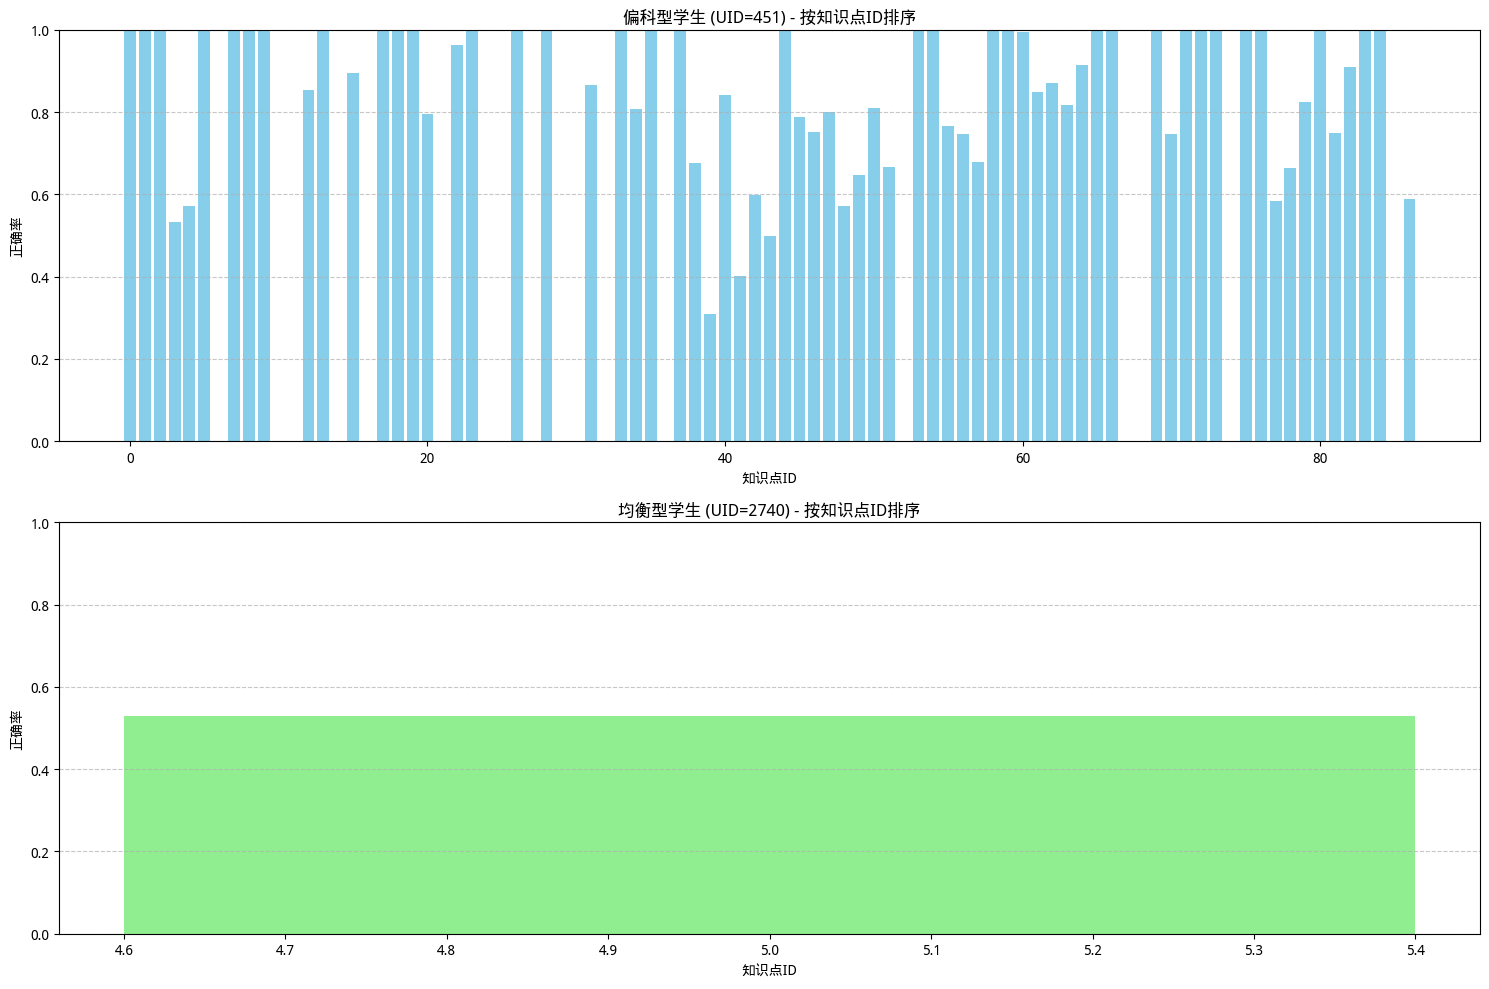

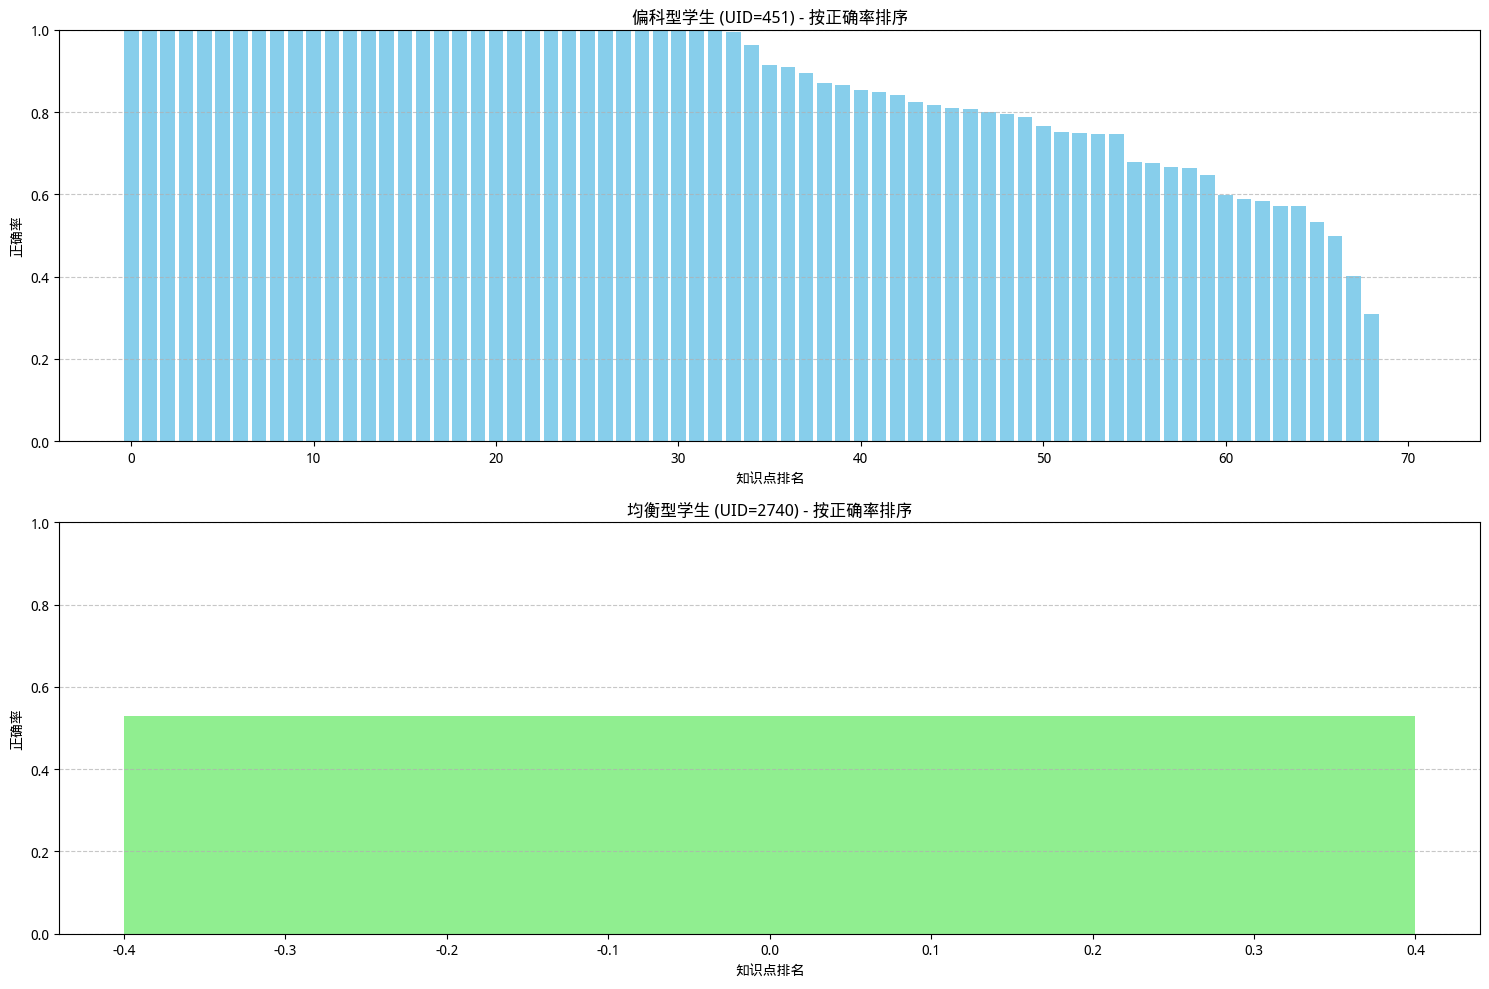

In [ ]:
import pandas as pd
import numpy as np
from typing import Tuple
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
# 设置支持中文的字体中文字体支持
try:
    # 尝试使用系统中已有的中文字体
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'WenQuanYi Micro Hei', 'sans-serif']
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
    print("已设置中文字体支持")
except:
    print("警告：无法设置中文字体，图表中的中文可能无法正确显示")

# 新增函数：获取学生知识点正确率
def get_student_concept_accuracies(uid_data: pd.DataFrame, min_records=15):
    """获取单个学生每个知识点的正确率"""
    all_concepts = []
    all_responses = []
    
    for _, row in uid_data.iterrows():
        concepts = [int(x) for x in row['concepts'].split(',')]
        responses = [int(x) for x in row['responses'].split(',')]
        
        valid_pairs = [(c, r) for c, r in zip(concepts, responses) if c != -1 and r != -1]
        if valid_pairs:
            valid_concepts, valid_responses = zip(*valid_pairs)
            all_concepts.extend(valid_concepts)
            all_responses.extend(valid_responses)
    
    if not all_concepts:
        return {}
    
    concept_stats = {}
    for concept, response in zip(all_concepts, all_responses):
        if concept not in concept_stats:
            concept_stats[concept] = {'correct': 0, 'total': 0}
        concept_stats[concept]['total'] += 1
        if response == 1:
            concept_stats[concept]['correct'] += 1
    
    # 过滤记录数不足的知识点
    concept_accuracies = {}
    for concept, stats in concept_stats.items():
        if stats['total'] > min_records:
            accuracy = stats['correct'] / stats['total']
            concept_accuracies[concept] = accuracy
    
    return concept_accuracies

# 修改后的主函数


def calculate_student_variance(uid_data: pd.DataFrame) -> Tuple[float, float]:
    """计算单个学生的知识点正确率差值及平均知识点记录数"""
    all_concepts = []
    all_responses = []
    
    for _, row in uid_data.iterrows():
        concepts = [int(x) for x in row['concepts'].split(',')]
        responses = [int(x) for x in row['responses'].split(',')]
        
        valid_pairs = [(c, r) for c, r in zip(concepts, responses) if c != -1 and r != -1]
        if valid_pairs:
            valid_concepts, valid_responses = zip(*valid_pairs)
            all_concepts.extend(valid_concepts)
            all_responses.extend(valid_responses)
    
    if not all_concepts:
        return 0.0, 0.0
    
    concept_stats = {}
    for concept, response in zip(all_concepts, all_responses):
        if concept not in concept_stats:
            concept_stats[concept] = {'correct': 0, 'total': 0}
        concept_stats[concept]['total'] += 1
        if response == 1:
            concept_stats[concept]['correct'] += 1
    
    valid_concept_accuracies = []
    valid_concept_nums_sum = 0
    valid_concept_nums = 0

    for concept, stats in concept_stats.items():
        if stats['total'] > 知识点数量:
            accuracy = stats['correct'] / stats['total']
            valid_concept_accuracies.append((concept, accuracy))
            valid_concept_nums_sum += stats['total']
            valid_concept_nums += 1
    
    if not valid_concept_accuracies:
        return 0.0, 0.0
    
    if len(valid_concept_accuracies) == 1:
        return 0.0, valid_concept_nums_sum / valid_concept_nums
    
    valid_concept_accuracies.sort(key=lambda x: x[1], reverse=True)
    valid_concept_average_num = valid_concept_nums_sum / valid_concept_nums
    
    n_concepts = len(valid_concept_accuracies)
    n_top = 1
    n_bottom = 1
    
    top_accuracies = [acc for _, acc in valid_concept_accuracies[:n_top]]
    bottom_accuracies = [acc for _, acc in valid_concept_accuracies[-n_bottom:]]
    
    avg_top = sum(top_accuracies) / len(top_accuracies)
    avg_bottom = sum(bottom_accuracies) / len(bottom_accuracies)
    
    variance = avg_top - avg_bottom
    
    return variance, valid_concept_average_num

def classify_students_by_variance(df: pd.DataFrame, aaa: float = 0.2) -> pd.DataFrame:
    """根据正确率差值将学生分类，按记录比例划分偏科/均衡/普通型"""
    # 计算每个学生的方差和记录数
    student_info = {}
    for uid, group in df.groupby('uid'):
        variance, valid_concept_average_num = calculate_student_variance(group)
        record_count = len(group)
        student_info[uid] = {
            'variance': variance,
            'record_count': record_count,
            'valid_concept_average_num': valid_concept_average_num
        }
    
    # 创建学生DataFrame并按方差降序排序
    student_df = pd.DataFrame.from_dict(student_info, orient='index')
    student_df.reset_index(inplace=True)
    student_df.columns = ['uid', 'variance', 'record_count', 'valid_concept_average_num']
    student_df = student_df.sort_values('variance', ascending=False)
    
    total_records = student_df['record_count'].sum()
    target_biased = total_records * aaa  # 偏科型目标记录数
    target_balanced = total_records * aaa  # 均衡型目标记录数
    
    # 初始化分类列
    student_df['student_type'] = '普通型'  # 默认设为普通型
    
    # Step 1: 标记偏科型（方差最大的前aaa比例记录）
    cumulative_records = 0
    for idx, row in student_df.iterrows():
        if cumulative_records < target_biased:
            student_df.at[idx, 'student_type'] = '偏科型'
            cumulative_records += row['record_count']
    
    # Step 2: 标记均衡型（方差最小的后aaa比例记录）
    # 获取尚未分类的学生（普通型），按方差升序排序
    normal_students = student_df[student_df['student_type'] == '普通型'].copy()
    normal_students = normal_students.sort_values('variance', ascending=True)
    
    cumulative_records = 0
    for idx, row in normal_students.iterrows():
        if cumulative_records < target_balanced:
            student_df.at[idx, 'student_type'] = '均衡型'
            cumulative_records += row['record_count']
    
    # Step 3: 映射回原始DataFrame
    type_mapping = student_df.set_index('uid')['student_type'].to_dict()
    variance_mapping = student_df.set_index('uid')['variance'].to_dict()
    avg_num_mapping = student_df.set_index('uid')['valid_concept_average_num'].to_dict()
    
    df['variance'] = df['uid'].map(variance_mapping)
    df['student_type'] = df['uid'].map(type_mapping)
    df['valid_concept_average_num'] = df['uid'].map(avg_num_mapping)
    
    return df

def main(input_csv_path: str, output_dir: str = './'):
    """主函数：处理数据并添加统计信息"""
    print("正在读取CSV文件...")
    df = pd.read_csv(input_csv_path)
    print(f"共读取到 {len(df)} 条记录")
    print(f"共有 {df['uid'].nunique()} 个不同的学生")
    
    print("\n正在计算学生知识点掌握差异度...")
    df_classified = classify_students_by_variance(df, 0.1)
    
    student_summary = df_classified[['uid', 'student_type', 'variance', 'valid_concept_average_num']].drop_duplicates()
    
    # 找出偏科型中差值最大的学生
    biased_students = student_summary[student_summary['student_type'] == '偏科型']
    if not biased_students.empty:
        top_biased_student = biased_students.iloc[0]['uid']
        print(f"\n偏科型中差值最大的学生: UID={top_biased_student}, 差值={biased_students.iloc[0]['variance']:.3f}")
    else:
        top_biased_student = None
    
    # 找出均衡型中差值最小的学生
    balanced_students = student_summary[student_summary['student_type'] == '均衡型']
    if not balanced_students.empty:
        # 按方差升序排序取第一个
        balanced_students_sorted = balanced_students.sort_values('variance')
        bottom_balanced_student = balanced_students_sorted.iloc[0]['uid']
        print(f"均衡型中差值最小的学生: UID={bottom_balanced_student}, 差值={balanced_students_sorted.iloc[0]['variance']:.3f}")
    else:
        bottom_balanced_student = None
    
    # 可视化部分
    if top_biased_student or bottom_balanced_student:
        print("\n正在生成可视化图表...")
        
        # 创建输出目录
        import os
        os.makedirs(output_dir, exist_ok=True)
        
        # 获取学生数据
        biased_data = df_classified[df_classified['uid'] == top_biased_student] if top_biased_student else None
        balanced_data = df_classified[df_classified['uid'] == bottom_balanced_student] if bottom_balanced_student else None
        
        # 获取知识点正确率
        biased_acc = get_student_concept_accuracies(biased_data, 15) if biased_data is not None else {}
        balanced_acc = get_student_concept_accuracies(balanced_data, 15) if balanced_data is not None else {}
        
        # 图1：按知识点ID排序
        plt.figure(figsize=(15, 10))
        
        if biased_acc:
            # 偏科型学生知识点正确率（按ID排序）
            plt.subplot(2, 1, 1)
            concepts = sorted(biased_acc.keys())
            accuracies = [biased_acc[c] for c in concepts]
            plt.bar(concepts, accuracies, color='skyblue')
            plt.title(f'偏科型学生 (UID={top_biased_student}) - 按知识点ID排序')
            plt.xlabel('知识点ID')
            plt.ylabel('正确率')
            plt.ylim(0, 1)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        if balanced_acc:
            # 均衡型学生知识点正确率（按ID排序）
            plt.subplot(2, 1, 2)
            concepts = sorted(balanced_acc.keys())
            accuracies = [balanced_acc[c] for c in concepts]
            plt.bar(concepts, accuracies, color='lightgreen')
            plt.title(f'均衡型学生 (UID={bottom_balanced_student}) - 按知识点ID排序')
            plt.xlabel('知识点ID')
            plt.ylabel('正确率')
            plt.ylim(0, 1)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        plt.savefig(f"{output_dir}/concept_accuracy_by_id.png")
        print("已保存图表: concept_accuracy_by_id.png")
        
        # 图2：按正确率排序
        plt.figure(figsize=(15, 10))
        
        if biased_acc:
            # 偏科型学生知识点正确率（按正确率排序）
            plt.subplot(2, 1, 1)
            sorted_items = sorted(biased_acc.items(), key=lambda x: x[1], reverse=True)
            concepts = [item[0] for item in sorted_items]
            accuracies = [item[1] for item in sorted_items]
            plt.bar(range(len(accuracies)), accuracies, color='skyblue')
            plt.title(f'偏科型学生 (UID={top_biased_student}) - 按正确率排序')
            plt.xlabel('知识点排名')
            plt.ylabel('正确率')
            plt.ylim(0, 1)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        if balanced_acc:
            # 均衡型学生知识点正确率（按正确率排序）
            plt.subplot(2, 1, 2)
            sorted_items = sorted(balanced_acc.items(), key=lambda x: x[1], reverse=True)
            concepts = [item[0] for item in sorted_items]
            accuracies = [item[1] for item in sorted_items]
            plt.bar(range(len(accuracies)), accuracies, color='lightgreen')
            plt.title(f'均衡型学生 (UID={bottom_balanced_student}) - 按正确率排序')
            plt.xlabel('知识点排名')
            plt.ylabel('正确率')
            plt.ylim(0, 1)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        plt.savefig(f"{output_dir}/concept_accuracy_sorted.png")
        print("已保存图表: concept_accuracy_sorted.png")

    """主函数：处理数据并添加统计信息"""
    print("正在读取CSV文件...")
    df = pd.read_csv(input_csv_path)
    print(f"共读取到 {len(df)} 条记录")
    print(f"共有 {df['uid'].nunique()} 个不同的学生")
    
    print("\n正在计算学生知识点掌握差异度...")
    df_classified = classify_students_by_variance(df,取值比例)
    
    student_summary = df_classified[['uid', 'student_type', 'variance', 'valid_concept_average_num']].drop_duplicates()
    
    record_counts = df_classified['student_type'].value_counts()
    total_records = len(df_classified)
    student_counts = student_summary['student_type'].value_counts()
    
    print("\n分类结果统计:")
    print(f"总记录数: {total_records}")
    print(f"总学生数: {len(student_summary)}")
    
    for student_type in ['偏科型', '普通型', '均衡型']:
        if student_type in record_counts.index:
            record_count = record_counts[student_type]
            student_count = student_counts[student_type]
            avg_concept_num = student_summary[student_summary['student_type'] == student_type]['valid_concept_average_num'].mean()
            
            print(f"\n  {student_type}:")
            print(f"    记录数: {record_count} ({record_count/total_records:.1%})")
            print(f"    学生数: {student_count} ({student_count/len(student_summary):.1%})")
            print(f"    平均知识点记录数: {avg_concept_num:.2f}")
            
            type_variances = student_summary[student_summary['student_type'] == student_type]['variance']
            if len(type_variances) > 0:
                print(f"    差值范围: {type_variances.min():.3f} - {type_variances.max():.3f}")
                print(f"    平均差值: {type_variances.mean():.3f}")
    
    specialized_students = df_classified[df_classified['student_type'] == '偏科型'].copy()
    normal_students = df_classified[df_classified['student_type'] == '普通型'].copy()
    balanced_students = df_classified[df_classified['student_type'] == '均衡型'].copy()
    
    for df_subset in [specialized_students, normal_students, balanced_students]:
        df_subset.drop(['student_type', 'variance', 'valid_concept_average_num'], axis=1, inplace=True)
    
    specialized_output_path = f"{output_dir}/pk.csv"
    normal_output_path = f"{output_dir}/pt.csv"
    balanced_output_path = f"{output_dir}/ph.csv"
    
    specialized_students.to_csv(specialized_output_path, index=False)
    normal_students.to_csv(normal_output_path, index=False)
    balanced_students.to_csv(balanced_output_path, index=False)
    
    print("\n数据保存详情:")
    print(f"偏科型 | 文件: {specialized_output_path} | 记录数: {len(specialized_students)} | 学生数: {specialized_students['uid'].nunique()}")
    print(f"普通型 | 文件: {normal_output_path} | 记录数: {len(normal_students)} | 学生数: {normal_students['uid'].nunique()}")
    print(f"均衡型 | 文件: {balanced_output_path} | 记录数: {len(balanced_students)} | 学生数: {balanced_students['uid'].nunique()}")
取值比例 = 0.1
知识点数量 = 15
if __name__ == "__main__":
    dataset = "assist2009"
    input_file = f"/root/autodl-tmp/pykt_self_version/data/{dataset}/test_question_window_sequences.csv"
    output_directory = f"/root/autodl-tmp/pykt_self_version/data/{dataset}/"
    main(input_file, output_directory)
    # print("\n处理完成！")

## 差值加权重

In [ ]:
import pandas as pd
import numpy as np
from typing import Tuple, List, Dict
题目数量 = 5
def calculate_student_variance(uid_data: pd.DataFrame) -> float:
    """
    计算单个学生的知识点正确率差值
    使用前20%高正确率知识点和后20%低正确率知识点的平均正确率差值
    并根据知识点数量赋予权重
    
    参数:
        uid_data: 包含同一个uid所有记录的DataFrame
    
    返回:
        float: 加权后的差值，如果没有符合条件的知识点返回0
    """
    # 合并所有行的数据
    all_concepts = []
    all_responses = []
    
    for _, row in uid_data.iterrows():
        concepts = [int(x) for x in row['concepts'].split(',')]
        responses = [int(x) for x in row['responses'].split(',')]
        
        # 过滤掉填充值-1
        valid_pairs = [(c, r) for c, r in zip(concepts, responses) if c != -1 and r != -1]
        if valid_pairs:
            valid_concepts, valid_responses = zip(*valid_pairs)
            all_concepts.extend(valid_concepts)
            all_responses.extend(valid_responses)
    
    if not all_concepts:
        return 0.0
    
    # 统计每个概念的正确率和题量
    concept_stats = {}
    for concept, response in zip(all_concepts, all_responses):
        if concept not in concept_stats:
            concept_stats[concept] = {'correct': 0, 'total': 0}
        
        concept_stats[concept]['total'] += 1
        if response == 1:
            concept_stats[concept]['correct'] += 1
    
    # 只考虑做题数量>5的知识点
    valid_concept_accuracies = []
    for concept, stats in concept_stats.items():
        if stats['total'] > 题目数量:  # 题量大于题目数量
            accuracy = stats['correct'] / stats['total']
            valid_concept_accuracies.append((concept, accuracy))
    
    # 如果没有符合条件的知识点，返回0
    if not valid_concept_accuracies:
        return 0.0
    
    # 如果只有一个知识点，差值为0
    if len(valid_concept_accuracies) == 1:
        return 0.0
    
    # 按正确率排序
    valid_concept_accuracies.sort(key=lambda x: x[1], reverse=True)
    
    # 计算前20%和后20%的数量
    n_concepts = len(valid_concept_accuracies)
    # n_top = max(1, int(n_concepts * 0.2))  # 至少取1个
    # n_bottom = max(1, int(n_concepts * 0.2))  # 至少取1个
    n_top = 1
    n_bottom = 1
    # 获取前20%的知识点正确率
    top_accuracies = [acc for _, acc in valid_concept_accuracies[:n_top]]
    # 获取后20%的知识点正确率
    bottom_accuracies = [acc for _, acc in valid_concept_accuracies[-n_bottom:]]
    
    # 计算平均值
    avg_top = sum(top_accuracies) / len(top_accuracies)
    avg_bottom = sum(bottom_accuracies) / len(bottom_accuracies)
    
    # 计算原始差值
    raw_variance = avg_top - avg_bottom
    
    # 计算权重：知识点数量越多，权重越大
    # 使用对数函数使权重增长更平滑
    # 权重范围：[0.5, 1.5]
    if n_concepts <= 3:
        weight = 0.5  # 知识点很少时，权重较低
    elif n_concepts <= 5:
        weight = 0.7
    elif n_concepts <= 10:
        weight = 0.9
    elif n_concepts <= 20:
        weight = 1.0
    elif n_concepts <= 30:
        weight = 1.1
    elif n_concepts <= 50:
        weight = 1.2
    else:
        weight = 1.3 + 0.1 * np.log10(n_concepts / 50)  # 超过50个知识点后，权重继续缓慢增长
        weight = min(weight, 1.5)  # 权重上限为1.5
    
    # 返回加权后的差值
    weighted_variance = raw_variance * weight
    
    return weighted_variance

def classify_students_by_variance(df: pd.DataFrame) -> pd.DataFrame:
    """
    根据正确率差值将学生分为三类，按记录数均衡分配
    前33%记录为偏科型，后33%记录为均衡型，中间为普通型
    
    参数:
        df: 原始数据DataFrame
    
    返回:
        pd.DataFrame: 添加了分类标签的DataFrame
    """
    # 按uid分组计算每个学生的差值和记录数
    student_info = {}
    
    for uid, group in df.groupby('uid'):
        variance = calculate_student_variance(group)
        record_count = len(group)
        student_info[uid] = {
            'variance': variance,
            'record_count': record_count
        }
    
    # 创建学生级别的DataFrame
    student_df = pd.DataFrame.from_dict(student_info, orient='index')
    student_df.reset_index(inplace=True)
    student_df.columns = ['uid', 'variance', 'record_count']
    
    # 按差值降序排序（差值大的在前）
    student_df = student_df.sort_values('variance', ascending=False)
    
    # 计算总记录数
    total_records = student_df['record_count'].sum()
    target_per_group = total_records / 3
    
    # 贪心算法分配学生到三类
    student_df['student_type'] = ''
    cumulative_records = 0
    
    # 第一阶段：分配偏科型（前33%记录）
    for idx, row in student_df.iterrows():
        if cumulative_records < target_per_group:
            student_df.at[idx, 'student_type'] = '偏科型'
            cumulative_records += row['record_count']
        else:
            # 检查是否加入这个学生会更接近目标
            if abs(cumulative_records - target_per_group) > abs(cumulative_records + row['record_count'] - target_per_group):
                student_df.at[idx, 'student_type'] = '偏科型'
                cumulative_records += row['record_count']
            else:
                break
    
    # 第二阶段：分配普通型（中间33%记录）
    for idx, row in student_df.iterrows():
        if student_df.at[idx, 'student_type'] == '':
            if cumulative_records < 2 * target_per_group:
                student_df.at[idx, 'student_type'] = '普通型'
                cumulative_records += row['record_count']
            else:
                # 检查是否加入这个学生会更接近目标
                if abs(cumulative_records - 2 * target_per_group) > abs(cumulative_records + row['record_count'] - 2 * target_per_group):
                    student_df.at[idx, 'student_type'] = '普通型'
                    cumulative_records += row['record_count']
                else:
                    break
    
    # 第三阶段：剩余的都是均衡型
    student_df.loc[student_df['student_type'] == '', 'student_type'] = '均衡型'
    
    # 将分类结果合并回原始DataFrame
    type_mapping = dict(zip(student_df['uid'], student_df['student_type']))
    variance_mapping = dict(zip(student_df['uid'], student_df['variance']))
    
    df['variance'] = df['uid'].map(variance_mapping)
    df['student_type'] = df['uid'].map(type_mapping)
    
    return df

def main(input_csv_path: str, output_dir: str = './'):
    """
    主函数：读取CSV文件，分类学生，保存结果
    
    参数:
        input_csv_path: 输入CSV文件路径
        output_dir: 输出目录路径
    """
    
    # 1. 读取CSV文件
    print("正在读取CSV文件...")
    df = pd.read_csv(input_csv_path)
    print(f"共读取到 {len(df)} 条记录")
    print(f"共有 {df['uid'].nunique()} 个不同的学生")
    
    # 2. 按差值分类学生
    print("\n正在计算学生知识点掌握差异度...")
    df_classified = classify_students_by_variance(df)
    
    # 3. 统计分类结果
    student_summary = df_classified[['uid', 'student_type', 'variance', 'valid_concept_average_num']].drop_duplicates()
    
    # 统计记录数
    record_counts = df_classified['student_type'].value_counts()
    total_records = len(df_classified)
    
    # 统计学生数
    student_counts = student_summary['student_type'].value_counts()
    
    print("\n分类结果统计:")
    print(f"总记录数: {total_records}")
    print(f"总学生数: {len(student_summary)}")
    
    for student_type in ['偏科型', '普通型', '均衡型']:
        if student_type in record_counts.index:
            record_count = record_counts[student_type]
            record_percentage = (record_count / total_records) * 100
            
            student_count = student_counts[student_type]
            student_percentage = (student_count / len(student_summary)) * 100
            
            print(f"\n  {student_type}:")
            print(f"    记录数: {record_count} ({record_percentage:.1f}%)")
            print(f"    学生数: {student_count} ({student_percentage:.1f}%)")
            
            # 计算并显示平均每个知识点的记录数
            avg_concept_num = student_summary[student_summary['student_type'] == student_type]['valid_concept_average_num'].mean()
            print(f"    平均每个知识点记录数: {avg_concept_num:.2f}")
            
            # 显示差值范围
            type_variances = student_summary[student_summary['student_type'] == student_type]['variance']
            if len(type_variances) > 0:
                print(f"    差值范围: {type_variances.min():.3f} - {type_variances.max():.3f}")
                print(f"    平均差值: {type_variances.mean():.3f}")
    
    # 4. 分别保存三类学生的数据
    specialized_students = df_classified[df_classified['student_type'] == '偏科型'].copy()
    normal_students = df_classified[df_classified['student_type'] == '普通型'].copy()
    balanced_students = df_classified[df_classified['student_type'] == '均衡型'].copy()
    
    # 移除临时列
    for df_subset in [specialized_students, normal_students, balanced_students]:
        df_subset.drop(['student_type', 'variance'], axis=1, inplace=True)
    
    # 5. 保存为新的CSV文件
    specialized_output_path = f"{output_dir}/pk1.csv"
    normal_output_path = f"{output_dir}/pt1.csv"
    balanced_output_path = f"{output_dir}/ph1.csv"
    
    specialized_students.to_csv(specialized_output_path, index=False)
    normal_students.to_csv(normal_output_path, index=False)
    balanced_students.to_csv(balanced_output_path, index=False)
    
    avg_specialized = student_summary[student_summary['student_type'] == '偏科型']['valid_concept_average_num'].mean()
    avg_normal = student_summary[student_summary['student_type'] == '普通型']['valid_concept_average_num'].mean()
    avg_balanced = student_summary[student_summary['student_type'] == '均衡型']['valid_concept_average_num'].mean()
    
    print(f"\n数据已保存:")
    print(f"偏科型学生数据: {specialized_output_path} ({len(specialized_students)} 条记录, {specialized_students['uid'].nunique()} 个学生), 平均每个知识点记录数: {avg_specialized:.2f}")
    print(f"普通型学生数据: {normal_output_path} ({len(normal_students)} 条记录, {normal_students['uid'].nunique()} 个学生), 平均每个知识点记录数: {avg_normal:.2f}")
    print(f"均衡型学生数据: {balanced_output_path} ({len(balanced_students)} 条记录, {balanced_students['uid'].nunique()} 个学生), 平均每个知识点记录数: {avg_balanced:.2f}")

    # 6. 显示一些示例
    print("\n示例分析:")
    # 显示差值最大的学生
    top_students = student_summary.nlargest(3, 'variance')
    print("加权差值最大的3个学生:")
    for idx, student in top_students.iterrows():
        # 获取该学生的知识点数量
        student_data = df_classified[df_classified['uid'] == student['uid']]
        all_concepts = []
        for _, row in student_data.iterrows():
            concepts = [int(x) for x in row['concepts'].split(',') if int(x) != -1]
            all_concepts.extend(concepts)
        unique_concepts = len(set(all_concepts))
        
        print(f"  UID={student['uid']}, 加权差值={student['variance']:.3f}, "
              f"类型={student['student_type']}, 知识点数={unique_concepts}")
    
    # 显示差值最小的学生
    bottom_students = student_summary.nsmallest(3, 'variance')
    print("\n加权差值最小的3个学生:")
    for idx, student in bottom_students.iterrows():
        print(f"  UID={student['uid']}, 加权差值={student['variance']:.3f}, 类型={student['student_type']}")
    
    # 显示差值分布信息
    print(f"\n加权差值分布统计:")
    print(f"最小值: {student_summary['variance'].min():.3f}")
    print(f"25%分位数: {student_summary['variance'].quantile(0.25):.3f}")
    print(f"中位数: {student_summary['variance'].median():.3f}")
    print(f"75%分位数: {student_summary['variance'].quantile(0.75):.3f}")
    print(f"最大值: {student_summary['variance'].max():.3f}")
    print(f"标准差: {student_summary['variance'].std():.3f}")
    
    return specialized_students, normal_students, balanced_students

# 使用示例
if __name__ == "__main__":
    # 指定输入文件路径
    input_file = "/root/autodl-tmp/pykt_self_version/data/assist2009/test_question_window_sequences.csv"
    output_directory = "/root/autodl-tmp/pykt_self_version/data/assist2009/"
    
    # 执行分类和保存
    specialized_df, normal_df, balanced_df = main(input_file, output_directory)
    
    print("\n处理完成！")

## 标准差

In [ ]:
import pandas as pd
import numpy as np
from typing import Tuple, List, Dict

def calculate_student_variance(uid_data: pd.DataFrame) -> float:
    """
    计算单个学生的知识点正确率标准差
    只考虑做题数量>5的知识点，计算这些知识点正确率的标准差
    
    参数:
        uid_data: 包含同一个uid所有记录的DataFrame
    
    返回:
        float: 知识点正确率的标准差，如果没有符合条件的知识点返回0
    """
    # 合并所有行的数据
    all_concepts = []
    all_responses = []
    
    for _, row in uid_data.iterrows():
        concepts = [int(x) for x in row['concepts'].split(',')]
        responses = [int(x) for x in row['responses'].split(',')]
        
        # 过滤掉填充值-1
        valid_pairs = [(c, r) for c, r in zip(concepts, responses) if c != -1 and r != -1]
        if valid_pairs:
            valid_concepts, valid_responses = zip(*valid_pairs)
            all_concepts.extend(valid_concepts)
            all_responses.extend(valid_responses)
    
    if not all_concepts:
        return 0.0
    
    # 统计每个概念的正确率和题量
    concept_stats = {}
    for concept, response in zip(all_concepts, all_responses):
        if concept not in concept_stats:
            concept_stats[concept] = {'correct': 0, 'total': 0}
        
        concept_stats[concept]['total'] += 1
        if response == 1:
            concept_stats[concept]['correct'] += 1
    
    # 只考虑做题数量>5的知识点
    valid_accuracies = []
    for concept, stats in concept_stats.items():
        if stats['total'] > 5:  # 题量大于5
            accuracy = stats['correct'] / stats['total']
            valid_accuracies.append(accuracy)
    
    # 如果没有符合条件的知识点，返回0
    if not valid_accuracies:
        return 0.0
    
    # 如果只有一个知识点，标准差为0
    if len(valid_accuracies) == 1:
        return 0.0
    
    # 计算标准差
    std_dev = np.std(valid_accuracies, ddof=1)  # 使用样本标准差（ddof=1）
    
    return std_dev

def classify_students_by_variance(df: pd.DataFrame) -> pd.DataFrame:
    """
    根据正确率标准差将学生分为三类，按记录数均衡分配
    前33%记录为偏科型（标准差大），后33%记录为均衡型（标准差小），中间为普通型
    
    参数:
        df: 原始数据DataFrame
    
    返回:
        pd.DataFrame: 添加了分类标签的DataFrame
    """
    # 按uid分组计算每个学生的标准差和记录数
    student_info = {}
    
    for uid, group in df.groupby('uid'):
        std_dev = calculate_student_variance(group)
        record_count = len(group)
        student_info[uid] = {
            'std_dev': std_dev,
            'record_count': record_count
        }
    
    # 创建学生级别的DataFrame
    student_df = pd.DataFrame.from_dict(student_info, orient='index')
    student_df.reset_index(inplace=True)
    student_df.columns = ['uid', 'std_dev', 'record_count']
    
    # 按标准差降序排序（标准差大的在前）
    student_df = student_df.sort_values('std_dev', ascending=False)
    
    # 计算总记录数
    total_records = student_df['record_count'].sum()
    target_per_group = total_records / 3
    
    # 贪心算法分配学生到三类
    student_df['student_type'] = ''
    cumulative_records = 0
    
    # 第一阶段：分配偏科型（前33%记录，标准差大）
    for idx, row in student_df.iterrows():
        if cumulative_records < target_per_group:
            student_df.at[idx, 'student_type'] = '偏科型'
            cumulative_records += row['record_count']
        else:
            # 检查是否加入这个学生会更接近目标
            if abs(cumulative_records - target_per_group) > abs(cumulative_records + row['record_count'] - target_per_group):
                student_df.at[idx, 'student_type'] = '偏科型'
                cumulative_records += row['record_count']
            else:
                break
    
    # 第二阶段：分配普通型（中间33%记录）
    for idx, row in student_df.iterrows():
        if student_df.at[idx, 'student_type'] == '':
            if cumulative_records < 2 * target_per_group:
                student_df.at[idx, 'student_type'] = '普通型'
                cumulative_records += row['record_count']
            else:
                # 检查是否加入这个学生会更接近目标
                if abs(cumulative_records - 2 * target_per_group) > abs(cumulative_records + row['record_count'] - 2 * target_per_group):
                    student_df.at[idx, 'student_type'] = '普通型'
                    cumulative_records += row['record_count']
                else:
                    break
    
    # 第三阶段：剩余的都是均衡型（标准差小）
    student_df.loc[student_df['student_type'] == '', 'student_type'] = '均衡型'
    
    # 将分类结果合并回原始DataFrame
    type_mapping = dict(zip(student_df['uid'], student_df['student_type']))
    variance_mapping = dict(zip(student_df['uid'], student_df['std_dev']))
    
    df['variance'] = df['uid'].map(variance_mapping)
    df['student_type'] = df['uid'].map(type_mapping)
    
    return df

def main(input_csv_path: str, output_dir: str = './'):
    """
    主函数：读取CSV文件，分类学生，保存结果
    
    参数:
        input_csv_path: 输入CSV文件路径
        output_dir: 输出目录路径
    """
    
    # 1. 读取CSV文件
    print("正在读取CSV文件...")
    df = pd.read_csv(input_csv_path)
    print(f"共读取到 {len(df)} 条记录")
    print(f"共有 {df['uid'].nunique()} 个不同的学生")
    
    # 2. 按差值分类学生
    print("\n正在计算学生知识点掌握标准差...")
    df_classified = classify_students_by_variance(df)
    
    # 3. 统计分类结果
    student_summary = df_classified[['uid', 'student_type', 'variance']].drop_duplicates()
    
    # 统计记录数
    record_counts = df_classified['student_type'].value_counts()
    total_records = len(df_classified)
    
    # 统计学生数
    student_counts = student_summary['student_type'].value_counts()
    
    print("\n分类结果统计:")
    print(f"总记录数: {total_records}")
    print(f"总学生数: {len(student_summary)}")
    
    for student_type in ['偏科型', '普通型', '均衡型']:
        if student_type in record_counts.index:
            record_count = record_counts[student_type]
            record_percentage = (record_count / total_records) * 100
            
            student_count = student_counts[student_type]
            student_percentage = (student_count / len(student_summary)) * 100
            
            print(f"\n  {student_type}:")
            print(f"    记录数: {record_count} ({record_percentage:.1f}%)")
            print(f"    学生数: {student_count} ({student_percentage:.1f}%)")
            
            # 显示该类型学生的标准差范围
            type_variances = student_summary[student_summary['student_type'] == student_type]['variance']
            if len(type_variances) > 0:
                print(f"    标准差范围: {type_variances.min():.3f} - {type_variances.max():.3f}")
                print(f"    平均标准差: {type_variances.mean():.3f}")
    
    # 4. 分别保存三类学生的数据
    specialized_students = df_classified[df_classified['student_type'] == '偏科型'].copy()
    normal_students = df_classified[df_classified['student_type'] == '普通型'].copy()
    balanced_students = df_classified[df_classified['student_type'] == '均衡型'].copy()
    
    # 移除临时列
    for df_subset in [specialized_students, normal_students, balanced_students]:
        df_subset.drop(['student_type', 'variance'], axis=1, inplace=True)
    
    # 5. 保存为新的CSV文件
    specialized_output_path = f"{output_dir}/pk2.csv"
    normal_output_path = f"{output_dir}/pt2.csv"
    balanced_output_path = f"{output_dir}/ph2.csv"
    
    specialized_students.to_csv(specialized_output_path, index=False)
    normal_students.to_csv(normal_output_path, index=False)
    balanced_students.to_csv(balanced_output_path, index=False)
    
    print(f"\n数据已保存:")
    print(f"偏科型学生数据: {specialized_output_path} ({len(specialized_students)} 条记录, {specialized_students['uid'].nunique()} 个学生)")
    print(f"普通型学生数据: {normal_output_path} ({len(normal_students)} 条记录, {normal_students['uid'].nunique()} 个学生)")
    print(f"均衡型学生数据: {balanced_output_path} ({len(balanced_students)} 条记录, {balanced_students['uid'].nunique()} 个学生)")
    
    # 6. 显示一些示例
    print("\n示例分析:")
    # 显示标准差最大的学生
    top_students = student_summary.nlargest(3, 'variance')
    print("标准差最大的3个学生（偏科程度高）:")
    for idx, student in top_students.iterrows():
        # 获取该学生的知识点数量和正确率分布
        student_data = df_classified[df_classified['uid'] == student['uid']]
        all_concepts = []
        all_responses = []
        for _, row in student_data.iterrows():
            concepts = [int(x) for x in row['concepts'].split(',')]
            responses = [int(x) for x in row['responses'].split(',')]
            valid_pairs = [(c, r) for c, r in zip(concepts, responses) if c != -1 and r != -1]
            if valid_pairs:
                all_concepts.extend([p[0] for p in valid_pairs])
                all_responses.extend([p[1] for p in valid_pairs])
        
        # 统计符合条件的知识点数
        concept_stats = {}
        for c, r in zip(all_concepts, all_responses):
            if c not in concept_stats:
                concept_stats[c] = {'correct': 0, 'total': 0}
            concept_stats[c]['total'] += 1
            if r == 1:
                concept_stats[c]['correct'] += 1
        
        valid_concepts = [c for c, stats in concept_stats.items() if stats['total'] > 5]
        
        print(f"  UID={student['uid']}, 标准差={student['variance']:.3f}, "
              f"类型={student['student_type']}, 有效知识点数={len(valid_concepts)}")
    
    # 显示标准差最小的学生
    bottom_students = student_summary.nsmallest(3, 'variance')
    print("\n标准差最小的3个学生（均衡程度高）:")
    for idx, student in bottom_students.iterrows():
        print(f"  UID={student['uid']}, 标准差={student['variance']:.3f}, 类型={student['student_type']}")
    
    # 显示标准差分布信息
    print(f"\n标准差分布统计:")
    print(f"最小值: {student_summary['variance'].min():.3f}")
    print(f"25%分位数: {student_summary['variance'].quantile(0.25):.3f}")
    print(f"中位数: {student_summary['variance'].median():.3f}")
    print(f"75%分位数: {student_summary['variance'].quantile(0.75):.3f}")
    print(f"最大值: {student_summary['variance'].max():.3f}")
    print(f"平均值: {student_summary['variance'].mean():.3f}")
    
    return specialized_students, normal_students, balanced_students

# 使用示例
if __name__ == "__main__":
    # 指定输入文件路径
    input_file = "/root/autodl-tmp/pykt_self_version/data/assist2009/test_question_window_sequences.csv"
    output_directory = "/root/autodl-tmp/pykt_self_version/data/assist2009/"
    
    # 执行分类和保存
    specialized_df, normal_df, balanced_df = main(input_file, output_directory)
    
    print("\n处理完成！")

## 加权标准差

In [ ]:
import pandas as pd
import numpy as np
from typing import Tuple, List, Dict

def calculate_student_variance(uid_data: pd.DataFrame) -> float:
    """
    计算单个学生的知识点正确率加权标准差
    只考虑做题数量>5的知识点，根据每个知识点的做题数量赋予权重
    
    参数:
        uid_data: 包含同一个uid所有记录的DataFrame
    
    返回:
        float: 知识点正确率的加权标准差，如果没有符合条件的知识点返回0
    """
    # 合并所有行的数据
    all_concepts = []
    all_responses = []
    
    for _, row in uid_data.iterrows():
        concepts = [int(x) for x in row['concepts'].split(',')]
        responses = [int(x) for x in row['responses'].split(',')]
        
        # 过滤掉填充值-1
        valid_pairs = [(c, r) for c, r in zip(concepts, responses) if c != -1 and r != -1]
        if valid_pairs:
            valid_concepts, valid_responses = zip(*valid_pairs)
            all_concepts.extend(valid_concepts)
            all_responses.extend(valid_responses)
    
    if not all_concepts:
        return 0.0
    
    # 统计每个概念的正确率和题量
    concept_stats = {}
    for concept, response in zip(all_concepts, all_responses):
        if concept not in concept_stats:
            concept_stats[concept] = {'correct': 0, 'total': 0}
        
        concept_stats[concept]['total'] += 1
        if response == 1:
            concept_stats[concept]['correct'] += 1
    
    # 只考虑做题数量>5的知识点，同时记录权重
    valid_data = []  # [(accuracy, weight)]
    total_weight = 0
    
    for concept, stats in concept_stats.items():
        if stats['total'] > 5:  # 题量大于5
            accuracy = stats['correct'] / stats['total']
            # 权重：做题数量越多，权重越大（使用对数函数使权重增长更平滑）
            weight = np.log(stats['total'])  # 使用对数权重
            valid_data.append((accuracy, weight))
            total_weight += weight
    
    # 如果没有符合条件的知识点，返回0
    if not valid_data:
        return 0.0
    
    # 如果只有一个知识点，标准差为0
    if len(valid_data) == 1:
        return 0.0
    
    # 计算加权平均值
    weighted_mean = sum(acc * w for acc, w in valid_data) / total_weight
    
    # 计算加权方差
    weighted_variance = sum(w * (acc - weighted_mean) ** 2 for acc, w in valid_data) / total_weight
    
    # 计算加权标准差
    weighted_std = np.sqrt(weighted_variance)
    
    # 贝塞尔校正：对于样本标准差的修正
    # 使用类似于样本标准差的校正因子
    n = len(valid_data)
    correction_factor = np.sqrt(n / (n - 1)) if n > 1 else 1
    corrected_weighted_std = weighted_std * correction_factor
    
    return corrected_weighted_std

def classify_students_by_variance(df: pd.DataFrame) -> pd.DataFrame:
    """
    根据正确率加权标准差将学生分为三类，按记录数均衡分配
    前33%记录为偏科型（加权标准差大），后33%记录为均衡型（加权标准差小），中间为普通型
    
    参数:
        df: 原始数据DataFrame
    
    返回:
        pd.DataFrame: 添加了分类标签的DataFrame
    """
    # 按uid分组计算每个学生的加权标准差和记录数
    student_info = {}
    
    for uid, group in df.groupby('uid'):
        weighted_std = calculate_student_variance(group)
        record_count = len(group)
        student_info[uid] = {
            'weighted_std': weighted_std,
            'record_count': record_count
        }
    
    # 创建学生级别的DataFrame
    student_df = pd.DataFrame.from_dict(student_info, orient='index')
    student_df.reset_index(inplace=True)
    student_df.columns = ['uid', 'weighted_std', 'record_count']
    
    # 按加权标准差降序排序（加权标准差大的在前）
    student_df = student_df.sort_values('weighted_std', ascending=False)
    
    # 计算总记录数
    total_records = student_df['record_count'].sum()
    target_per_group = total_records / 3
    
    # 贪心算法分配学生到三类
    student_df['student_type'] = ''
    cumulative_records = 0
    
    # 第一阶段：分配偏科型（前33%记录，加权标准差大）
    for idx, row in student_df.iterrows():
        if cumulative_records < target_per_group:
            student_df.at[idx, 'student_type'] = '偏科型'
            cumulative_records += row['record_count']
        else:
            # 检查是否加入这个学生会更接近目标
            if abs(cumulative_records - target_per_group) > abs(cumulative_records + row['record_count'] - target_per_group):
                student_df.at[idx, 'student_type'] = '偏科型'
                cumulative_records += row['record_count']
            else:
                break
    
    # 第二阶段：分配普通型（中间33%记录）
    for idx, row in student_df.iterrows():
        if student_df.at[idx, 'student_type'] == '':
            if cumulative_records < 2 * target_per_group:
                student_df.at[idx, 'student_type'] = '普通型'
                cumulative_records += row['record_count']
            else:
                # 检查是否加入这个学生会更接近目标
                if abs(cumulative_records - 2 * target_per_group) > abs(cumulative_records + row['record_count'] - 2 * target_per_group):
                    student_df.at[idx, 'student_type'] = '普通型'
                    cumulative_records += row['record_count']
                else:
                    break
    
    # 第三阶段：剩余的都是均衡型（加权标准差小）
    student_df.loc[student_df['student_type'] == '', 'student_type'] = '均衡型'
    
    # 将分类结果合并回原始DataFrame
    type_mapping = dict(zip(student_df['uid'], student_df['student_type']))
    variance_mapping = dict(zip(student_df['uid'], student_df['weighted_std']))
    
    df['variance'] = df['uid'].map(variance_mapping)
    df['student_type'] = df['uid'].map(type_mapping)
    
    return df

def main(input_csv_path: str, output_dir: str = './'):
    """
    主函数：读取CSV文件，分类学生，保存结果
    
    参数:
        input_csv_path: 输入CSV文件路径
        output_dir: 输出目录路径
    """
    
    # 1. 读取CSV文件
    print("正在读取CSV文件...")
    df = pd.read_csv(input_csv_path)
    print(f"共读取到 {len(df)} 条记录")
    print(f"共有 {df['uid'].nunique()} 个不同的学生")
    
    # 2. 按差值分类学生
    print("\n正在计算学生知识点掌握加权标准差...")
    df_classified = classify_students_by_variance(df)
    
    # 3. 统计分类结果
    student_summary = df_classified[['uid', 'student_type', 'variance']].drop_duplicates()
    
    # 统计记录数
    record_counts = df_classified['student_type'].value_counts()
    total_records = len(df_classified)
    
    # 统计学生数
    student_counts = student_summary['student_type'].value_counts()
    
    print("\n分类结果统计:")
    print(f"总记录数: {total_records}")
    print(f"总学生数: {len(student_summary)}")
    
    for student_type in ['偏科型', '普通型', '均衡型']:
        if student_type in record_counts.index:
            record_count = record_counts[student_type]
            record_percentage = (record_count / total_records) * 100
            
            student_count = student_counts[student_type]
            student_percentage = (student_count / len(student_summary)) * 100
            
            print(f"\n  {student_type}:")
            print(f"    记录数: {record_count} ({record_percentage:.1f}%)")
            print(f"    学生数: {student_count} ({student_percentage:.1f}%)")
            
            # 显示该类型学生的加权标准差范围
            type_variances = student_summary[student_summary['student_type'] == student_type]['variance']
            if len(type_variances) > 0:
                print(f"    加权标准差范围: {type_variances.min():.3f} - {type_variances.max():.3f}")
                print(f"    平均加权标准差: {type_variances.mean():.3f}")
    
    # 4. 分别保存三类学生的数据
    specialized_students = df_classified[df_classified['student_type'] == '偏科型'].copy()
    normal_students = df_classified[df_classified['student_type'] == '普通型'].copy()
    balanced_students = df_classified[df_classified['student_type'] == '均衡型'].copy()
    
    # 移除临时列
    for df_subset in [specialized_students, normal_students, balanced_students]:
        df_subset.drop(['student_type', 'variance'], axis=1, inplace=True)
    
    # 5. 保存为新的CSV文件
    specialized_output_path = f"{output_dir}/pk3.csv"
    normal_output_path = f"{output_dir}/pt3.csv"
    balanced_output_path = f"{output_dir}/ph3.csv"
    
    specialized_students.to_csv(specialized_output_path, index=False)
    normal_students.to_csv(normal_output_path, index=False)
    balanced_students.to_csv(balanced_output_path, index=False)
    
    print(f"\n数据已保存:")
    print(f"偏科型学生数据: {specialized_output_path} ({len(specialized_students)} 条记录, {specialized_students['uid'].nunique()} 个学生)")
    print(f"普通型学生数据: {normal_output_path} ({len(normal_students)} 条记录, {normal_students['uid'].nunique()} 个学生)")
    print(f"均衡型学生数据: {balanced_output_path} ({len(balanced_students)} 条记录, {balanced_students['uid'].nunique()} 个学生)")
    
    # 6. 显示一些示例
    print("\n示例分析:")
    # 显示加权标准差最大的学生
    top_students = student_summary.nlargest(3, 'variance')
    print("加权标准差最大的3个学生（偏科程度高）:")
    for idx, student in top_students.iterrows():
        # 获取该学生的知识点数量和正确率分布
        student_data = df_classified[df_classified['uid'] == student['uid']]
        all_concepts = []
        all_responses = []
        for _, row in student_data.iterrows():
            concepts = [int(x) for x in row['concepts'].split(',')]
            responses = [int(x) for x in row['responses'].split(',')]
            valid_pairs = [(c, r) for c, r in zip(concepts, responses) if c != -1 and r != -1]
            if valid_pairs:
                all_concepts.extend([p[0] for p in valid_pairs])
                all_responses.extend([p[1] for p in valid_pairs])
        
        # 统计符合条件的知识点数和总题量
        concept_stats = {}
        for c, r in zip(all_concepts, all_responses):
            if c not in concept_stats:
                concept_stats[c] = {'correct': 0, 'total': 0}
            concept_stats[c]['total'] += 1
            if r == 1:
                concept_stats[c]['correct'] += 1
        
        valid_concepts = [(c, stats) for c, stats in concept_stats.items() if stats['total'] > 5]
        total_questions = sum(stats['total'] for _, stats in valid_concepts)
        
        print(f"  UID={student['uid']}, 加权标准差={student['variance']:.3f}, "
              f"类型={student['student_type']}, 有效知识点数={len(valid_concepts)}, "
              f"总题量={total_questions}")
    
    # 显示加权标准差最小的学生
    bottom_students = student_summary.nsmallest(3, 'variance')
    print("\n加权标准差最小的3个学生（均衡程度高）:")
    for idx, student in bottom_students.iterrows():
        print(f"  UID={student['uid']}, 加权标准差={student['variance']:.3f}, 类型={student['student_type']}")
    
    # 显示加权标准差分布信息
    print(f"\n加权标准差分布统计:")
    print(f"最小值: {student_summary['variance'].min():.3f}")
    print(f"25%分位数: {student_summary['variance'].quantile(0.25):.3f}")
    print(f"中位数: {student_summary['variance'].median():.3f}")
    print(f"75%分位数: {student_summary['variance'].quantile(0.75):.3f}")
    print(f"最大值: {student_summary['variance'].max():.3f}")
    print(f"平均值: {student_summary['variance'].mean():.3f}")
    
    return specialized_students, normal_students, balanced_students

# 使用示例
if __name__ == "__main__":
    # 指定输入文件路径
    input_file = "/root/autodl-tmp/pykt_self_version/data/assist2009/test_question_window_sequences.csv"
    output_directory = "/root/autodl-tmp/pykt_self_version/data/assist2009/"
    
    # 执行分类和保存
    specialized_df, normal_df, balanced_df = main(input_file, output_directory)
    
    print("\n处理完成！")

## 变异系数法

In [7]:
import pandas as pd
import numpy as np
from typing import Tuple, Dict

def calculate_student_cv(uid_data: pd.DataFrame, min_concept_count: int) -> Tuple[float, float]:
    """计算单个学生的知识点正确率变异系数(CV)及平均知识点记录数"""
    concept_stats: Dict[int, Dict[str, int]] = {}
    
    for _, row in uid_data.iterrows():
        concepts = [int(x) for x in row['concepts'].split(',')]
        responses = [int(x) for x in row['responses'].split(',')]
        
        # 过滤无效记录
        for concept, response in zip(concepts, responses):
            if concept == -1 or response == -1:
                continue
                
            if concept not in concept_stats:
                concept_stats[concept] = {'correct': 0, 'total': 0}
            
            concept_stats[concept]['total'] += 1
            if response == 1:
                concept_stats[concept]['correct'] += 1
    
    # 过滤记录数不足的知识点
    valid_accuracies = []
    valid_counts = []
    
    for stats in concept_stats.values():
        if stats['total'] >= min_concept_count:
            accuracy = stats['correct'] / stats['total']
            valid_accuracies.append(accuracy)
            valid_counts.append(stats['total'])
    
    # 计算变异系数(CV)
    if len(valid_accuracies) < 2:
        # 不足2个知识点无法计算变异系数
        return 0.0, 0.0
    
    mean_accuracy = np.mean(valid_accuracies)
    std_accuracy = np.std(valid_accuracies)
    
    # 避免除以零（当所有知识点正确率完全相同时）
    # cv = std_accuracy / mean_accuracy if mean_accuracy > 1e-6 else 0.0
    cv = std_accuracy  if mean_accuracy > 1e-6 else 0.0
    avg_count = np.mean(valid_counts) if valid_counts else 0.0
    
    return cv, avg_count

def classify_students_by_cv(df: pd.DataFrame, ratio: float, min_concept_count: int) -> pd.DataFrame:
    """根据变异系数(CV)将学生分类"""
    # 计算每个学生的CV和记录数
    student_info = {}
    for uid, group in df.groupby('uid'):
        cv, avg_count = calculate_student_cv(group, min_concept_count)
        record_count = len(group)
        student_info[uid] = {
            'cv': cv,
            'record_count': record_count,
            'avg_concept_count': avg_count
        }
    
    # 创建学生DataFrame并按CV降序排序（CV越大越偏科）
    student_df = pd.DataFrame.from_dict(student_info, orient='index')
    student_df.reset_index(inplace=True)
    student_df.columns = ['uid', 'cv', 'record_count', 'avg_concept_count']
    student_df = student_df.sort_values('cv', ascending=False)
    
    total_records = student_df['record_count'].sum()
    target_biased = total_records * ratio  # 偏科型目标记录数
    target_balanced = total_records * ratio  # 均衡型目标记录数
    
    # 初始化分类列
    student_df['student_type'] = '普通型'  # 默认设为普通型
    
    # Step 1: 标记偏科型（CV最大的前ratio比例记录）
    cumulative_records = 0
    for idx, row in student_df.iterrows():
        if cumulative_records < target_biased:
            student_df.at[idx, 'student_type'] = '偏科型'
            cumulative_records += row['record_count']
    
    # Step 2: 标记均衡型（CV最小的后ratio比例记录）
    normal_students = student_df[student_df['student_type'] == '普通型'].copy()
    normal_students = normal_students.sort_values('cv', ascending=True)
    
    cumulative_records = 0
    for idx, row in normal_students.iterrows():
        if cumulative_records < target_balanced:
            student_df.at[idx, 'student_type'] = '均衡型'
            cumulative_records += row['record_count']
    
    # Step 3: 映射回原始DataFrame
    type_mapping = student_df.set_index('uid')['student_type'].to_dict()
    cv_mapping = student_df.set_index('uid')['cv'].to_dict()
    count_mapping = student_df.set_index('uid')['avg_concept_count'].to_dict()
    
    df['cv'] = df['uid'].map(cv_mapping)
    df['student_type'] = df['uid'].map(type_mapping)
    df['avg_concept_count'] = df['uid'].map(count_mapping)
    
    return df

def main(input_csv_path: str, output_dir: str = './', ratio: float = 0.1, min_concept_count: int = 15):
    """主函数：处理数据并添加统计信息"""
    print("正在读取CSV文件...")
    df = pd.read_csv(input_csv_path)
    print(f"共读取到 {len(df)} 条记录")
    print(f"共有 {df['uid'].nunique()} 个不同的学生")
    
    print("\n正在计算学生知识点变异系数(CV)...")
    df_classified = classify_students_by_cv(df, ratio, min_concept_count)
    
    student_summary = df_classified[['uid', 'student_type', 'cv', 'avg_concept_count']].drop_duplicates()
    
    record_counts = df_classified['student_type'].value_counts()
    total_records = len(df_classified)
    student_counts = student_summary['student_type'].value_counts()
    
    print("\n分类结果统计:")
    print(f"总记录数: {total_records}")
    print(f"总学生数: {len(student_summary)}")
    
    for student_type in ['偏科型', '普通型', '均衡型']:
        if student_type in record_counts.index:
            record_count = record_counts[student_type]
            student_count = student_counts[student_type]
            avg_concept_count = student_summary[student_summary['student_type'] == student_type]['avg_concept_count'].mean()
            
            print(f"\n  {student_type}:")
            print(f"    记录数: {record_count} ({record_count/total_records:.1%})")
            print(f"    学生数: {student_count} ({student_count/len(student_summary):.1%})")
            print(f"    平均知识点记录数: {avg_concept_count:.2f}")
            
            type_cv = student_summary[student_summary['student_type'] == student_type]['cv']
            if len(type_cv) > 0:
                print(f"    CV范围: {type_cv.min():.3f} - {type_cv.max():.3f}")
                print(f"    平均CV: {type_cv.mean():.3f}")
    
    # 保存分类结果
    specialized_students = df_classified[df_classified['student_type'] == '偏科型'].copy()
    normal_students = df_classified[df_classified['student_type'] == '普通型'].copy()
    balanced_students = df_classified[df_classified['student_type'] == '均衡型'].copy()
    
    for df_subset in [specialized_students, normal_students, balanced_students]:
        df_subset.drop(['student_type', 'cv', 'avg_concept_count'], axis=1, inplace=True)
    
    specialized_output_path = f"{output_dir}/pk.csv"
    normal_output_path = f"{output_dir}/pt.csv"
    balanced_output_path = f"{output_dir}/ph.csv"
    
    specialized_students.to_csv(specialized_output_path, index=False)
    normal_students.to_csv(normal_output_path, index=False)
    balanced_students.to_csv(balanced_output_path, index=False)
    
    print("\n数据保存详情:")
    print(f"偏科型 | 文件: {specialized_output_path} | 记录数: {len(specialized_students)} | 学生数: {specialized_students['uid'].nunique()}")
    print(f"普通型 | 文件: {normal_output_path} | 记录数: {len(normal_students)} | 学生数: {normal_students['uid'].nunique()}")
    print(f"均衡型 | 文件: {balanced_output_path} | 记录数: {len(balanced_students)} | 学生数: {balanced_students['uid'].nunique()}")

if __name__ == "__main__":
    dataset = "assist2009"
    input_file = f"/root/autodl-tmp/pykt_self_version/data/{dataset}/test_question_window_sequences.csv"
    output_directory = f"/root/autodl-tmp/pykt_self_version/data/{dataset}/"
    
    # 参数设置
    RATIO = 0.1  # 偏科/均衡型学生记录数占总记录数的比例
    MIN_CONCEPT_COUNT = 15  # 知识点最小记录数阈值
    
    main(input_file, output_directory, ratio=RATIO, min_concept_count=MIN_CONCEPT_COUNT)
    print("\n处理完成！")

正在读取CSV文件...
共读取到 30610 条记录
共有 770 个不同的学生

正在计算学生知识点变异系数(CV)...

分类结果统计:
总记录数: 30610
总学生数: 770

  偏科型:
    记录数: 3261 (10.7%)
    学生数: 56 (7.3%)
    平均知识点记录数: 303.97
    CV范围: 0.315 - 0.444
    平均CV: 0.355

  普通型:
    记录数: 24222 (79.1%)
    学生数: 195 (25.3%)
    平均知识点记录数: 453.15
    CV范围: 0.148 - 0.313
    平均CV: 0.225

  均衡型:
    记录数: 3127 (10.2%)
    学生数: 519 (67.4%)
    平均知识点记录数: 19.48
    CV范围: 0.000 - 0.147
    平均CV: 0.014

数据保存详情:
偏科型 | 文件: /root/autodl-tmp/pykt_self_version/data/assist2009//pk.csv | 记录数: 3261 | 学生数: 56
普通型 | 文件: /root/autodl-tmp/pykt_self_version/data/assist2009//pt.csv | 记录数: 24222 | 学生数: 195
均衡型 | 文件: /root/autodl-tmp/pykt_self_version/data/assist2009//ph.csv | 记录数: 3127 | 学生数: 519

处理完成！


## 相对偏科

In [1]:
import pandas as pd
import numpy as np
from typing import Tuple, Dict

def calculate_student_cv(uid_data: pd.DataFrame, min_concept_count: int) -> Tuple[float, float]:
    """计算单个学生的知识点正确率变异系数(CV)及平均知识点记录数"""
    concept_stats: Dict[int, Dict[str, int]] = {}
    
    for _, row in uid_data.iterrows():
        concepts = [int(x) for x in row['concepts'].split(',')]
        responses = [int(x) for x in row['responses'].split(',')]
        
        # 过滤无效记录
        for concept, response in zip(concepts, responses):
            if concept == -1 or response == -1:
                continue
                
            if concept not in concept_stats:
                concept_stats[concept] = {'correct': 0, 'total': 0}
            
            concept_stats[concept]['total'] += 1
            if response == 1:
                concept_stats[concept]['correct'] += 1
    
    # 过滤记录数不足的知识点
    valid_accuracies = []
    valid_counts = []
    
    for stats in concept_stats.values():
        if stats['total'] >= min_concept_count:
            accuracy = stats['correct'] / stats['total']
            valid_accuracies.append(accuracy)
            valid_counts.append(stats['total'])
    
    # 计算变异系数(CV)
    if len(valid_accuracies) < 2:
        # 不足2个知识点无法计算变异系数
        return 0.0, 0.0
    
    mean_accuracy = np.mean(valid_accuracies)
    std_accuracy = np.std(valid_accuracies)
    
    # 避免除以零（当所有知识点正确率完全相同时）
    cv = std_accuracy / mean_accuracy if mean_accuracy > 1e-6 else 0.0
    avg_count = np.mean(valid_counts) if valid_counts else 0.0
    
    return cv, avg_count

def classify_students_by_cv(df: pd.DataFrame, ratio: float, min_concept_count: int) -> pd.DataFrame:
    """根据变异系数(CV)将学生分类"""
    # 计算每个学生的CV和记录数
    student_info = {}
    for uid, group in df.groupby('uid'):
        cv, avg_count = calculate_student_cv(group, min_concept_count)
        record_count = len(group)
        student_info[uid] = {
            'cv': cv,
            'record_count': record_count,
            'avg_concept_count': avg_count
        }
    
    # 创建学生DataFrame并按CV降序排序（CV越大越偏科）
    student_df = pd.DataFrame.from_dict(student_info, orient='index')
    student_df.reset_index(inplace=True)
    student_df.columns = ['uid', 'cv', 'record_count', 'avg_concept_count']
    student_df = student_df.sort_values('cv', ascending=False)
    
    total_records = student_df['record_count'].sum()
    target_biased = total_records * ratio  # 偏科型目标记录数
    target_balanced = total_records * ratio  # 均衡型目标记录数
    
    # 初始化分类列
    student_df['student_type'] = '普通型'  # 默认设为普通型
    
    # Step 1: 标记偏科型（CV最大的前ratio比例记录）
    cumulative_records = 0
    for idx, row in student_df.iterrows():
        if cumulative_records < target_biased:
            student_df.at[idx, 'student_type'] = '偏科型'
            cumulative_records += row['record_count']
    
    # Step 2: 标记均衡型（CV最小的后ratio比例记录）
    normal_students = student_df[student_df['student_type'] == '普通型'].copy()
    normal_students = normal_students.sort_values('cv', ascending=True)
    
    cumulative_records = 0
    for idx, row in normal_students.iterrows():
        if cumulative_records < target_balanced:
            student_df.at[idx, 'student_type'] = '均衡型'
            cumulative_records += row['record_count']
    
    # Step 3: 映射回原始DataFrame
    type_mapping = student_df.set_index('uid')['student_type'].to_dict()
    cv_mapping = student_df.set_index('uid')['cv'].to_dict()
    count_mapping = student_df.set_index('uid')['avg_concept_count'].to_dict()
    
    df['cv'] = df['uid'].map(cv_mapping)
    df['student_type'] = df['uid'].map(type_mapping)
    df['avg_concept_count'] = df['uid'].map(count_mapping)
    
    return df

def main(input_csv_path: str, output_dir: str = './', ratio: float = 0.1, min_concept_count: int = 15):
    """主函数：处理数据并添加统计信息"""
    print("正在读取CSV文件...")
    df = pd.read_csv(input_csv_path)
    print(f"共读取到 {len(df)} 条记录")
    print(f"共有 {df['uid'].nunique()} 个不同的学生")
    
    print("\n正在计算学生知识点变异系数(CV)...")
    df_classified = classify_students_by_cv(df, ratio, min_concept_count)
    
    student_summary = df_classified[['uid', 'student_type', 'cv', 'avg_concept_count']].drop_duplicates()
    
    record_counts = df_classified['student_type'].value_counts()
    total_records = len(df_classified)
    student_counts = student_summary['student_type'].value_counts()
    
    print("\n分类结果统计:")
    print(f"总记录数: {total_records}")
    print(f"总学生数: {len(student_summary)}")
    
    for student_type in ['偏科型', '普通型', '均衡型']:
        if student_type in record_counts.index:
            record_count = record_counts[student_type]
            student_count = student_counts[student_type]
            avg_concept_count = student_summary[student_summary['student_type'] == student_type]['avg_concept_count'].mean()
            
            print(f"\n  {student_type}:")
            print(f"    记录数: {record_count} ({record_count/total_records:.1%})")
            print(f"    学生数: {student_count} ({student_count/len(student_summary):.1%})")
            print(f"    平均知识点记录数: {avg_concept_count:.2f}")
            
            type_cv = student_summary[student_summary['student_type'] == student_type]['cv']
            if len(type_cv) > 0:
                print(f"    CV范围: {type_cv.min():.3f} - {type_cv.max():.3f}")
                print(f"    平均CV: {type_cv.mean():.3f}")
    
    # 保存分类结果
    specialized_students = df_classified[df_classified['student_type'] == '偏科型'].copy()
    normal_students = df_classified[df_classified['student_type'] == '普通型'].copy()
    balanced_students = df_classified[df_classified['student_type'] == '均衡型'].copy()
    
    for df_subset in [specialized_students, normal_students, balanced_students]:
        df_subset.drop(['student_type', 'cv', 'avg_concept_count'], axis=1, inplace=True)
    
    specialized_output_path = f"{output_dir}/pk.csv"
    normal_output_path = f"{output_dir}/pt.csv"
    balanced_output_path = f"{output_dir}/ph.csv"
    
    specialized_students.to_csv(specialized_output_path, index=False)
    normal_students.to_csv(normal_output_path, index=False)
    balanced_students.to_csv(balanced_output_path, index=False)
    
    print("\n数据保存详情:")
    print(f"偏科型 | 文件: {specialized_output_path} | 记录数: {len(specialized_students)} | 学生数: {specialized_students['uid'].nunique()}")
    print(f"普通型 | 文件: {normal_output_path} | 记录数: {len(normal_students)} | 学生数: {normal_students['uid'].nunique()}")
    print(f"均衡型 | 文件: {balanced_output_path} | 记录数: {len(balanced_students)} | 学生数: {balanced_students['uid'].nunique()}")

if __name__ == "__main__":
    dataset = "assist2009"
    input_file = f"/root/autodl-tmp/pykt_self_version/data/{dataset}/test_question_window_sequences.csv"
    output_directory = f"/root/autodl-tmp/pykt_self_version/data/{dataset}/"
    
    # 参数设置
    RATIO = 0.1  # 偏科/均衡型学生记录数占总记录数的比例
    MIN_CONCEPT_COUNT = 15  # 知识点最小记录数阈值
    
    main(input_file, output_directory, ratio=RATIO, min_concept_count=MIN_CONCEPT_COUNT)
    print("\n处理完成！")

正在读取CSV文件...
共读取到 30610 条记录
共有 770 个不同的学生

正在计算学生知识点掌握排名差异...
正在计算知识点排名...

分类结果统计:
总记录数: 30610
总学生数: 770

  偏科型:
    记录数: 10477 (34.2%)
    学生数: 120 (15.6%)
    排名差异范围: 129 - 206
    平均排名差异: 154.3

  普通型:
    记录数: 10177 (33.2%)
    学生数: 108 (14.0%)
    排名差异范围: 97 - 128
    平均排名差异: 111.6

  均衡型:
    记录数: 9956 (32.5%)
    学生数: 542 (70.4%)
    排名差异范围: 0 - 96
    平均排名差异: 22.3

数据已保存:
偏科型学生数据: /root/autodl-tmp/pykt_self_version/data/assist2009//pk5.csv (10477 条记录, 120 个学生)
普通型学生数据: /root/autodl-tmp/pykt_self_version/data/assist2009//pt5.csv (10177 条记录, 108 个学生)
均衡型学生数据: /root/autodl-tmp/pykt_self_version/data/assist2009//ph5.csv (9956 条记录, 542 个学生)

示例分析:
排名差异最大的3个学生（偏科程度高）:
  UID=1020, 排名差异=206, 类型=偏科型, 有效知识点数=39, 最高排名=1, 最低排名=207
  UID=1028, 排名差异=206, 类型=偏科型, 有效知识点数=43, 最高排名=1, 最低排名=207
  UID=1082, 排名差异=205, 类型=偏科型, 有效知识点数=20, 最高排名=1, 最低排名=206

排名差异最小的3个学生（均衡程度高）:
  UID=2618, 排名差异=0, 类型=均衡型
  UID=1542, 排名差异=0, 类型=均衡型
  UID=2243, 排名差异=0, 类型=均衡型

排名差异分布统计:
最小值: 0
25%分位数: 0
中位数: 37
75%分位数: 

## 按照学生水平划分(比例为记录数量)


In [ ]:
## 按照学生水平划分(比例为学生数量)
import pandas as pd
import numpy as np
from typing import Tuple

try:
    # 尝试使用系统中已有的中文字体
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'WenQuanYi Micro Hei', 'sans-serif']
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
    print("已设置中文字体支持")
except:
    print("警告：无法设置中文字体，图表中的中文可能无法正确显示")


def calculate_student_overall_accuracy(uid_data: pd.DataFrame) -> Tuple[float, float]:
    """计算单个学生的整体正确率及平均知识点记录数"""
    all_concepts = []
    all_responses = []
    total_valid_records = 0  # 新增：学生总有效记录数
    
    for _, row in uid_data.iterrows():
        concepts = [int(x) for x in row['concepts'].split(',')]
        responses = [int(x) for x in row['responses'].split(',')]
        
        valid_pairs = [(c, r) for c, r in zip(concepts, responses) if c != -1 and r != -1]
        if valid_pairs:
            valid_concepts, valid_responses = zip(*valid_pairs)
            all_concepts.extend(valid_concepts)
            all_responses.extend(valid_responses)
            total_valid_records += len(valid_pairs)  # 计算该行有效记录数
    
    if not all_concepts:
        return 0.0, 0.0, 0  # 返回0有效记录数
    
    concept_stats = {}
    for concept, response in zip(all_concepts, all_responses):
        if concept not in concept_stats:
            concept_stats[concept] = {'correct': 0, 'total': 0}
        concept_stats[concept]['total'] += 1
        if response == 1:
            concept_stats[concept]['correct'] += 1
    
    # 过滤出记录数大于阈值的知识点
    valid_concept_stats = {}
    for concept, stats in concept_stats.items():
        if stats['total'] > 知识点数量:
            valid_concept_stats[concept] = stats
    
    if not valid_concept_stats:
        return 0.0, 0.0, total_valid_records
    
    # 计算整体正确率
    total_correct = sum(stats['correct'] for stats in valid_concept_stats.values())
    total_questions = sum(stats['total'] for stats in valid_concept_stats.values())
    overall_accuracy = total_correct / total_questions if total_questions > 0 else 0.0
    
    # 计算平均知识点记录数
    valid_concept_average_num = total_questions / len(valid_concept_stats) if valid_concept_stats else 0.0
    
    return overall_accuracy, valid_concept_average_num, total_valid_records  # 返回有效记录数


def classify_students_by_accuracy(df: pd.DataFrame, aaa: float = 0.2) -> pd.DataFrame:
    """根据整体正确率将学生分类，按学生人数比例划分优秀/普通/较差型"""
    # 计算每个学生的整体正确率、平均知识点记录数和有效记录数
    student_info = {}
    for uid, group in df.groupby('uid'):
        accuracy, valid_concept_average_num, valid_record_count = calculate_student_overall_accuracy(group)
        
        student_info[uid] = {
            'accuracy': accuracy,
            'valid_record_count': valid_record_count,  # 使用有效记录数
            'valid_concept_average_num': valid_concept_average_num
        }
    
    # 创建学生DataFrame并按整体正确率降序排序
    student_df = pd.DataFrame.from_dict(student_info, orient='index')
    student_df.reset_index(inplace=True)
    student_df.columns = ['uid', 'accuracy', 'valid_record_count', 'valid_concept_average_num']
    student_df = student_df.sort_values('accuracy', ascending=False)
    
    # 计算学生总数
    total_students = len(student_df)
    
    # 计算划分点 - 前aaa比例的学生为优秀型，后aaa比例的学生为较差型
    excellent_cutoff = int(total_students * aaa)
    poor_cutoff = total_students - excellent_cutoff
    
    # 初始化分类列
    student_df['student_type'] = '普通型'  # 默认设为普通型
    
    # 标记优秀型（正确率最高的前aaa比例学生）
    student_df.iloc[:excellent_cutoff, student_df.columns.get_loc('student_type')] = '优秀型'
    
    # 标记较差型（正确率最低的后aaa比例学生）
    student_df.iloc[poor_cutoff:, student_df.columns.get_loc('student_type')] = '较差型'
    
    # 映射回原始DataFrame
    type_mapping = student_df.set_index('uid')['student_type'].to_dict()
    accuracy_mapping = student_df.set_index('uid')['accuracy'].to_dict()
    record_count_mapping = student_df.set_index('uid')['valid_record_count'].to_dict()
    avg_num_mapping = student_df.set_index('uid')['valid_concept_average_num'].to_dict()
    
    df['accuracy'] = df['uid'].map(accuracy_mapping)
    df['student_type'] = df['uid'].map(type_mapping)
    df['valid_record_count'] = df['uid'].map(record_count_mapping)  # 新增有效记录数列
    df['valid_concept_average_num'] = df['uid'].map(avg_num_mapping)
    
    return df


def main(input_csv_path: str, output_dir: str = './'):
    """主函数：处理数据并添加统计信息"""
    print("正在读取CSV文件...")
    df = pd.read_csv(input_csv_path)
    print(f"共读取到 {len(df)} 条记录")
    print(f"共有 {df['uid'].nunique()} 个不同的学生")
    
    print("\n正在计算学生整体正确率及有效记录数...")
    df_classified = classify_students_by_accuracy(df, 取值比例)
    
    student_summary = df_classified[['uid', 'student_type', 'accuracy', 
                                   'valid_record_count', 'valid_concept_average_num']].drop_duplicates()
    
    # 计算各类型学生的有效记录总数
    type_valid_records = student_summary.groupby('student_type')['valid_record_count'].sum()
    total_valid_records = type_valid_records.sum()
    student_counts = student_summary['student_type'].value_counts()
    
    print("\n分类结果统计:")
    print(f"总有效记录数: {total_valid_records}")
    print(f"总学生数: {len(student_summary)}")
    
    for student_type in ['优秀型', '普通型', '较差型']:
        if student_type in type_valid_records.index:
            record_count = type_valid_records[student_type]
            student_count = student_counts[student_type]
            avg_concept_num = student_summary[student_summary['student_type'] == student_type]['valid_concept_average_num'].mean()
            
            print(f"\n  {student_type}:")
            print(f"    有效记录数: {record_count} ({record_count/total_valid_records:.1%})")
            print(f"    学生数: {student_count} ({student_count/len(student_summary):.1%})")
            print(f"    平均知识点记录数: {avg_concept_num:.2f}")
            
            type_accuracies = student_summary[student_summary['student_type'] == student_type]['accuracy']
            if len(type_accuracies) > 0:
                print(f"    正确率范围: {type_accuracies.min():.3f} - {type_accuracies.max():.3f}")
                print(f"    平均正确率: {type_accuracies.mean():.3f}")
    
    excellent_students = df_classified[df_classified['student_type'] == '优秀型'].copy()
    normal_students = df_classified[df_classified['student_type'] == '普通型'].copy()
    poor_students = df_classified[df_classified['student_type'] == '较差型'].copy()
    
    for df_subset in [excellent_students, normal_students, poor_students]:
        df_subset.drop(['student_type', 'accuracy', 'valid_record_count', 'valid_concept_average_num'], axis=1, inplace=True)
    
    excellent_output_path = f"{output_dir}/level1.csv"
    normal_output_path = f"{output_dir}/level2.csv"
    poor_output_path = f"{output_dir}/level3.csv"
    
    excellent_students.to_csv(excellent_output_path, index=False)
    normal_students.to_csv(normal_output_path, index=False)
    poor_students.to_csv(poor_output_path, index=False)
    
    print("\n数据保存详情:")
    print(f"优秀型 | 文件: {excellent_output_path} | 有效记录数: {type_valid_records.get('优秀型', 0)} | 学生数: {excellent_students['uid'].nunique()}")
    print(f"普通型 | 文件: {normal_output_path} | 有效记录数: {type_valid_records.get('普通型', 0)} | 学生数: {normal_students['uid'].nunique()}")
    print(f"较差型 | 文件: {poor_output_path} | 有效记录数: {type_valid_records.get('较差型', 0)} | 学生数: {poor_students['uid'].nunique()}")

取值比例 = 0.25
知识点数量 = 15

if __name__ == "__main__":
    dataset = "assist2009"
    input_file = f"/root/autodl-tmp/pykt_self_version/data/{dataset}/test_question_window_sequences.csv"
    output_directory = f"/root/autodl-tmp/pykt_self_version/data/{dataset}/"
    main(input_file, output_directory)
    print("\n处理完成！")

警告：无法设置中文字体，图表中的中文可能无法正确显示
正在读取CSV文件...
共读取到 30610 条记录
共有 770 个不同的学生

正在计算学生整体正确率及有效记录数...


UnboundLocalError: cannot access local variable 'filtered_count' where it is not associated with a value

## 按照水平学生数量

In [1]:
## 按照学生水平划分(比例为学生数量)
import pandas as pd
import numpy as np
from typing import Tuple

try:
    # 尝试使用系统中已有的中文字体
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'WenQuanYi Micro Hei', 'sans-serif']
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
    print("已设置中文字体支持")
except:
    print("警告：无法设置中文字体，图表中的中文可能无法正确显示")

# 新增：最小有效记录阈值


def calculate_student_overall_accuracy(uid_data: pd.DataFrame) -> Tuple[float, float, int]:
    """计算单个学生的整体正确率及平均知识点记录数"""
    all_concepts = []
    all_responses = []
    total_valid_records = 0  # 学生总有效记录数
    
    for _, row in uid_data.iterrows():
        concepts = [int(x) for x in row['concepts'].split(',')]
        responses = [int(x) for x in row['responses'].split(',')]
        
        valid_pairs = [(c, r) for c, r in zip(concepts, responses) if c != -1 and r != -1]
        if valid_pairs:
            valid_concepts, valid_responses = zip(*valid_pairs)
            all_concepts.extend(valid_concepts)
            all_responses.extend(valid_responses)
            total_valid_records += len(valid_pairs)  # 累计有效记录数
    
    if not all_concepts:
        return 0.0, 0.0, total_valid_records
    
    concept_stats = {}
    for concept, response in zip(all_concepts, all_responses):
        if concept not in concept_stats:
            concept_stats[concept] = {'correct': 0, 'total': 0}
        concept_stats[concept]['total'] += 1
        if response == 1:
            concept_stats[concept]['correct'] += 1
    
    # 过滤出记录数大于阈值的知识点
    valid_concept_stats = {}
    for concept, stats in concept_stats.items():
        if stats['total'] > 知识点数量:
            valid_concept_stats[concept] = stats
    
    if not valid_concept_stats:
        return 0.0, 0.0, total_valid_records
    
    # 计算整体正确率
    total_correct = sum(stats['correct'] for stats in valid_concept_stats.values())
    total_questions = sum(stats['total'] for stats in valid_concept_stats.values())
    overall_accuracy = total_correct / total_questions if total_questions > 0 else 0.0
    
    # 计算平均知识点记录数
    valid_concept_average_num = total_questions / len(valid_concept_stats) if valid_concept_stats else 0.0
    
    return overall_accuracy, valid_concept_average_num, total_valid_records

def classify_students_by_accuracy(df: pd.DataFrame, aaa: float = 0.2) -> pd.DataFrame:
    """根据整体正确率将学生分类，按学生人数比例划分优秀/普通/较差型"""
    # 计算每个学生的整体正确率、平均知识点记录数和有效记录数
    student_info = {}
    total_students = df['uid'].nunique()
    filtered_count = 0  # 记录被过滤学生数
    
    for uid, group in df.groupby('uid'):
        accuracy, valid_concept_average_num, valid_record_count = calculate_student_overall_accuracy(group)
        
        # 新增：过滤有效记录不足的学生[11](@ref)
        if valid_record_count < min_valid_records:
            filtered_count += 1
            continue
        
        student_info[uid] = {
            'accuracy': accuracy,
            'valid_record_count': valid_record_count,
            'valid_concept_average_num': valid_concept_average_num
        }
    
    print(f"已过滤答题记录<{min_valid_records}的学生: {filtered_count}/{total_students}人")
    
    # 创建学生DataFrame并按整体正确率降序排序
    student_df = pd.DataFrame.from_dict(student_info, orient='index')
    student_df.reset_index(inplace=True)
    student_df.columns = ['uid', 'accuracy', 'valid_record_count', 'valid_concept_average_num']
    student_df = student_df.sort_values('accuracy', ascending=False)
    
    # 计算学生总数
    total_students = len(student_df)
    
    # 计算划分点 - 前aaa比例的学生为优秀型，后aaa比例的学生为较差型
    excellent_cutoff = int(total_students * aaa)
    poor_cutoff = total_students - excellent_cutoff
    
    # 初始化分类列
    student_df['student_type'] = '普通型'  # 默认设为普通型
    
    # 标记优秀型（正确率最高的前aaa比例学生）
    student_df.iloc[:excellent_cutoff, student_df.columns.get_loc('student_type')] = '优秀型'
    
    # 标记较差型（正确率最低的后aaa比例学生）
    student_df.iloc[poor_cutoff:, student_df.columns.get_loc('student_type')] = '较差型'
    
    # 映射回原始DataFrame
    type_mapping = student_df.set_index('uid')['student_type'].to_dict()
    accuracy_mapping = student_df.set_index('uid')['accuracy'].to_dict()
    record_count_mapping = student_df.set_index('uid')['valid_record_count'].to_dict()
    avg_num_mapping = student_df.set_index('uid')['valid_concept_average_num'].to_dict()
    
    df['accuracy'] = df['uid'].map(accuracy_mapping)
    df['student_type'] = df['uid'].map(type_mapping)
    df['valid_record_count'] = df['uid'].map(record_count_mapping)
    df['valid_concept_average_num'] = df['uid'].map(avg_num_mapping)
    
    return df

def main(input_csv_path: str, output_dir: str = './'):
    """主函数：处理数据并添加统计信息"""
    print("正在读取CSV文件...")
    df = pd.read_csv(input_csv_path)
    print(f"共读取到 {len(df)} 条记录")
    total_students = df['uid'].nunique()
    print(f"初始学生数: {total_students}")
    import numpy as np
    fold_values = df['fold'].values

    # 创建布尔掩码
    mask = fold_values != 0

    # 应用掩码
    df = df.loc[mask]
    print("\n正在计算学生整体正确率及有效记录数...")
    df_classified = classify_students_by_accuracy(df, 取值比例)
    
    # 筛选有效记录非空的学生
    valid_df = df_classified[df_classified['valid_record_count'] >= min_valid_records]
    print(f"有效学生数: {valid_df['uid'].nunique()}/{total_students}")
    
    student_summary = valid_df[['uid', 'student_type', 'accuracy', 
                               'valid_record_count', 'valid_concept_average_num']].drop_duplicates()
    
    # 计算各类型学生的有效记录总数
    type_valid_records = student_summary.groupby('student_type')['valid_record_count'].sum()
    total_valid_records = type_valid_records.sum()
    student_counts = student_summary['student_type'].value_counts()
    
    print("\n分类结果统计:")
    print(f"总有效记录数: {total_valid_records}")
    print(f"有效学生数: {len(student_summary)}")
    
    for student_type in ['优秀型', '普通型', '较差型']:
        if student_type in type_valid_records.index:
            record_count = type_valid_records[student_type]
            student_count = student_counts[student_type]
            avg_concept_num = student_summary[student_summary['student_type'] == student_type]['valid_concept_average_num'].mean()
            
            print(f"\n  {student_type}:")
            print(f"    有效记录数: {record_count} ({record_count/total_valid_records:.1%})")
            print(f"    学生数: {student_count} ({student_count/len(student_summary):.1%})")
            print(f"    平均知识点记录数: {avg_concept_num:.2f}")
            
            type_accuracies = student_summary[student_summary['student_type'] == student_type]['accuracy']
            if len(type_accuracies) > 0:
                print(f"    正确率范围: {type_accuracies.min():.3f} - {type_accuracies.max():.3f}")
                print(f"    平均正确率: {type_accuracies.mean():.3f}")
    
    excellent_students = valid_df[valid_df['student_type'] == '优秀型'].copy()
    normal_students = valid_df[valid_df['student_type'] == '普通型'].copy()
    poor_students = valid_df[valid_df['student_type'] == '较差型'].copy()
    
    for df_subset in [excellent_students, normal_students, poor_students]:
        df_subset.drop(['student_type', 'accuracy', 'valid_record_count', 'valid_concept_average_num'], axis=1, inplace=True)
    
    excellent_output_path = f"{output_dir}/level1.csv"
    normal_output_path = f"{output_dir}/level2.csv"
    poor_output_path = f"{output_dir}/level3.csv"
    
    excellent_students.to_csv(excellent_output_path, index=False)
    normal_students.to_csv(normal_output_path, index=False)
    poor_students.to_csv(poor_output_path, index=False)
    
    print("\n数据保存详情:")
    print(f"优秀型 | 文件: {excellent_output_path} | 有效记录数: {type_valid_records.get('优秀型', 0)} | 学生数: {excellent_students['uid'].nunique()}")
    print(f"普通型 | 文件: {normal_output_path} | 有效记录数: {type_valid_records.get('普通型', 0)} | 学生数: {normal_students['uid'].nunique()}")
    print(f"较差型 | 文件: {poor_output_path} | 有效记录数: {type_valid_records.get('较差型', 0)} | 学生数: {poor_students['uid'].nunique()}")

取值比例 = 0.25
知识点数量 = 1
min_valid_records = 200  # 可调整
if __name__ == "__main__":
    dataset = "assist2009"
    input_file = f"/root/autodl-tmp/pykt_self_version/data/{dataset}/train_valid_sequences.csv"
    output_directory = f"/root/autodl-tmp/pykt_self_version/data/{dataset}/"
    main(input_file, output_directory)
    print("\n处理完成！")

警告：无法设置中文字体，图表中的中文可能无法正确显示
正在读取CSV文件...
共读取到 3757 条记录
初始学生数: 3082

正在计算学生整体正确率及有效记录数...
已过滤答题记录<200的学生: 2183/2465人
有效学生数: 282/3082

分类结果统计:
总有效记录数: 134925.0
有效学生数: 282

  优秀型:
    有效记录数: 33862.0 (25.1%)
    学生数: 70 (24.8%)
    平均知识点记录数: 10.35
    正确率范围: 0.776 - 0.938
    平均正确率: 0.821

  普通型:
    有效记录数: 74902.0 (55.5%)
    学生数: 142 (50.4%)
    平均知识点记录数: 11.77
    正确率范围: 0.583 - 0.776
    平均正确率: 0.694

  较差型:
    有效记录数: 26161.0 (19.4%)
    学生数: 70 (24.8%)
    平均知识点记录数: 17.61
    正确率范围: 0.004 - 0.581
    平均正确率: 0.423

数据保存详情:
优秀型 | 文件: /root/autodl-tmp/pykt_self_version/data/assist2009//level1.csv | 有效记录数: 33862.0 | 学生数: 70
普通型 | 文件: /root/autodl-tmp/pykt_self_version/data/assist2009//level2.csv | 有效记录数: 74902.0 | 学生数: 142
较差型 | 文件: /root/autodl-tmp/pykt_self_version/data/assist2009//level3.csv | 有效记录数: 26161.0 | 学生数: 70

处理完成！


## 过采样

In [2]:
## 按照学生水平划分(比例为学生数量) + 过采样
import pandas as pd
import numpy as np
import random
from typing import Tuple

try:
    # 尝试使用系统中已有的中文字体
    import matplotlib.pyplot as plt
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'WenQuanYi Micro Hei', 'sans-serif']
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
    print("已设置中文字体支持")
except:
    print("警告：无法设置中文字体，图表中的中文可能无法正确显示")

def calculate_student_overall_accuracy(uid_data: pd.DataFrame) -> Tuple[float, float, int]:
    """计算单个学生的整体正确率及平均知识点记录数"""
    all_concepts = []
    all_responses = []
    total_valid_records = 0  # 学生总有效记录数
    
    for _, row in uid_data.iterrows():
        concepts = [int(x) for x in row['concepts'].split(',')]
        responses = [int(x) for x in row['responses'].split(',')]
        
        valid_pairs = [(c, r) for c, r in zip(concepts, responses) if c != -1 and r != -1]
        if valid_pairs:
            valid_concepts, valid_responses = zip(*valid_pairs)
            all_concepts.extend(valid_concepts)
            all_responses.extend(valid_responses)
            total_valid_records += len(valid_pairs)  # 累计有效记录数
    
    if not all_concepts:
        return 0.0, 0.0, total_valid_records
    
    concept_stats = {}
    for concept, response in zip(all_concepts, all_responses):
        if concept not in concept_stats:
            concept_stats[concept] = {'correct': 0, 'total': 0}
        concept_stats[concept]['total'] += 1
        if response == 1:
            concept_stats[concept]['correct'] += 1
    
    # 过滤出记录数大于阈值的知识点
    valid_concept_stats = {}
    for concept, stats in concept_stats.items():
        if stats['total'] > 知识点数量:
            valid_concept_stats[concept] = stats
    
    if not valid_concept_stats:
        return 0.0, 0.0, total_valid_records
    
    # 计算整体正确率
    total_correct = sum(stats['correct'] for stats in valid_concept_stats.values())
    total_questions = sum(stats['total'] for stats in valid_concept_stats.values())
    overall_accuracy = total_correct / total_questions if total_questions > 0 else 0.0
    
    # 计算平均知识点记录数
    valid_concept_average_num = total_questions / len(valid_concept_stats) if valid_concept_stats else 0.0
    
    return overall_accuracy, valid_concept_average_num, total_valid_records

def classify_students_by_accuracy(df: pd.DataFrame, aaa: float = 0.2) -> pd.DataFrame:
    """根据整体正确率将学生分类，按学生人数比例划分优秀/普通/较差型"""
    # 计算每个学生的整体正确率、平均知识点记录数和有效记录数
    student_info = {}
    total_students = df['uid'].nunique()
    filtered_count = 0  # 记录被过滤学生数
    
    for uid, group in df.groupby('uid'):
        accuracy, valid_concept_average_num, valid_record_count = calculate_student_overall_accuracy(group)
        
        # 新增：过滤有效记录不足的学生
        if valid_record_count < min_valid_records:
            filtered_count += 1
            continue
        
        student_info[uid] = {
            'accuracy': accuracy,
            'valid_record_count': valid_record_count,
            'valid_concept_average_num': valid_concept_average_num
        }
    
    print(f"已过滤答题记录<{min_valid_records}的学生: {filtered_count}/{total_students}人")
    
    # 创建学生DataFrame并按整体正确率降序排序
    student_df = pd.DataFrame.from_dict(student_info, orient='index')
    student_df.reset_index(inplace=True)
    student_df.columns = ['uid', 'accuracy', 'valid_record_count', 'valid_concept_average_num']
    student_df = student_df.sort_values('accuracy', ascending=False)
    
    # 计算学生总数
    total_students = len(student_df)
    
    # 计算划分点 - 前aaa比例的学生为优秀型，后aaa比例的学生为较差型
    excellent_cutoff = int(total_students * aaa)
    poor_cutoff = total_students - excellent_cutoff
    
    # 初始化分类列
    student_df['student_type'] = '普通型'  # 默认设为普通型
    
    # 标记优秀型（正确率最高的前aaa比例学生）
    student_df.iloc[:excellent_cutoff, student_df.columns.get_loc('student_type')] = '优秀型'
    
    # 标记较差型（正确率最低的后aaa比例学生）
    student_df.iloc[poor_cutoff:, student_df.columns.get_loc('student_type')] = '较差型'
    
    # 映射回原始DataFrame
    type_mapping = student_df.set_index('uid')['student_type'].to_dict()
    accuracy_mapping = student_df.set_index('uid')['accuracy'].to_dict()
    record_count_mapping = student_df.set_index('uid')['valid_record_count'].to_dict()
    avg_num_mapping = student_df.set_index('uid')['valid_concept_average_num'].to_dict()
    
    df['accuracy'] = df['uid'].map(accuracy_mapping)
    df['student_type'] = df['uid'].map(type_mapping)
    df['valid_record_count'] = df['uid'].map(record_count_mapping)
    df['valid_concept_average_num'] = df['uid'].map(avg_num_mapping)
    
    return df

def generate_subsequence_sample(row: pd.Series, target_length: int = 200) -> pd.Series:
    """
    根据selectmasks标签为1的位置从后往前随机长度截取子序列，然后填充到目标长度
    
    Args:
        row: 包含concepts, responses, selectmasks等列的数据行
        target_length: 目标序列长度，默认200
    
    Returns:
        新的数据行，包含截取和填充后的序列
    """
    # 解析原始序列
    concepts = [int(x) for x in row['concepts'].split(',')]
    responses = [int(x) for x in row['responses'].split(',')]
    selectmasks = [int(x) for x in row['selectmasks'].split(',')]
    
    # 找到selectmasks为1的位置
    valid_positions = [i for i, mask in enumerate(selectmasks) if mask == 1]
    
    if not valid_positions:
        # 如果没有有效位置，返回原序列（可能需要截断或填充）
        new_concepts = concepts[:target_length] + [-1] * max(0, target_length - len(concepts))
        new_responses = responses[:target_length] + [-1] * max(0, target_length - len(responses))
        new_selectmasks = selectmasks[:target_length] + [0] * max(0, target_length - len(selectmasks))
    else:
        # 从最后一个有效位置往前随机选择起始位置
        last_valid_pos = max(valid_positions)
        # 随机选择起始位置（不超过开头，即位置0）
        start_pos = random.randint(0, last_valid_pos)
        
        # 截取从start_pos到last_valid_pos+1的子序列
        end_pos = last_valid_pos + 1
        sub_concepts = concepts[start_pos:end_pos]
        sub_responses = responses[start_pos:end_pos]
        sub_selectmasks = selectmasks[start_pos:end_pos]
        
        # 填充到目标长度
        if len(sub_concepts) < target_length:
            # 往后补-1填充
            padding_length = target_length - len(sub_concepts)
            new_concepts = sub_concepts + [-1] * padding_length
            new_responses = sub_responses + [-1] * padding_length
            new_selectmasks = sub_selectmasks + [0] * padding_length
        else:
            # 如果截取的序列已经超过目标长度，直接截断
            new_concepts = sub_concepts[:target_length]
            new_responses = sub_responses[:target_length]
            new_selectmasks = sub_selectmasks[:target_length]
    
    # 创建新的行数据
    new_row = row.copy()
    new_row['concepts'] = ','.join(map(str, new_concepts))
    new_row['responses'] = ','.join(map(str, new_responses))
    new_row['selectmasks'] = ','.join(map(str, new_selectmasks))
    
    return new_row

def oversample_students(df: pd.DataFrame, target_count: int, student_type: str) -> pd.DataFrame:
    """
    对指定类型的学生进行过采样
    
    Args:
        df: 原始数据DataFrame
        target_count: 目标记录数量
        student_type: 学生类型（'优秀型' 或 '较差型'）
    
    Returns:
        过采样后的DataFrame
    """
    type_df = df[df['student_type'] == student_type].copy()
    current_count = len(type_df)
    
    if current_count >= target_count:
        return type_df[:target_count]  # 如果已经超过目标数量，直接截断
    
    needed_samples = target_count - current_count
    oversampled_rows = []
    
    print(f"正在对{student_type}进行过采样: 当前{current_count}条 -> 目标{target_count}条")
    
    # 生成需要的样本数
    for i in range(needed_samples):
        # 随机选择一个原始样本进行变换
        original_row = type_df.sample(n=1).iloc[0]
        # 生成子序列样本
        new_row = generate_subsequence_sample(original_row)
        oversampled_rows.append(new_row)
        
        if (i + 1) % 1000 == 0:
            print(f"  已生成 {i + 1}/{needed_samples} 个样本")
    
    # 合并原始数据和过采样数据
    oversampled_df = pd.DataFrame(oversampled_rows)
    result_df = pd.concat([type_df, oversampled_df], ignore_index=True)
    
    return result_df

def main(input_csv_path: str, output_dir: str = './'):
    """主函数：处理数据并添加统计信息，然后进行过采样"""
    print("正在读取CSV文件...")
    df = pd.read_csv(input_csv_path)
    print(f"共读取到 {len(df)} 条记录")
    total_students = df['uid'].nunique()
    print(f"初始学生数: {total_students}")
    
    print("\n正在计算学生整体正确率及有效记录数...")
    df_classified = classify_students_by_accuracy(df, 取值比例)
    
    # 筛选有效记录非空的学生
    valid_df = df_classified[df_classified['valid_record_count'] >= min_valid_records]
    print(f"有效学生数: {valid_df['uid'].nunique()}/{total_students}")
    
    student_summary = valid_df[['uid', 'student_type', 'accuracy', 
                               'valid_record_count', 'valid_concept_average_num']].drop_duplicates()
    
    # 计算各类型学生的记录数
    excellent_df = valid_df[valid_df['student_type'] == '优秀型'].copy()
    normal_df = valid_df[valid_df['student_type'] == '普通型'].copy()
    poor_df = valid_df[valid_df['student_type'] == '较差型'].copy()
    
    original_counts = {
        '优秀型': len(excellent_df),
        '普通型': len(normal_df),
        '较差型': len(poor_df)
    }
    
    print("\n原始分类结果统计:")
    for student_type, count in original_counts.items():
        print(f"  {student_type}: {count} 条记录")
    
    # 确定目标数量（以最多的类别为准）
    target_count = max(original_counts.values())
    print(f"\n目标记录数量: {target_count}")
    
    # 对优秀型和较差型进行过采样
    print("\n开始过采样...")
    excellent_oversampled = oversample_students(valid_df, target_count, '优秀型')
    poor_oversampled = oversample_students(valid_df, target_count, '较差型')
    
    # 普通型保持原样（如果需要也可以进行采样调整）
    if len(normal_df) > target_count:
        normal_sampled = normal_df.sample(n=target_count, random_state=42)
    else:
        normal_sampled = normal_df
    
    # 清理辅助列
    for df_subset in [excellent_oversampled, normal_sampled, poor_oversampled]:
        columns_to_drop = ['student_type', 'accuracy', 'valid_record_count', 'valid_concept_average_num']
        df_subset.drop([col for col in columns_to_drop if col in df_subset.columns], axis=1, inplace=True)
    
    # 保存到修改后的文件
    excellent_output_path = f"{output_dir}/modified_level1.csv"
    normal_output_path = f"{output_dir}/modified_level2.csv"
    poor_output_path = f"{output_dir}/modified_level3.csv"
    
    excellent_oversampled.to_csv(excellent_output_path, index=False)
    normal_sampled.to_csv(normal_output_path, index=False)
    poor_oversampled.to_csv(poor_output_path, index=False)
    
    print("\n过采样后的数据保存详情:")
    print(f"优秀型 | 文件: {excellent_output_path} | 记录数: {len(excellent_oversampled)} | 学生数: {excellent_oversampled['uid'].nunique()}")
    print(f"普通型 | 文件: {normal_output_path} | 记录数: {len(normal_sampled)} | 学生数: {normal_sampled['uid'].nunique()}")
    print(f"较差型 | 文件: {poor_output_path} | 记录数: {len(poor_oversampled)} | 学生数: {poor_oversampled['uid'].nunique()}")
    
    # 合并所有数据保存到一个修改后的大文件
    combined_df = pd.concat([excellent_oversampled, normal_sampled, poor_oversampled], ignore_index=True)
    
    # 从原始文件名生成新文件名
    import os
    original_filename = os.path.basename(input_csv_path)
    modified_filename = f"modified_{original_filename}"
    combined_output_path = f"{output_dir}/{modified_filename}"
    
    combined_df.to_csv(combined_output_path, index=False)
    print(f"\n合并文件: {combined_output_path} | 总记录数: {len(combined_df)} | 总学生数: {combined_df['uid'].nunique()}")

# 参数设置
取值比例 = 0.25
知识点数量 = 1
min_valid_records = 200  # 可调整

if __name__ == "__main__":
    # 设置随机种子以确保结果可重复
    random.seed(42)
    np.random.seed(42)
    
    dataset = "assist2009"
    input_file = f"/root/autodl-tmp/pykt_self_version/data/{dataset}/train_valid_sequences.csv"
    output_directory = f"/root/autodl-tmp/pykt_self_version/data/{dataset}/"
    main(input_file, output_directory)
    print("\n处理完成！")

已设置中文字体支持
正在读取CSV文件...
共读取到 3757 条记录
初始学生数: 3082

正在计算学生整体正确率及有效记录数...
已过滤答题记录<200的学生: 2748/3082人
有效学生数: 334/3082

原始分类结果统计:
  优秀型: 245 条记录
  普通型: 554 条记录
  较差型: 210 条记录

目标记录数量: 554

开始过采样...
正在对优秀型进行过采样: 当前245条 -> 目标554条
正在对较差型进行过采样: 当前210条 -> 目标554条

过采样后的数据保存详情:
优秀型 | 文件: /root/autodl-tmp/pykt_self_version/data/assist2009//modified_level1.csv | 记录数: 554 | 学生数: 83
普通型 | 文件: /root/autodl-tmp/pykt_self_version/data/assist2009//modified_level2.csv | 记录数: 554 | 学生数: 168
较差型 | 文件: /root/autodl-tmp/pykt_self_version/data/assist2009//modified_level3.csv | 记录数: 554 | 学生数: 83

合并文件: /root/autodl-tmp/pykt_self_version/data/assist2009//modified_train_valid_sequences.csv | 总记录数: 1662 | 总学生数: 334

处理完成！


## 训练划分等级

In [4]:
## 按照学生水平划分(比例为学生数量)
import pandas as pd
import numpy as np
from typing import Tuple

try:
    # 尝试使用系统中已有的中文字体
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'WenQuanYi Micro Hei', 'sans-serif']
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
    print("已设置中文字体支持")
except:
    print("警告：无法设置中文字体，图表中的中文可能无法正确显示")

# 新增：最小有效记录阈值


def calculate_student_overall_accuracy(uid_data: pd.DataFrame) -> Tuple[float, float, int]:
    """计算单个学生的整体正确率及平均知识点记录数"""
    all_concepts = []
    all_responses = []
    total_valid_records = 0  # 学生总有效记录数
    
    for _, row in uid_data.iterrows():
        concepts = [int(x) for x in row['concepts'].split(',')]
        responses = [int(x) for x in row['responses'].split(',')]
        
        valid_pairs = [(c, r) for c, r in zip(concepts, responses) if c != -1 and r != -1]
        if valid_pairs:
            valid_concepts, valid_responses = zip(*valid_pairs)
            all_concepts.extend(valid_concepts)
            all_responses.extend(valid_responses)
            total_valid_records += len(valid_pairs)  # 累计有效记录数
    
    if not all_concepts:
        return 0.0, 0.0, total_valid_records
    
    concept_stats = {}
    for concept, response in zip(all_concepts, all_responses):
        if concept not in concept_stats:
            concept_stats[concept] = {'correct': 0, 'total': 0}
        concept_stats[concept]['total'] += 1
        if response == 1:
            concept_stats[concept]['correct'] += 1
    
    # 过滤出记录数大于阈值的知识点
    valid_concept_stats = {}
    for concept, stats in concept_stats.items():
        if stats['total'] > 知识点数量:
            valid_concept_stats[concept] = stats
    
    if not valid_concept_stats:
        return 0.0, 0.0, total_valid_records
    
    # 计算整体正确率
    total_correct = sum(stats['correct'] for stats in valid_concept_stats.values())
    total_questions = sum(stats['total'] for stats in valid_concept_stats.values())
    overall_accuracy = total_correct / total_questions if total_questions > 0 else 0.0
    
    # 计算平均知识点记录数
    valid_concept_average_num = total_questions / len(valid_concept_stats) if valid_concept_stats else 0.0
    
    return overall_accuracy, valid_concept_average_num, total_valid_records

def classify_students_by_accuracy(df: pd.DataFrame, aaa: float = 0.2) -> pd.DataFrame:
    """根据整体正确率将学生分类，按学生人数比例划分优秀/普通/较差型"""
    # 计算每个学生的整体正确率、平均知识点记录数和有效记录数
    student_info = {}
    total_students = df['uid'].nunique()
    filtered_count = 0  # 记录被过滤学生数
    
    for uid, group in df.groupby('uid'):
        accuracy, valid_concept_average_num, valid_record_count = calculate_student_overall_accuracy(group)
        
        # 新增：过滤有效记录不足的学生[11](@ref)
        if valid_record_count < min_valid_records:
            filtered_count += 1
            continue
        
        student_info[uid] = {
            'accuracy': accuracy,
            'valid_record_count': valid_record_count,
            'valid_concept_average_num': valid_concept_average_num
        }
    
    print(f"已过滤答题记录<{min_valid_records}的学生: {filtered_count}/{total_students}人")
    
    # 创建学生DataFrame并按整体正确率降序排序
    student_df = pd.DataFrame.from_dict(student_info, orient='index')
    student_df.reset_index(inplace=True)
    student_df.columns = ['uid', 'accuracy', 'valid_record_count', 'valid_concept_average_num']
    student_df = student_df.sort_values('accuracy', ascending=False)
    
    # 计算学生总数
    total_students = len(student_df)
    
    # 计算划分点 - 前aaa比例的学生为优秀型，后aaa比例的学生为较差型
    excellent_cutoff = int(total_students * aaa)
    poor_cutoff = total_students - excellent_cutoff
    
    # 初始化分类列
    student_df['student_type'] = '普通型'  # 默认设为普通型
    
    # 标记优秀型（正确率最高的前aaa比例学生）
    student_df.iloc[:excellent_cutoff, student_df.columns.get_loc('student_type')] = '优秀型'
    
    # 标记较差型（正确率最低的后aaa比例学生）
    student_df.iloc[poor_cutoff:, student_df.columns.get_loc('student_type')] = '较差型'
    
    # 映射回原始DataFrame
    type_mapping = student_df.set_index('uid')['student_type'].to_dict()
    accuracy_mapping = student_df.set_index('uid')['accuracy'].to_dict()
    record_count_mapping = student_df.set_index('uid')['valid_record_count'].to_dict()
    avg_num_mapping = student_df.set_index('uid')['valid_concept_average_num'].to_dict()
    
    df['accuracy'] = df['uid'].map(accuracy_mapping)
    df['student_type'] = df['uid'].map(type_mapping)
    df['valid_record_count'] = df['uid'].map(record_count_mapping)
    df['valid_concept_average_num'] = df['uid'].map(avg_num_mapping)
    
    return df

def main(input_csv_path: str, output_dir: str = './'):
    """主函数：处理数据并添加统计信息"""
    print("正在读取CSV文件...")
    df = pd.read_csv(input_csv_path)
    print(f"共读取到 {len(df)} 条记录")
    total_students = df['uid'].nunique()
    print(f"初始学生数: {total_students}")
    fold_values = df['fold'].values

    # 创建布尔掩码
    mask = fold_values != 0

    # 应用掩码
    df = df.loc[mask]
    print("\n正在计算学生整体正确率及有效记录数...")
    df_classified = classify_students_by_accuracy(df, 取值比例)
    
    # 筛选有效记录非空的学生
    valid_df = df_classified[df_classified['valid_record_count'] >= min_valid_records]
    print(f"有效学生数: {valid_df['uid'].nunique()}/{total_students}")
    
    student_summary = valid_df[['uid', 'student_type', 'accuracy', 
                               'valid_record_count', 'valid_concept_average_num']].drop_duplicates()
    
    # 计算各类型学生的有效记录总数
    type_valid_records = student_summary.groupby('student_type')['valid_record_count'].sum()
    total_valid_records = type_valid_records.sum()
    student_counts = student_summary['student_type'].value_counts()
    
    print("\n分类结果统计:")
    print(f"总有效记录数: {total_valid_records}")
    print(f"有效学生数: {len(student_summary)}")
    
    for student_type in ['优秀型', '普通型', '较差型']:
        if student_type in type_valid_records.index:
            record_count = type_valid_records[student_type]
            student_count = student_counts[student_type]
            avg_concept_num = student_summary[student_summary['student_type'] == student_type]['valid_concept_average_num'].mean()
            
            print(f"\n  {student_type}:")
            print(f"    有效记录数: {record_count} ({record_count/total_valid_records:.1%})")
            print(f"    学生数: {student_count} ({student_count/len(student_summary):.1%})")
            print(f"    平均知识点记录数: {avg_concept_num:.2f}")
            
            type_accuracies = student_summary[student_summary['student_type'] == student_type]['accuracy']
            if len(type_accuracies) > 0:
                print(f"    正确率范围: {type_accuracies.min():.3f} - {type_accuracies.max():.3f}")
                print(f"    平均正确率: {type_accuracies.mean():.3f}")
    
    excellent_students = valid_df[valid_df['student_type'] == '优秀型'].copy()
    normal_students = valid_df[valid_df['student_type'] == '普通型'].copy()
    poor_students = valid_df[valid_df['student_type'] == '较差型'].copy()
    
    for df_subset in [excellent_students, normal_students, poor_students]:
        df_subset.drop(['student_type', 'accuracy', 'valid_record_count', 'valid_concept_average_num'], axis=1, inplace=True)
    
    excellent_output_path = f"{output_dir}/train_level1.csv"
    normal_output_path = f"{output_dir}/train_level2.csv"
    poor_output_path = f"{output_dir}/train_level3.csv"
    
    excellent_students.to_csv(excellent_output_path, index=False)
    normal_students.to_csv(normal_output_path, index=False)
    poor_students.to_csv(poor_output_path, index=False)
    
    print("\n数据保存详情:")
    print(f"优秀型 | 文件: {excellent_output_path} | 有效记录数: {type_valid_records.get('优秀型', 0)} | 学生数: {excellent_students['uid'].nunique()}")
    print(f"普通型 | 文件: {normal_output_path} | 有效记录数: {type_valid_records.get('普通型', 0)} | 学生数: {normal_students['uid'].nunique()}")
    print(f"较差型 | 文件: {poor_output_path} | 有效记录数: {type_valid_records.get('较差型', 0)} | 学生数: {poor_students['uid'].nunique()}")

取值比例 = 0.25
知识点数量 = 1
min_valid_records = 200  # 可调整
if __name__ == "__main__":
    dataset = "assist2009"
    input_file = f"/root/autodl-tmp/pykt_self_version/data/{dataset}/train_valid_sequences.csv"
    output_directory = f"/root/autodl-tmp/pykt_self_version/data/{dataset}/"
    main(input_file, output_directory)
    print("\n处理完成！")

警告：无法设置中文字体，图表中的中文可能无法正确显示
正在读取CSV文件...
共读取到 3757 条记录
初始学生数: 3082

正在计算学生整体正确率及有效记录数...
已过滤答题记录<200的学生: 2183/2465人
有效学生数: 282/3082

分类结果统计:
总有效记录数: 134925.0
有效学生数: 282

  优秀型:
    有效记录数: 33862.0 (25.1%)
    学生数: 70 (24.8%)
    平均知识点记录数: 10.35
    正确率范围: 0.776 - 0.938
    平均正确率: 0.821

  普通型:
    有效记录数: 74902.0 (55.5%)
    学生数: 142 (50.4%)
    平均知识点记录数: 11.77
    正确率范围: 0.583 - 0.776
    平均正确率: 0.694

  较差型:
    有效记录数: 26161.0 (19.4%)
    学生数: 70 (24.8%)
    平均知识点记录数: 17.61
    正确率范围: 0.004 - 0.581
    平均正确率: 0.423

数据保存详情:
优秀型 | 文件: /root/autodl-tmp/pykt_self_version/data/assist2009//train_level1.csv | 有效记录数: 33862.0 | 学生数: 70
普通型 | 文件: /root/autodl-tmp/pykt_self_version/data/assist2009//train_level2.csv | 有效记录数: 74902.0 | 学生数: 142
较差型 | 文件: /root/autodl-tmp/pykt_self_version/data/assist2009//train_level3.csv | 有效记录数: 26161.0 | 学生数: 70

处理完成！


## 交换时序（随机）

In [3]:
import pandas as pd
import numpy as np
import random
from typing import List, Dict, Any

def shuffle_sequence_with_repeat_blocks(row: pd.Series, seq_columns: List[str]) -> pd.Series:
    """
    对单行序列进行打乱处理，同时确保重复题目（is_repeat=1）与其前一个题目作为一个整体移动
    
    参数:
        row: 单行学生数据
        seq_columns: 需要打乱的序列列名列表（如['concepts', 'responses', ...]）
    
    返回:
        打乱后的行数据
    """
    # 解析序列数据和标记
    sequences = {}
    valid_lengths = {}
    for col in seq_columns:
        # 将逗号分隔的字符串转换为列表
        seq_list = row[col].split(',')
        sequences[col] = seq_list
        
        # 计算有效长度（非填充数据的结束位置）
        # 找到第一个'-1'的位置，如果没有则取整个长度
        try:
            first_neg1_index = seq_list.index('-1') if '-1' in seq_list else len(seq_list)
        except ValueError:
            first_neg1_index = len(seq_list)
        valid_lengths[col] = first_neg1_index

    # 确定所有序列中的最小有效长度（确保数据对齐）
    min_valid_length = min(valid_lengths.values())
    
    # 如果有效长度小于2，则不需要打乱
    if min_valid_length < 2:
        return row

    # 提取is_repeat序列并处理特殊情况
    if 'is_repeat' not in sequences:
        raise KeyError("'is_repeat'列未在序列列中找到")
    
    is_repeat_str = sequences['is_repeat'][:min_valid_length]
    try:
        is_repeat = [int(x) for x in is_repeat_str]
    except ValueError:
        # 如果转换失败，全部视为0（非重复）
        is_repeat = [0] * min_valid_length

    # 创建分组：标识哪些位置需要绑定在一起
    groups = []
    visited = [False] * min_valid_length  # 跟踪已处理的位置
    
    # 第一步：识别所有需要绑定的块（重复题目）
    for i in range(1, min_valid_length):
        # 如果当前位置是重复标记且前一个位置未被访问
        if is_repeat[i] == 1 and not visited[i-1]:
            groups.append([i-1, i])  # 绑定相邻两个位置
            visited[i-1] = True
            visited[i] = True
    
    # 第二步：添加未绑定的单个位置
    for i in range(min_valid_length):
        if not visited[i]:
            groups.append([i])
    
    # 随机打乱分组顺序
    random.shuffle(groups)
    
    # 构建新的顺序（展开所有分组）
    new_order = [idx for group in groups for idx in group]
    
    # 应用新顺序到所有序列列
    for col in seq_columns:
        # 提取有效部分和填充部分
        valid_part = sequences[col][:min_valid_length]
        padding_part = sequences[col][min_valid_length:]
        
        # 按新顺序重新排列有效部分
        shuffled_valid = [valid_part[i] for i in new_order]
        
        # 组合打乱后的有效部分和原始填充部分
        sequences[col] = shuffled_valid + padding_part
        
        # 将列表转换回逗号分隔的字符串
        row[col] = ','.join(sequences[col])
    
    return row

def shuffle_sequences_in_data(input_csv: str, output_csv: str, seq_columns: List[str], student_id_col: str = 'uid'):
    """
    处理整个数据集，对每个学生的序列进行打乱处理
    
    参数:
        input_csv: 输入CSV文件路径
        output_csv: 输出CSV文件路径
        seq_columns: 需要打乱的序列列名
        student_id_col: 学生ID列名
    """
    print(f"正在读取数据: {input_csv}")
    df = pd.read_csv(input_csv)
    print(f"原始数据形状: {df.shape}")
    
    print("开始序列打乱处理...")
    # 应用打乱函数到每一行
    shuffled_df = df.apply(
        lambda row: shuffle_sequence_with_repeat_blocks(row, seq_columns), 
        axis=1
    )
    
    print(f"打乱后数据形状: {shuffled_df.shape}")
    shuffled_df.to_csv(output_csv, index=False)
    print(f"处理后的数据已保存到: {output_csv}")

# 使用示例
if __name__ == "__main__":
    # 配置参数
    input_file = "/root/autodl-tmp/pykt_self_version/data/assist2009/train_valid_sequences.csv"    # 替换为实际输入文件路径
    output_file = "/root/autodl-tmp/pykt_self_version/data/assist2009/train_valid_sequences_shuffle.csv"  # 替换为实际输出文件路径
    sequence_columns = [
        'concepts', 
        'responses', 
        'questions', 
        'is_repeat',
        'selectmasks'
        # 添加其他需要打乱的序列列...
    ]
    
    # 执行序列打乱
    shuffle_sequences_in_data(
        input_csv=input_file,
        output_csv=output_file,
        seq_columns=sequence_columns
    )
    print("序列打乱处理完成！")

正在读取数据: /root/autodl-tmp/pykt_self_version/data/assist2009/train_valid_sequences.csv


原始数据形状: (3757, 7)
开始序列打乱处理...
打乱后数据形状: (3757, 7)
处理后的数据已保存到: /root/autodl-tmp/pykt_self_version/data/assist2009/train_valid_sequences_shuffle.csv
序列打乱处理完成！


## 序列内分组打乱

In [4]:
import pandas as pd
import numpy as np
import random
from typing import List, Tuple, Dict, Any

def segment_shuffle_sequence(row: pd.Series, seq_columns: List[str], segments: int = 5) -> pd.Series:
    """
    对单行序列进行分段落打乱处理：
    1. 将有效序列平均分为若干段（默认5段）
    2. 每段内部独立打乱顺序
    3. 段间顺序保持原始顺序
    4. 保留重复题目块的整体性（is_repeat=1时，当前题目和前一个题目必须在一起）
    
    参数:
        row: 单行学生数据
        seq_columns: 需要打乱的序列列名列表
        segments: 要分成的段落数量
    
    返回:
        打乱后的行数据
    """
    # 解析序列数据和标记
    sequences = {}
    valid_lengths = {}
    
    for col in seq_columns:
        seq_list = row[col].split(',')
        sequences[col] = seq_list
        
        # 找到有效长度（非填充数据的结束位置）
        try:
            first_neg1_index = seq_list.index('-1') if '-1' in seq_list else len(seq_list)
        except:
            first_neg1_index = len(seq_list)
        valid_lengths[col] = first_neg1_index
    
    # 确定所有序列中的最小有效长度（确保数据对齐）
    min_valid_length = min(valid_lengths.values())
    
    # 如果有效长度不足，无法分段，直接返回原始数据
    if min_valid_length < segments:
        print(f"序列长度{min_valid_length}小于分段数{segments}，跳过打乱")
        return row
    
    # 处理is_repeat序列以保护重复块
    if 'is_repeat' in sequences:
        is_repeat_str = sequences['is_repeat'][:min_valid_length]
        try:
            is_repeat = [int(x) for x in is_repeat_str]
        except:
            is_repeat = [0] * min_valid_length
        
        # 识别需要保护的重复块（相邻位置组成）
        protected_blocks = set()
        for i in range(1, min_valid_length):
            if is_repeat[i] == 1:
                protected_blocks.add((i-1, i))
    
    # 计算每个段落的长度
    segment_length = min_valid_length // segments
    extra_items = min_valid_length % segments  # 多出的项分配到前几个段
    
    # 分段处理：创建段边界
    segment_boundaries = []
    start = 0
    
    for i in range(segments):
        # 本段长度：基础长度 + (如果还有额外项，每段多加一个)
        length = segment_length + (1 if i < extra_items else 0)
        if length == 0:
            continue
        end = start + length
        segment_boundaries.append((start, end))
        start = end
    
    # 为每个序列列创建新的有效序列
    for col in seq_columns:
        valid_part = sequences[col][:min_valid_length]
        padding_part = sequences[col][min_valid_length:]
        
        new_valid_part = []
        
        # 遍历每个段落
        for start_idx, end_idx in segment_boundaries:
            segment_data = valid_part[start_idx:end_idx]
            
            # 如果当前列是is_repeat，需要特殊处理保护块
            if col == 'is_repeat' and 'protected_blocks' in locals():
                # 识别需要保护的块（在当前段落内的）
                current_segment_protected = []
                
                # 检查所有保护块，只处理完全在当前段落内的
                for block in protected_blocks:
                    block_start, block_end = block
                    # 只有完全包含在当前段落内的保护块才需要处理
                    if start_idx <= block_start and block_end < end_idx:
                        current_segment_protected.append(block)
                
                # 如果当前段落内有需要保护的整体块
                if current_segment_protected:
                    # 创建位置到分组ID的映射
                    position_to_group = {}
                    group_id = 0
                    free_positions = list(range(len(segment_data)))
                    
                    # 分配保护块
                    for block in current_segment_protected:
                        rel_start = block[0] - start_idx
                        rel_end = block[1] - start_idx
                        if rel_start in free_positions and rel_end in free_positions:
                            group_id += 1
                            position_to_group[rel_start] = group_id
                            position_to_group[rel_end] = group_id
                            # 从自由位置中移除这两个位置
                            free_positions.remove(rel_start)
                            free_positions.remove(rel_end)
                    
                    # 创建分组列表
                    segment_groups = {}
                    # 添加保护块到分组
                    for pos in position_to_group:
                        group_id = position_to_group[pos]
                        if group_id not in segment_groups:
                            segment_groups[group_id] = []
                        segment_groups[group_id].append(pos)
                    
                    # 添加自由位置到分组（每个自由位置作为独立组）
                    for pos in free_positions:
                        group_id += 1
                        segment_groups[group_id] = [pos]
                    
                    # 打乱分组顺序
                    group_ids = list(segment_groups.keys())
                    random.shuffle(group_ids)
                    
                    # 根据分组顺序创建新的段落序列
                    new_segment = []
                    for gid in group_ids:
                        # 对组内位置排序以保持原始顺序
                        positions = sorted(segment_groups[gid])
                        for pos in positions:
                            new_segment.append(segment_data[pos])
                    
                    # 添加到新有效部分
                    new_valid_part.extend(new_segment)
                    continue
            
            # 没有特殊处理需要的列（或没有保护块）
            # 直接打乱当前段落内的所有位置
            random.shuffle(segment_data)
            new_valid_part.extend(segment_data)
        
        # 组合打乱后的有效部分和原始填充部分
        sequences[col] = new_valid_part + padding_part
        # 将列表转换回逗号分隔的字符串
        row[col] = ','.join(sequences[col])
    
    return row

def segment_shuffle_dataset(input_csv: str, output_csv: str, seq_columns: List[str], segments: int = 5):
    """
    处理整个数据集，对每个学生序列进行分段落打乱
    
    参数:
        input_csv: 输入CSV文件路径
        output_csv: 输出CSV文件路径
        seq_columns: 需要打乱的序列列名
        segments: 要分成的段落数量
    """
    print(f"正在读取数据: {input_csv}")
    df = pd.read_csv(input_csv)
    print(f"原始数据形状: {df.shape}")
    unique_students = df['uid'].nunique()
    print(f"学生数量: {unique_students}")
    
    print(f"开始分段打乱处理（分为{segments}段）...")
    
    # 应用分段打乱函数到每一行
    shuffled_df = df.apply(
        lambda row: segment_shuffle_sequence(row, seq_columns, segments), 
        axis=1
    )
    
    print(f"打乱后数据形状: {shuffled_df.shape}")
    
    # 验证保护块是否保持完整
    if 'is_repeat' in seq_columns:
        print("验证重复块是否保持完整...")
        protected_count = 0
        for _, row in shuffled_df.iterrows():
            is_repeat = [int(x) for x in row['is_repeat'].split(',') if x != '-1']
            for i in range(1, len(is_repeat)):
                if is_repeat[i] == 1:
                    # 获取当前位置的值和前一个位置的值
                    prev_val = row['concepts'].split(',')[i-1]
                    current_val = row['concepts'].split(',')[i]
                    if prev_val != '-1' and current_val != '-1':
                        protected_count += 1
        print(f"验证完成，共检测到{protected_count}个重复块保持完整")
    
    shuffled_df.to_csv(output_csv, index=False)
    print(f"处理后的数据已保存到: {output_csv}")
    return shuffled_df
if __name__ == "__main__":
    # 配置参数
    # 配置参数
    input_file = "/root/autodl-tmp/pykt_self_version/data/assist2009/train_valid_sequences.csv"    # 替换为实际输入文件路径
    output_file = "/root/autodl-tmp/pykt_self_version/data/assist2009/train_valid_sequences_shuffle2.csv"  # 替换为实际输出文件路径
    sequence_columns = [
        'concepts', 
        'responses', 
        'questions', 
        'is_repeat',
        'selectmasks'
        # 添加其他需要打乱的序列列...
    ]
    
    # 执行分段序列打乱（分为5段）
    shuffled_data = segment_shuffle_dataset(
        input_csv=input_file,
        output_csv=output_file,
        seq_columns=sequence_columns,
        segments=5  # 默认分为5段
    )
    
    print("序列分段落打乱处理完成！")

正在读取数据: /root/autodl-tmp/pykt_self_version/data/assist2009/train_valid_sequences.csv
原始数据形状: (3757, 7)
学生数量: 3082
开始分段打乱处理（分为5段）...
序列长度3小于分段数5，跳过打乱
序列长度3小于分段数5，跳过打乱
序列长度4小于分段数5，跳过打乱
序列长度4小于分段数5，跳过打乱
序列长度3小于分段数5，跳过打乱
序列长度4小于分段数5，跳过打乱
序列长度4小于分段数5，跳过打乱
序列长度4小于分段数5，跳过打乱
序列长度4小于分段数5，跳过打乱
序列长度4小于分段数5，跳过打乱
序列长度3小于分段数5，跳过打乱
序列长度3小于分段数5，跳过打乱
序列长度3小于分段数5，跳过打乱
序列长度4小于分段数5，跳过打乱
序列长度4小于分段数5，跳过打乱
序列长度4小于分段数5，跳过打乱
序列长度3小于分段数5，跳过打乱
序列长度3小于分段数5，跳过打乱
序列长度4小于分段数5，跳过打乱
序列长度4小于分段数5，跳过打乱
序列长度3小于分段数5，跳过打乱
序列长度3小于分段数5，跳过打乱
序列长度4小于分段数5，跳过打乱
序列长度3小于分段数5，跳过打乱
序列长度4小于分段数5，跳过打乱
序列长度4小于分段数5，跳过打乱
序列长度3小于分段数5，跳过打乱
序列长度3小于分段数5，跳过打乱
序列长度3小于分段数5，跳过打乱
序列长度4小于分段数5，跳过打乱
序列长度4小于分段数5，跳过打乱
序列长度3小于分段数5，跳过打乱
序列长度3小于分段数5，跳过打乱
序列长度3小于分段数5，跳过打乱
序列长度3小于分段数5，跳过打乱
序列长度4小于分段数5，跳过打乱
序列长度3小于分段数5，跳过打乱
序列长度3小于分段数5，跳过打乱
序列长度4小于分段数5，跳过打乱
序列长度3小于分段数5，跳过打乱
序列长度4小于分段数5，跳过打乱
序列长度4小于分段数5，跳过打乱
序列长度3小于分段数5，跳过打乱
序列长度4小于分段数5，跳过打乱
序列长度4小于分段数5，跳过打乱
序列长度4小于分段数5，跳过打乱
序列长度3小于分段数5，跳过打乱
序列长度4小于分段数5，跳过打乱
序列长度4小于分段数5，跳过打乱
序列长度4小于分段数5，跳过打乱
序列长度4小于分段数5，跳过打乱
序

## 获取数据集每个学生的统计信息


In [10]:
import pandas as pd
import numpy as np
from typing import Dict
import os

def calculate_student_detailed_stats(uid_data: pd.DataFrame) -> Dict:
    """计算单个学生的详细统计信息"""
    all_concepts = []
    all_responses = []
    
    for _, row in uid_data.iterrows():
        concepts = [int(x) for x in row['concepts'].split(',')]
        responses = [int(x) for x in row['responses'].split(',')]
        
        valid_pairs = [(c, r) for c, r in zip(concepts, responses) if c != -1 and r != -1]
        if valid_pairs:
            valid_concepts, valid_responses = zip(*valid_pairs)
            all_concepts.extend(valid_concepts)
            all_responses.extend(valid_responses)
    
    if not all_concepts:
        return {
            'record_count': len(uid_data),
            'total_questions': 0,
            'num_valid_concepts': 0,
            'avg_questions_per_concept': 0.0,
            'max_questions_per_concept': 0,
            'min_questions_per_concept': 0,
            'questions_range': 0,
            'overall_accuracy': 0.0,
            'accuracy_range': 0.0,
            'accuracy_variance': 0.0,
            'max_accuracy': 0.0,
            'min_accuracy': 0.0
        }
    
    concept_stats = {}
    for concept, response in zip(all_concepts, all_responses):
        if concept not in concept_stats:
            concept_stats[concept] = {'correct': 0, 'total': 0}
        concept_stats[concept]['total'] += 1
        if response == 1:
            concept_stats[concept]['correct'] += 1
    
    # 筛选出有效知识点（做题数量 > 知识点数量阈值）
    valid_concept_stats = {}
    for concept, stats in concept_stats.items():
        if stats['total'] > 知识点数量:
            valid_concept_stats[concept] = stats
    
    # 基本统计信息
    total_questions = len(all_concepts)
    overall_accuracy = sum(all_responses) / len(all_responses) if all_responses else 0.0
    num_valid_concepts = len(valid_concept_stats)
    
    # 初始化默认值
    avg_questions_per_concept = 0.0
    max_questions_per_concept = 0
    min_questions_per_concept = 0
    questions_range = 0
    max_accuracy = 0.0
    min_accuracy = 0.0
    accuracy_range = 0.0
    accuracy_variance = 0.0
    
    if num_valid_concepts > 0:
        # 知识点题目数量统计
        question_counts = [stats['total'] for stats in valid_concept_stats.values()]
        avg_questions_per_concept = np.mean(question_counts)
        max_questions_per_concept = max(question_counts)
        min_questions_per_concept = min(question_counts)
        questions_range = max_questions_per_concept - min_questions_per_concept
        
        # 知识点正确率统计
        accuracies = [stats['correct'] / stats['total'] for stats in valid_concept_stats.values()]
        max_accuracy = max(accuracies)
        min_accuracy = min(accuracies)
        accuracy_range = max_accuracy - min_accuracy
        accuracy_variance = np.var(accuracies) if len(accuracies) > 1 else 0.0
    
    return {
        'record_count': len(uid_data),
        'total_questions': total_questions,
        'num_valid_concepts': num_valid_concepts,
        'avg_questions_per_concept': avg_questions_per_concept,
        'max_questions_per_concept': max_questions_per_concept,
        'min_questions_per_concept': min_questions_per_concept,
        'questions_range': questions_range,
        'overall_accuracy': overall_accuracy,
        'max_accuracy': max_accuracy,
        'min_accuracy': min_accuracy,
        'accuracy_range': accuracy_range,
        'accuracy_variance': accuracy_variance
    }

def print_summary_statistics(student_summary: pd.DataFrame):
    """打印所有学生的汇总统计信息"""
    print(f"\n=== 所有学生统计信息汇总 ===")
    print(f"总学生数: {len(student_summary)}")
    print(f"平均记录数: {student_summary['record_count'].mean():.2f}")
    print(f"平均做题数: {student_summary['total_questions'].mean():.2f}")
    print(f"平均有效知识点数: {student_summary['num_valid_concepts'].mean():.2f}")
    print(f"平均总体正确率: {student_summary['overall_accuracy'].mean():.3f}")
    
    print(f"\n记录数分布:")
    print(f"  最小值: {student_summary['record_count'].min()}")
    print(f"  最大值: {student_summary['record_count'].max()}")
    print(f"  中位数: {student_summary['record_count'].median()}")
    
    print(f"\n做题数分布:")
    print(f"  最小值: {student_summary['total_questions'].min()}")
    print(f"  最大值: {student_summary['total_questions'].max()}")
    print(f"  中位数: {student_summary['total_questions'].median()}")

def print_top_students_details(student_summary: pd.DataFrame, num_students: int = 5):
    """打印记录数最多的学生的详细信息"""
    top_students = student_summary.sort_values('record_count', ascending=False).head(num_students)
    
    print(f"\n=== 记录数最多的{num_students}个学生详细信息 ===")
    
    for i, (_, student) in enumerate(top_students.iterrows()):
        print(f"\n第{i+1}名学生 (UID: {student['uid']}):")
        print(f"  总记录数: {student['record_count']}")
        print(f"  总做题数: {student['total_questions']}")
        print(f"  有效知识点数: {student['num_valid_concepts']}")
        print(f"  平均每知识点做题数: {student['avg_questions_per_concept']:.1f}")
        print(f"  知识点做题数范围: {student['min_questions_per_concept']} - {student['max_questions_per_concept']} (差值: {student['questions_range']})")
        print(f"  总体正确率: {student['overall_accuracy']:.3f}")
        print(f"  知识点正确率范围: {student['min_accuracy']:.3f} - {student['max_accuracy']:.3f} (差值: {student['accuracy_range']:.3f})")
        print(f"  知识点正确率方差: {student['accuracy_variance']:.4f}")

def combine_datasets(train_path: str, test_path: str) -> pd.DataFrame:
    """合并训练集和测试集"""
    print("正在读取训练集CSV文件...")
    train_df = pd.read_csv(train_path)
    print(f"训练集共读取到 {len(train_df)} 条记录，{train_df['uid'].nunique()} 个不同的学生")
    
    print("正在读取测试集CSV文件...")
    test_df = pd.read_csv(test_path)
    print(f"测试集共读取到 {len(test_df)} 条记录，{test_df['uid'].nunique()} 个不同的学生")
    
    # 添加数据来源标识
    train_df['data_source'] = 'train'
    test_df['data_source'] = 'test'
    
    # 合并数据集
    print("正在合并数据集...")
    combined_df = pd.concat([train_df, test_df], ignore_index=True)
    
    print(f"合并后共有 {len(combined_df)} 条记录，{combined_df['uid'].nunique()} 个不同的学生")
    
    # 统计重叠学生
    train_uids = set(train_df['uid'].unique())
    test_uids = set(test_df['uid'].unique())
    overlap_uids = train_uids.intersection(test_uids)
    
    print(f"训练集独有学生: {len(train_uids - test_uids)} 人")
    print(f"测试集独有学生: {len(test_uids - train_uids)} 人")
    print(f"重叠学生: {len(overlap_uids)} 人")
    
    return combined_df

def main_combined(train_csv_path: str, test_csv_path: str, output_dir: str = './', output_name: str = "combined_students_statistics.csv"):
    """主函数：处理合并后的数据并保存所有学生的统计信息"""
    if test_csv_path !="":
        # 合并数据集
        df = combine_datasets(train_csv_path, test_csv_path)
    else:
        df = pd.read_csv(train_csv_path)
    
    print("\n正在计算所有学生的详细统计信息...")
    student_info = {}
    total_students = df['uid'].nunique()
    
    for i, (uid, group) in enumerate(df.groupby('uid')):
        if (i + 1) % 100 == 0:  # 每处理100个学生打印一次进度
            print(f"已处理 {i + 1}/{total_students} 个学生...")
        
        student_info[uid] = calculate_student_detailed_stats(group)
        # 添加UID到统计信息中
        student_info[uid]['uid'] = uid
    
    # 创建包含所有学生统计信息的DataFrame
    student_summary = pd.DataFrame(list(student_info.values()))
    
    # 按记录数排序（从多到少）
    student_summary = student_summary.sort_values('record_count', ascending=False)
    
    # 重新排列列的顺序，将uid放在第一列
    columns_order = ['uid'] + [col for col in student_summary.columns if col != 'uid']
    student_summary = student_summary[columns_order]
    
    # 打印汇总统计信息
    print_summary_statistics(student_summary)
    
    # 打印top学生详细信息
    print_top_students_details(student_summary, min(5, len(student_summary)))
    
    # 确保输出目录存在
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # 保存合并后的原始数据
    combined_data_path = os.path.join(output_dir, "combined_train_test_data.csv")
    df.to_csv(combined_data_path, index=False)
    print(f"\n合并后的原始数据已保存到: {combined_data_path}")
    
    # 保存所有学生的统计信息到CSV文件
    all_students_output_path = os.path.join(output_dir, output_name)
    student_summary.to_csv(all_students_output_path, index=False)
    print(f"合并数据集的学生统计信息已保存到: {all_students_output_path}")
    print(f"共保存了 {len(student_summary)} 个学生的统计信息")
    
    print("\n处理完成！")
    
    # 返回DataFrame以便进一步使用
    return student_summary, df

知识点数量 = 1

if __name__ == "__main__":
    dataset = "assist2009"
    train_file = f"/root/autodl-tmp/pykt_self_version/data/{dataset}/train_valid_sequences.csv"
    test_file = f"/root/autodl-tmp/pykt_self_version/data/{dataset}/test_question_sequences.csv"
    output_directory = f"/root/autodl-tmp/pykt_self_version/data/{dataset}/"
    
    # 运行合并处理函数
    combined_stats, combined_data = main_combined(
        train_file, 
        test_file, 
        output_directory, 
        f"combined_all_students_statistics_{dataset}.csv"
    )

正在读取训练集CSV文件...
训练集共读取到 3757 条记录，3082 个不同的学生
正在读取测试集CSV文件...
测试集共读取到 18292 条记录，770 个不同的学生
正在合并数据集...
合并后共有 22049 条记录，3852 个不同的学生
训练集独有学生: 3082 人
测试集独有学生: 770 人
重叠学生: 0 人

正在计算所有学生的详细统计信息...
已处理 100/3852 个学生...
已处理 200/3852 个学生...
已处理 300/3852 个学生...
已处理 400/3852 个学生...
已处理 500/3852 个学生...
已处理 600/3852 个学生...
已处理 700/3852 个学生...
已处理 800/3852 个学生...
已处理 900/3852 个学生...
已处理 1000/3852 个学生...
已处理 1100/3852 个学生...
已处理 1200/3852 个学生...
已处理 1300/3852 个学生...
已处理 1400/3852 个学生...
已处理 1500/3852 个学生...
已处理 1600/3852 个学生...
已处理 1700/3852 个学生...
已处理 1800/3852 个学生...
已处理 1900/3852 个学生...
已处理 2000/3852 个学生...
已处理 2100/3852 个学生...
已处理 2200/3852 个学生...
已处理 2300/3852 个学生...
已处理 2400/3852 个学生...
已处理 2500/3852 个学生...
已处理 2600/3852 个学生...
已处理 2700/3852 个学生...
已处理 2800/3852 个学生...
已处理 2900/3852 个学生...
已处理 3000/3852 个学生...
已处理 3100/3852 个学生...
已处理 3200/3852 个学生...
已处理 3300/3852 个学生...
已处理 3400/3852 个学生...
已处理 3500/3852 个学生...
已处理 3600/3852 个学生...
已处理 3700/3852 个学生...
已处理 3800/3852 个学生...

=== 所有学生统计信息汇总 ===
总